# ROI-GUIDE

**R**egion-**O**f-**I**nterest **GU**ided **I**mage-quality **D**riven **E**xcitation Design

Use ROI image quality as loss to guide the RF pulse design. Optimzation framework for **single subject adaptation**.

Use real k data to optimize

Use hybrid optimizer strategy to escape local minima, e.g., Adam+LBFGS

In [1]:
import torch
import numpy as np
import scipy
import time
import os
from scipy.ndimage import zoom

In [2]:
import sys
sys.path.append('/home/yonglihe/github/HolisticMRI/mrphy_ss/')
#import mobjs
from mobjs import Pulse, SpinCube
import utils 
from mrphy import dt0, gmax0, smax0, rfmax0
from typing import Optional

In [3]:
from mirtorch.alg.cg import CG
from mirtorch.linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff2dgram, Gmri, NuSenseGram

In [4]:
import matplotlib.pyplot as plt

In [5]:
import random

seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
import sys
sys.path.append('../../my_utils')
from vis import SACshow, pulse2np, plot_seq, g2k, compare_pulses

In [7]:
## Helper Functions ##

def MaskL2(img1,img2,mask):
    r""" 
    img1/img2: [nbatch,*nM]
    mask: [nbatch, *nM]
    """
    err=img1-img2
    return (err*mask).norm()**2

def MSE(img1,img2,mask: Optional[torch.Tensor]=None,*, norm: str='least-dist'):
    r'''
    Input:
        - img1: reference
        - img2: image to be evaluated
        - mask: region of interest
        - norm: [T/f] normalization methods
    '''
    if mask is None:
        mask=torch.ones_like(img1) #all 1's
    if norm == 'least-dist':
        # scale img2 such that l2-norm of ||img2-img1|| is minimal
        scale=torch.sum(torch.conj(img2)*img1)/torch.sum(torch.conj(img2)*img2)
        img2=img2*scale
    elif norm == 'unit':
        # normalize both images to unit range [0,1]
        img1=(torch.abs(img1)-torch.abs(img1).min())/(torch.abs(img1).quantile(0.99)-torch.abs(img1).min())
        img2=(torch.abs(img2)-torch.abs(img2).min())/(torch.abs(img2).quantile(0.99)-torch.abs(img2).min())   
    elif norm == 'None':
        pass
        
    err=img1-img2
    nM_roi=torch.sum(mask)

    mse=torch.linalg.norm(err*mask)**2*(1/nM_roi)
    return mse

def PSNR(img1,img2,Imax,mask: Optional[torch.Tensor]=None,*, norm: str='least-dist'):
    r'''
    Input:
        - img1: reference
        - img2: image to be evaluated
        - Imax: maximal intensity of the voxels
        - mask: region of interest
        - norm: [T/f] normalization methods
    '''
    mse=MSE(img1,img2,mask,norm=norm)
    psnr=10*torch.log10(Imax**2/mse)
    return psnr

import math
def b2mz(beta,cube,TR=80e-3,alpha=20):
    r'''calculate steady-state Mz for SPGR sequence give OVS angle beta (in degree)
    '''
    M0=cube.M[...,2].unique()
    E1=torch.exp(-TR/cube.T1.unique()) #(N,*nM)
    
    Mz=(M0*(1-E1))/(1-torch.cos(torch.deg2rad(beta))*math.cos(math.radians(alpha))*E1)
    return Mz

# soft-threshold function
soft_threshold=lambda x,thrd=0.1,slope=1: slope*torch.maximum(torch.abs(x) - thrd, torch.tensor(0.0, device=x.device))

def total_variation_3d(image):
    """
    Compute the L2-norm total variation (TV) penalty for a 3D image.
    
    Args:
    - image (torch.Tensor): A 3D tensor representing the image of shape (W, H, D).
    
    Returns:
    - tv_penalty (torch.Tensor): The computed TV penalty.
    """

    # Compute differences between adjacent voxels
    diff_x = torch.pow(image[1:, :, :] - image[:-1, :, :], 2)
    diff_y = torch.pow(image[:, 1:, :] - image[:, :-1, :], 2)
    diff_z = torch.pow(image[:, :, 1:] - image[:, :, :-1], 2)

    # Sum of squared differences
    tv_penalty = torch.sum(diff_x) + torch.sum(diff_y) + torch.sum(diff_z)

    return tv_penalty

Text(0, 0.5, '$10\\cdot \\mathcal{P}(\\Delta)$')

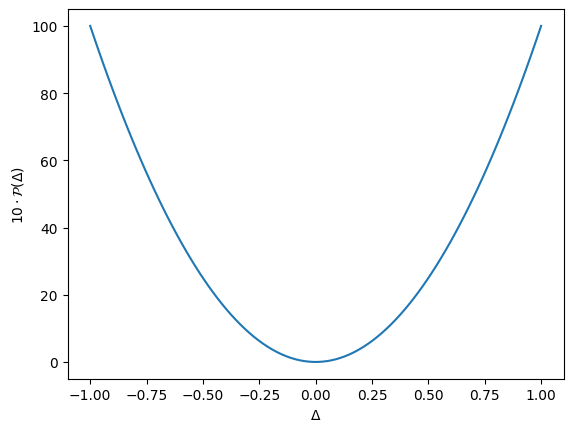

In [8]:
### soft threshold visual
xx=torch.tensor(np.linspace(-1,1,100))
#yy=soft_threshold(xx,thrd=0.2,slope=50)
yy=torch.pow(10*xx,2)
plt.plot(xx,yy)
plt.xlabel('$\Delta$')
plt.ylabel('$10\cdot \mathcal{P}(\Delta)$')

In [9]:
device0=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [22]:
class End2EndModel(torch.nn.Module):
    def __init__(self, data_pth,pIni_path,sampling_pattern, roi, *, 
                rfmax=rfmax0, gmax=gmax0, smax=torch.tensor(15000),dt=dt0,
                noise_level=5e-6,
                device=device0,
                checkpoint_savepth='./checkpoint/'):
        r'''
        Inputs:
            - ```data_pth```: path to the .mat file which has fields:
                -``I_mb1off``: fully-sampled images
                -``d_mb1off``: fully-sampled k-data
            - ```pIni_path```: path to the .npz file storing the initial RF pulse with fields:
                - "rf": [xy,nT]
                - "gr": [xyz,nT]
            - ```sampling_pattern```: tensor, (Cartesian, for now) acquisition pattern, [1,nx,ny,nz]
            - ```roi```: tensor, ROI mask, [1,nx,ny,nz]
        Optionals:
            - ```rfmax```: [Gauss], dflt=0.25, tensor, rf amplitude maximum by hardware limit, [1,]
            - ```gmax```: [Gauss/cm]], dflt=5, tensor, gradients maximum, [1,]
            - ```smax```: [Gauss/cm/sec], dflt=15e3, tensor, slew rate limit, [1,]
            - ```dt```: [sec],dflt=4e-6, tensor, raster time, [1,]
            - ```noise_level```: scalar, k space synthesized noise intensity
            
        '''
        super(End2EndModel, self).__init__()
        self.device=device
        self.checkpoint_savepth=checkpoint_savepth
        kw={'dtype': torch.float32, 'device':self.device}
        
        #hard-ware parameters
        self.rfmax,self.gmax,self.smax,self.dt=rfmax.to(device),gmax.to(device),smax.to(device),dt.to(device)
        
        #sequence parameters
        self.alpha=20
        self.TR=80e-3 #80ms
        
        self.data=scipy.io.loadmat(data_pth)
        self.I_mb1off=torch.tensor(self.data['I_mb1off']).to(self.device) #[nx,ny,nz]
        
        #subject-specific tissue parameters
#         data_npz=np.load(tissue_path)
#         #self.Ireal = torch.tensor(data_npz["I"],**kw)
#         self.t1map = torch.tensor(data_npz['t1map'],**kw)#*1e-3
#         self.t2map = torch.tensor(data_npz['t2map'],**kw)#*1e-3 #unit to sec
#         self.M0 = np.zeros(data_npz['pdmap'].shape+(3,)) #[nx,ny,nz,3]
#         self.M0[...,2]=data_npz['pdmap'] 
#         self.M0=torch.tensor(self.M0,**kw)
        
        #field inhomogeneity
        #############TODO###############
        
        #load the initial rf pulse
        pulse_npz=np.load(pIni_path)
        self.rf=torch.tensor(pulse_npz['rf']).to(self.device)
        self.gr=torch.tensor(pulse_npz['gr']).to(self.device)
        self.pIni=Pulse(rf=self.rf,gr=self.gr,rfmax=self.rfmax,gmax=self.gmax,smax=self.smax,
                       dt=self.dt,device=self.device)
        
        # Set up: Interior mapping, transform rf to (rho_tilde, theta_tilde), gr to s_tilde so as to enforce hard-ware limits, cf. tianrui's AutoDiff paper
        tρ, θ = utils.rf2tρθ(self.rf, self.rfmax)
        tsl = utils.s2ts(utils.g2s(self.gr, self.dt), self.smax)

        # enforce contiguousness of optimization variables, o.w. LBFGS may fail
        self.tρ, self.θ, self.tsl = tρ.contiguous(), θ.contiguous(), tsl.contiguous()

        self.tρ = torch.nn.Parameter(self.tρ) # Use nn.Parameter to enable optimization.
        self.θ= torch.nn.Parameter(self.θ)
        self.tsl=torch.nn.Parameter(self.tsl)
        
        # acquisition parameters
        self.noise_level=noise_level
        self.sampling_pattern=sampling_pattern.to(self.device)
        
        #optimizers
        self.opt_rf_lbfgs = torch.optim.LBFGS(list(self.parameters())[:2], lr=3., max_iter=20, history_size=30,
                 tolerance_change=1e-4,
                 line_search_fn='strong_wolfe') #optimizer for [rho, theta], aka rf #lr=3. before

        self.opt_sl_lbfgs = torch.optim.LBFGS([list(self.parameters())[2]], lr=3., max_iter=40, history_size=60,
                 tolerance_change=1e-6,
                 line_search_fn='strong_wolfe') #optimizer for slew, aka gradients #lr=3. before
        self.opt_rf_adam=torch.optim.Adam(list(self.parameters())[:2],lr=5e-3,amsgrad=True)
        self.opt_sl_adam=torch.optim.Adam([list(self.parameters())[2]],lr=1e-4,amsgrad=True)
        
        #ROI
        self.roi=roi.to(self.device)
        
    def forward(self):
        
#         t1map=self.t1map.unsqueeze(0) #[1,*nM]
#         t2map=self.t2map.unsqueeze(0)
#         M0=self.M0.unsqueeze(0)
#         shape=t1map.shape
        t1map=460e-3
        t2map=60e-3
        resize_factor=3
        shape=(1,)+tuple(np.array(self.I_mb1off.shape)//resize_factor)
    
        fov=torch.tensor([[24,24,24]]).to(self.device) #cm
        # 1. create a SpinCube based on subject parameters
        phantom=SpinCube(shape,fov,T1=t1map,T2=t2map,device=self.device)
        
        # 2. bloch sim to get ss-Mz
        self.rf= utils.tρθ2rf(self.tρ, self.θ, self.rfmax)
        self.gr= utils.s2g(utils.ts2s(self.tsl, self.smax), self.dt)
        self.rfpulse=Pulse(rf=self.rf,gr=self.gr,dt=self.dt, gmax=self.gmax, smax=self.smax, rfmax=self.rfmax,device=self.device)
        Mss=phantom.applypulse_ss(self.rfpulse,doEmbed=True,alpha=self.alpha,TR=self.TR) #[1,*nM,3]
        Mss.nan_to_num_()
        
        # 3. weight I_mb1off to simulate tEXT
        Mz_hp=b2mz(torch.tensor([0]).to(device0),phantom,TR=self.TR,alpha=self.alpha)  #Mz for hard-pulse
        Mz_hp=torch.unique(Mz_hp[~torch.isnan(Mz_hp)]) #scalar
        weight=Mss.squeeze(0)[...,2]/Mz_hp
        
        # upsampled to match shape of I_mb1off
        weight=torch.nn.functional.interpolate(weight.unsqueeze(0).unsqueeze(0),scale_factor=resize_factor,mode='nearest')
        weight=weight.squeeze(0).squeeze(0)
        I_mb1w=self.I_mb1off*weight
        
        # 4. Retrospectively under-sampled I_mb1w and do CG-SENSE recon 
        smap=torch.tensor(self.data['smap']).to(self.device).permute(3,0,1,2) #(ncoil,nx,ny,nz)
        #print(f'smap shape: {smap.shape} \t mask shape: {self.sampling_pattern.shape}')
        self.A = Sense(smap.unsqueeze(0), self.sampling_pattern.unsqueeze(0)) # smap=[nbatch,ncoil,*nM] sampling_pattern=[nbatch,*nM]
        self.kunder = self.A * (I_mb1w.unsqueeze(0).unsqueeze(0)) #kunder=(nbatch,ncoil,*nM)
        # Simulate the additive Gaussian noise
        #self.kunder = self.kunder + self.noise_level*torch.randn_like(self.kunder)
        self.Iunder = self.A.H * self.kunder #Iunder=[nbatch,1,*nM]
        I = Identity((1,1,)+self.I_mb1off.shape)
        CG_solver = CG(self.A.H*self.A+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
        self.Irecon = CG_solver.run(self.Iunder,self.Iunder)
        self.Irecon=self.Irecon.squeeze(1).squeeze(0) #[*nM]
        
        # 5. loss
        self.loss_ext = torch.sum(soft_threshold(weight-1,thrd=0.20,slope=100)*self.roi)/torch.sum(self.roi)
        #self.loss_ext=torch.sum((weight-1)**2*self.roi)/torch.sum(self.roi) #MSE
#         indices=torch.nonzero(self.roi==1,as_tuple=True)
#         lx=torch.max(indices[0])-torch.min(indices[0])+1
#         ly=torch.max(indices[1])-torch.min(indices[1])+1
#         lz=torch.max(indices[2])-torch.min(indices[2])+1
#         self.loss_ext=total_variation_3d(weight[self.roi==1].reshape(lx,ly,lz))#total variation l2-norm
        
        Imax=torch.max(torch.abs(self.I_mb1off)*self.roi)
        self.psnr=torch.abs(PSNR(torch.abs(I_mb1w*self.roi), torch.abs(self.Irecon*self.roi),Imax,self.roi,norm='least-dist'))
        eta=0.5 # good for soft_threhsold
        #eta=10e-3 #penalty coeff. good for TV
        self.penalty=eta*self.loss_ext
        #self.psnr=torch.abs(PSNR(torch.abs(self.I_mb1off*self.roi), torch.abs(self.Irecon*self.roi),self.roi,norm='least-dist'))
        return
    
    def backward_G(self):
        self.opt_rf_lbfgs.zero_grad()
        self.opt_sl_lbfgs.zero_grad()
        
        self.forward()
        
        self.loss_G=-self.psnr+self.penalty
        self.loss_G.backward()
        return self.loss_G
    
    def optimize_parameters(self,niter,niter_adam,niter_lbfgs,niter_rf, niter_gr,*, iter_start=0, doSave=True):
#         Inputs:
#             - ``niter``: total iteration
#             - ``niter_adam``: total iteration of Adam
#             - ``niter_lbfgs``: total iteration of LBFGS
#             - ``niter_rf``: iteration for rf-loop
#             - ``niter_gr``:iteration for gr-loop
#         Optionals:
#             - ``iter_start``: start from which iteration, dflt=0
#             - ``doSave``: save model at the end of each iteration

        start=time.time()
        
        #set up monitors
        length = 1+niter*(niter_adam+niter_lbfgs)*(niter_gr+niter_rf)
        time_hist = np.full((length,), np.nan)
        loss_hist = np.full((length,), np.nan)
        error_hist = np.full((length,), np.nan)
        pen_hist = np.full((length,), np.nan)
        
        log_col = ('\n#iter\t ‖ elapsed time\t ‖ PSNR\t ‖ pen\t ‖'
               ' total loss\t ‖ avg loss')
        
        nM_roi=torch.sum(self.roi) #number of voxels with ROI
        def logger(i, t0, loss, err, pen):
            e, p,lo = err.item(), pen.item(), loss.item()
            msg = (f'{i}\t | {time.time()-t0:.3f}\t | {e:.5f}\t | {p:.5f}\t |'
                   f'{lo:.6f}\t | {lo/nM_roi:.3e}')
            print(msg)
            return loss
        
        self.forward()
        #print(f'====== Initial loss:{self.loss_maskl2}')
        print(f'====== Initial PSNR:{self.psnr}\t Inital Penalty:{self.penalty}=======')
        
        for ii in range(iter_start,iter_start+niter):
            #Adam
            for i in range(niter_adam):
                print(f'Adam Iterations:{i+1}/{niter_adam}')
                if not((ii-iter_start) % 3):
                    print(log_col)
                log_ind=0

                print('rf-loop',niter_rf)
                for _ in range(niter_rf):
                    self.opt_rf_adam.zero_grad()
                    self.forward()
                    self.loss_G=-self.psnr+self.penalty
                    self.loss_G.backward()
                    self.opt_rf_adam.step()
                    
                    #logger(i+1,start,self.loss_G,self.loss_maskl2)
                    logger(ii+1,start,self.loss_G,self.psnr,self.penalty)

                    ind = ((ii-iter_start)*(niter_adam+niter_lbfgs)+i)*(niter_gr+niter_rf)+log_ind+1
                    time_hist[ind], loss_hist[ind]=(time.time()-start, self.loss_G.item())
                    error_hist[ind], pen_hist[ind]=(self.psnr.item(), self.penalty.item())

                    log_ind += 1
                print('gr-loop',niter_gr)
                for _ in range(niter_gr):
                    self.opt_sl_adam.zero_grad()
                    self.forward()
                    self.loss_G=-self.psnr+self.penalty
                    self.loss_G.backward()
                    self.opt_sl_adam.step()
                    #print(self.gr)
                    #logger(i+1,start,self.loss_G,self.loss_maskl2)
                    logger(ii+1,start,self.loss_G,self.psnr,self.penalty)

                    ind = ((ii-iter_start)*(niter_adam+niter_lbfgs)+i)*(niter_gr+niter_rf)+log_ind+1
                    time_hist[ind], loss_hist[ind]=(time.time()-start, self.loss_G.item())
                    error_hist[ind], pen_hist[ind]=(self.psnr.item(), self.penalty.item())

                    log_ind += 1
                    
            #LBFGS
            for j in range(niter_lbfgs):
                print(f'LBFGS Iterations:{j+1}/{niter_lbfgs}')
                if not((ii-iter_start) % 3):
                    print(log_col)
                log_ind=0

                print('rf-loop',niter_rf)
                for _ in range(niter_rf):
                    self.opt_rf_lbfgs.step(self.backward_G)

                    #logger(i+1,start,self.loss_G,self.loss_maskl2)
                    logger(ii+1,start,self.loss_G,self.psnr,self.penalty)

                    ind = ((ii-iter_start)*(niter_adam+niter_lbfgs)+niter_adam+j)*(niter_gr+niter_rf)+log_ind+1
                    time_hist[ind], loss_hist[ind]=(time.time()-start, self.loss_G.item())
                    error_hist[ind], pen_hist[ind]=(self.psnr.item(), self.penalty.item())

                    log_ind += 1
                print('gr-loop',niter_gr)
                for _ in range(niter_gr):
                    self.opt_sl_lbfgs.step(self.backward_G)
                    #print(self.gr)
                    #logger(i+1,start,self.loss_G,self.loss_maskl2)
                    logger(ii+1,start,self.loss_G,self.psnr,self.penalty)

                    ind = ((ii-iter_start)*(niter_adam+niter_lbfgs)+niter_adam+j)*(niter_gr+niter_rf)+log_ind+1
                    time_hist[ind], loss_hist[ind]=(time.time()-start, self.loss_G.item())
                    error_hist[ind], pen_hist[ind]=(self.psnr.item(), self.penalty.item())

                    log_ind += 1
            if doSave: 
                self.save_network(self.checkpoint_savepth,ii+1)
                
        print('\n====== Results: ======')
        print(log_col)
        #logger(i+1,start,self.loss_G,self.loss_maskl2)
        logger(ii+1,start,self.loss_G,self.psnr,self.penalty)
        
        optPulse={
            'rf':self.rf.detach(),
            'gr':self.gr.detach()
        }
        optHist={
            'time_hist':time_hist,
            'loss_hist':loss_hist,
            'error_hist':error_hist,
            'pen_hist':pen_hist
        }
        return optPulse, optHist
    
    def save_network(self,save_dir, which_epoch):
        r''' save network state at the end of 'which_epoch'
        Inputs:
        - ```save_dir```: str, save directory
        - ```which_epoch```: int
        '''
        os.makedirs(save_dir,exist_ok=True)
        
        save_filename='iter_%s_checkpoint.pth' % (which_epoch)
        save_path=os.path.join(save_dir,save_filename)
        
        checkpoint={
            'model_state_dict':self.state_dict(),
            'opt_rf_adam_state_dict': self.opt_rf_adam.state_dict(),
            'opt_sl_adam_state_dict': self.opt_sl_adam.state_dict(),
            'opt_rf_lbfgs_state_dict': self.opt_rf_lbfgs.state_dict(),
            'opt_sl_lbfgs_state_dict': self.opt_sl_lbfgs.state_dict(),
        }
        torch.save(checkpoint,save_path)
        print(f'Checkpoint saved at: {save_path}')
        
    def load_network(self, load_path):
        r''' load network from checkpoint 'load_path'
        '''
        if not torch.cuda.is_available():
            checkpoint = torch.load(load_path, map_location=torch.device('cpu'))
        else:
            checkpoint = torch.load(load_path)
            
        self.load_state_dict(checkpoint['model_state_dict'])
        self.opt_rf_adam.load_state_dict(checkpoint['opt_rf_adam_state_dict'])
        self.opt_sl_adam.load_state_dict(checkpoint['opt_sl_adam_state_dict'])
        self.opt_rf_lbfgs.load_state_dict(checkpoint['opt_rf_lbfgs_state_dict'])
        self.opt_sl_lbfgs.load_state_dict(checkpoint['opt_sl_lbfgs_state_dict'])
        
        print(f"Checkpoint loaded from: {load_path}")


Let's start optimze the RF pulse based on ROI image PSNR!

In [ ]:
## Prepare network inputs ####
data=scipy.io.loadmat('/home/yonglihe/github/ROI-GUIDE/data/4greatlakes-PHANTOM-20241118.mat')
smap=torch.tensor(data['smap']).to(device0).permute(3,0,1,2)
I_mb1off=torch.tensor(data['I_mb1off']).to(device0)
[nc,nx,ny,nz]=smap.shape

data_pth='/home/yonglihe/github/ROI-GUIDE/data/4greatlakes-PHANTOM-20241118.mat'
pIni_pth='/home/yonglihe/github/ROI-GUIDE/data/pAD-EXT-guide-PHANTOM-TR80ms.npz'
sample_mask=torch.tensor(data['maskpky']).repeat(nx,1,1).to(device0)
roi=torch.zeros_like(torch.abs(I_mb1off))
roi[30:60,30:60,30:60]=1

### Define Model #####
niter_rf=2
niter_gr=2
niter_adam=5
niter_lbfgs=2
niter=4
model=End2EndModel(data_pth,pIni_pth,sample_mask,roi,checkpoint_savepth='./checkpoint/hybrid_optim/soft_threshold_penalty')
#model.load_network('./checkpoint/iter_2_checkpoint.pth')
[optPulse,optHist]=model.optimize_parameters(niter,niter_adam,niter_lbfgs,niter_rf,niter_gr,iter_start=0)


====== Initial PSNR:35.77928161621094	 Inital Penalty:0.6679762601852417=======
Adam Iterations:1/5

#iter	 ‖ elapsed time	 ‖ PSNR	 ‖ pen	 ‖ total loss	 ‖ avg loss
rf-loop 2
1	 | 4.383	 | 35.77928	 | 0.66798	 |-35.111305	 | -1.300e-03
1	 | 6.901	 | 35.75605	 | 0.64337	 |-35.112679	 | -1.300e-03
gr-loop 2
1	 | 9.421	 | 35.73244	 | 0.62355	 |-35.108894	 | -1.300e-03
1	 | 11.940	 | 36.67558	 | 7.80851	 |-28.867062	 | -1.069e-03
Adam Iterations:2/5

#iter	 ‖ elapsed time	 ‖ PSNR	 ‖ pen	 ‖ total loss	 ‖ avg loss
rf-loop 2
1	 | 14.472	 | 36.63876	 | 9.04342	 |-27.595337	 | -1.022e-03
1	 | 16.994	 | 36.63341	 | 8.99813	 |-27.635284	 | -1.024e-03
gr-loop 2
1	 | 19.514	 | 36.62491	 | 8.94347	 |-27.681446	 | -1.025e-03
1	 | 22.048	 | 36.67014	 | 9.01613	 |-27.654009	 | -1.024e-03
Adam Iterations:3/5

#iter	 ‖ elapsed time	 ‖ PSNR	 ‖ pen	 ‖ total loss	 ‖ avg loss
rf-loop 2
1	 | 24.567	 | 36.06653	 | 7.79922	 |-28.267307	 | -1.047e-03
1	 | 27.224	 | 36.06113	 | 7.73989	 |-28.321239	 | -1.049e-03
g

In [19]:
np.savez('./checkpoint/hybrid_optim/TV_penalty/loss_log.npz',time_hist=optHist['time_hist'],
         loss_hist=optHist['loss_hist'],error_hist=optHist['error_hist'],pen_hist=optHist['pen_hist'])

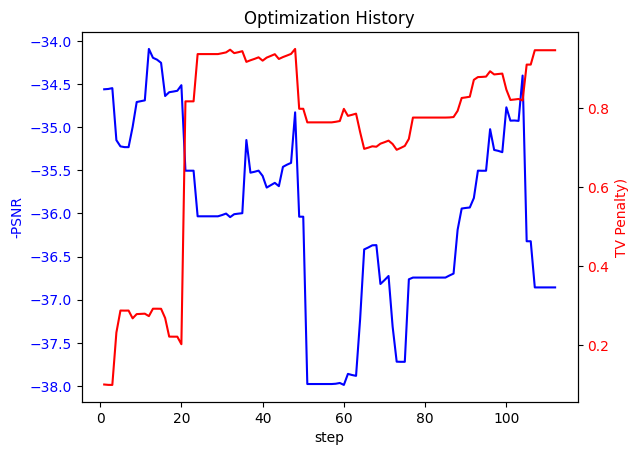

In [13]:
#optHist=np.load('./checkpoint/hybrid_optim/TV_penalty/loss_log.npz')
#tt=optHist['time_hist']
y1=optHist['error_hist']
y2=optHist['pen_hist']
x=np.arange(len(y1))

# Create the figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first line
ax1.plot(x, -y1, 'b-', label='Line 1')  # Blue line
ax1.set_xlabel('step')
ax1.set_ylabel('-PSNR', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second line
ax2.plot(x, y2, 'r-', label='Line 2')  # Red line
ax2.set_ylabel('TV Penalty)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title
plt.title('Optimization History')

# Show the plot
plt.show()

Let's look at the optimzied RF pulse

In [19]:
## Prepare network inputs ####
data=scipy.io.loadmat('/home/yonglihe/github/ROI-GUIDE/data/4greatlakes-PHANTOM-20241118.mat')
smap=torch.tensor(data['smap']).to(device0).permute(3,0,1,2)
I_mb1off=torch.tensor(data['I_mb1off']).to(device0)
#I_mb1on=torch.tensor(data['I_mb1on']).to(device0)
[nc,nx,ny,nz]=smap.shape

data_pth='/home/yonglihe/github/ROI-GUIDE/data/4greatlakes-PHANTOM-20241118.mat'
pIni_pth='/home/yonglihe/github/ROI-GUIDE/data/pAD-EXT-guide-PHANTOM-TR80ms.npz'
sample_mask=torch.tensor(data['maskpky']).repeat(nx,1,1).to(device0)
roi=torch.zeros_like(torch.abs(I_mb1off))
roi[30:60,30:60,30:60]=1

### load Model #####
niter_rf=1
niter_gr=1
niter=2
model=End2EndModel(data_pth,pIni_pth,sample_mask,roi)
model.load_network('./checkpoint/hybrid_optim/TV_penalty/iter_2_checkpoint.pth')

### Get optimal pulse ######
trho=model.tρ.detach()
ttheta=model.θ.detach()
tsl=model.tsl.detach()
rf_opt= utils.tρθ2rf(trho, ttheta, rfmax0.to(device0))
gr_opt= utils.s2g(utils.ts2s(tsl, torch.tensor(15e3).to(device0)), dt0.to(device0))


Checkpoint loaded from: ./checkpoint/hybrid_optim/TV_penalty/iter_2_checkpoint.pth


/tmp/ipykernel_3838144/1098059937.py:314: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)


In [15]:
pAD=Pulse(rf=rf_opt,gr=gr_opt, smax=torch.tensor(15e3).to(device0),device=device0)


In [20]:
pAD=Pulse(rf=optPulse['rf'],gr=optPulse['gr'], smax=torch.tensor(15e3).to(device0),device=device0)

Let's see what the optimized pulse excites

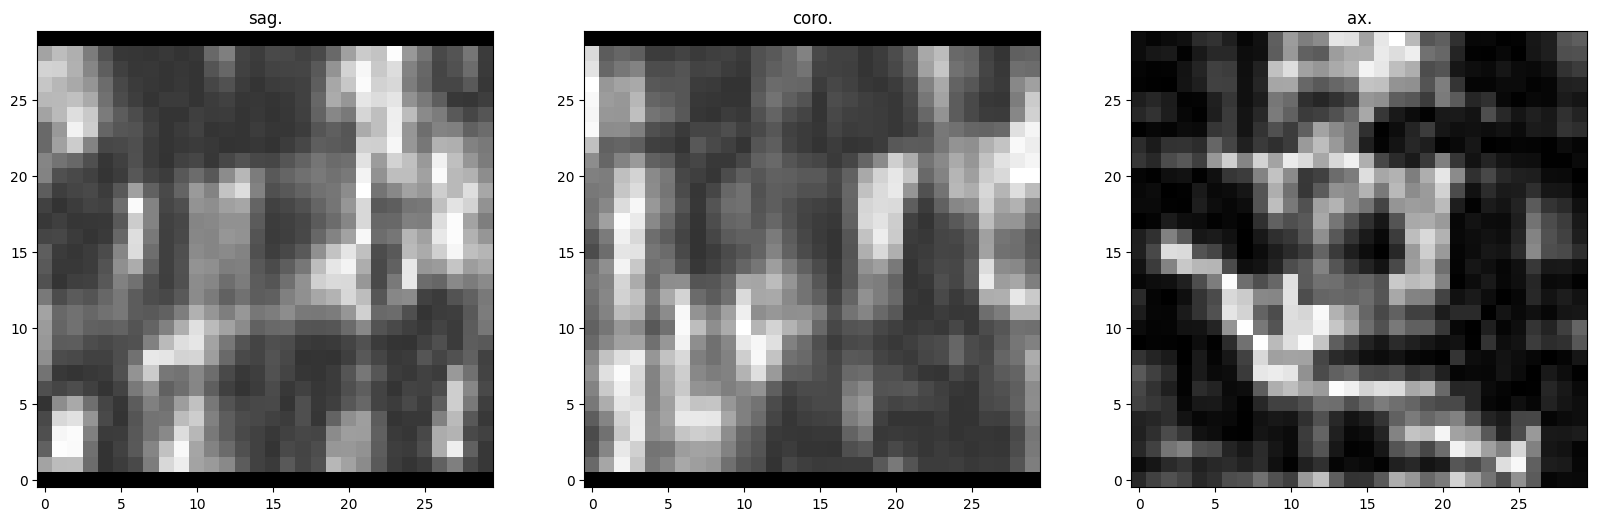

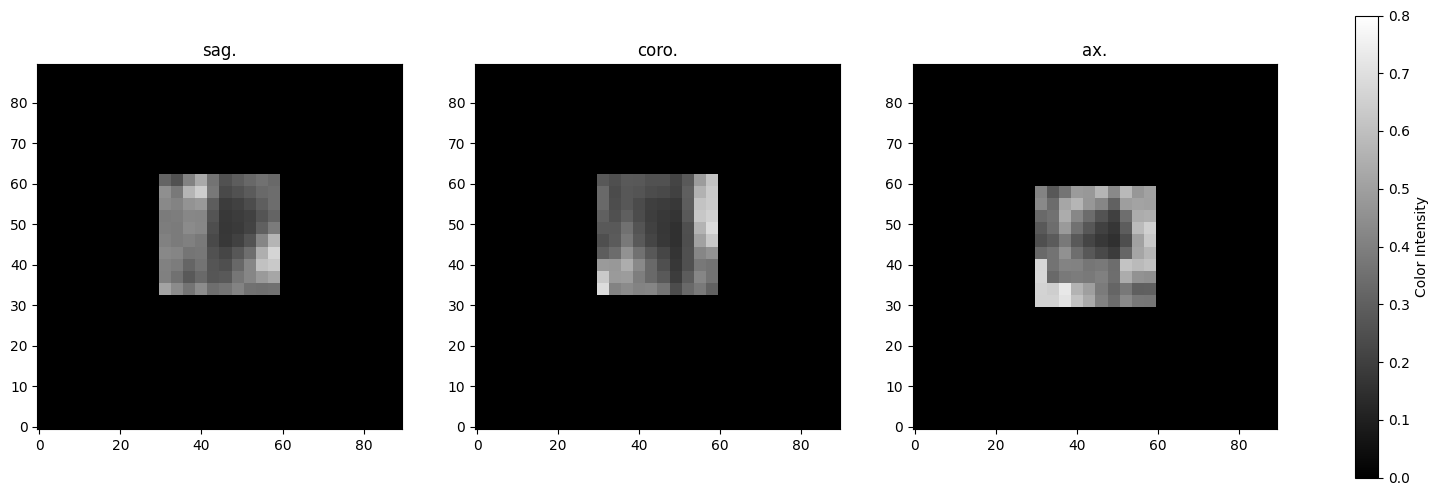

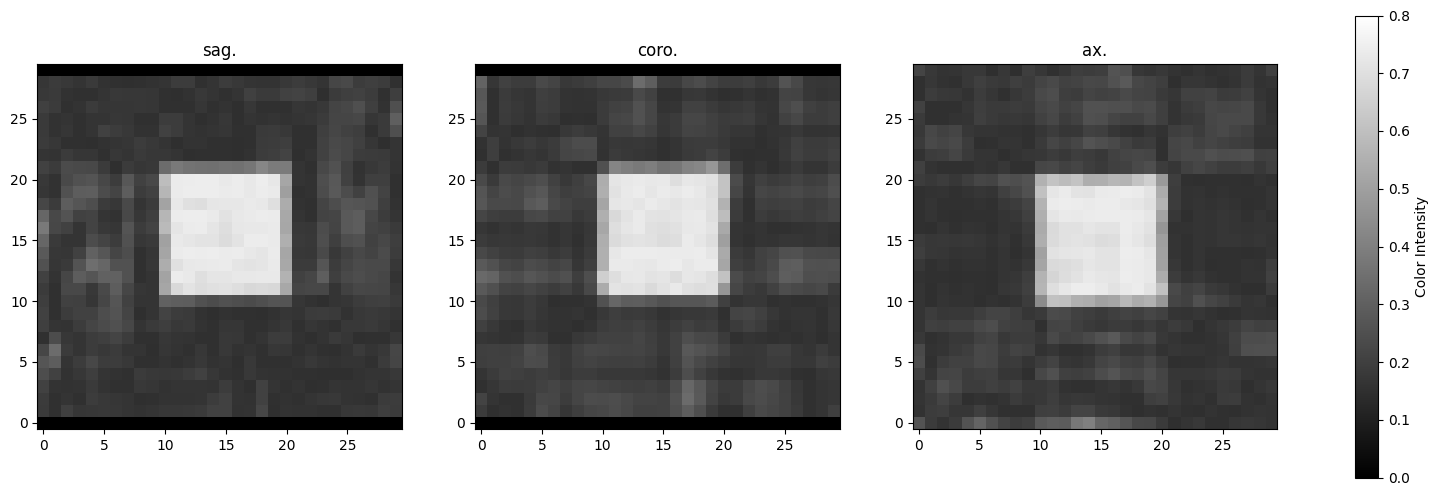

In [21]:
resize_factor=3
shape=(1,30,30,28)
fov=torch.tensor([[24,24,24]]).to(device0)
cube=SpinCube(shape,fov,T1=460e-3,T2=60e-3,device=device0)
Mss=cube.applypulse_ss(pAD,doEmbed=True,TR=80e-3,alpha=20)
SACshow(Mss[0,...,2]) # optimized excitation
Mss_90=torch.nn.functional.interpolate(Mss[0,...,2].unsqueeze(0).unsqueeze(0),scale_factor=resize_factor,mode='nearest')
SACshow(Mss_90.squeeze(0).squeeze(0)*roi,caxis=[0,0.8])

pulse_npz=np.load('/home/yonglihe/github/ROI-GUIDE/data/pAD-EXT-guide-PHANTOM-TR80ms.npz')
rf0=torch.tensor(pulse_npz['rf']).to(device0)
gr0=torch.tensor(pulse_npz['gr']).to(device0)
pIni=Pulse(rf=rf0,gr=gr0,smax=torch.tensor([15e3]).to(device0),device=device0)
Minit=cube.applypulse_ss(pIni,doEmbed=True,TR=80e-3,alpha=20)
SACshow(Minit[0,...,2],caxis=[0,0.8]) # initial excitation

In [29]:
Mz_hp=b2mz(torch.tensor([0]).to(device0),cube,TR=80e-3,alpha=20)  #Mz for hard-pulse
Mz_hp=torch.unique(Mz_hp[~torch.isnan(Mz_hp)]) #scalar
w=Minit[0,...,2].nan_to_num()/Mz_hp
roi_ds=torch.tensor(zoom(roi.cpu(),(1/2,1/2,1/2),order=0)).to(device0)
#torch.sum(soft_threshold(w-1,thrd=0.1,slope=100)*roi_ds)/torch.sum(roi_ds)
w[23,20,:]

tensor([0.2927, 0.2641, 0.2537, 0.2143, 0.2146, 0.2240, 0.2052, 0.2017, 0.2063,
        0.1963, 0.2072, 0.2071, 0.2024, 0.2470, 0.4720, 0.9170, 0.9037, 0.9357,
        0.9700, 0.9768, 0.9583, 0.9368, 0.9589, 0.9497, 0.9727, 0.9560, 0.9388,
        0.9755, 0.9602, 0.9113, 0.4799, 0.2411, 0.2040, 0.1952, 0.2167, 0.2222,
        0.2100, 0.1970, 0.2173, 0.2282, 0.2074, 0.2142], device='cuda:0')

In [25]:
## FS images ###
data_pth='./4greatlakes-PHANTOM-20241118.mat'
data=scipy.io.loadmat(data_pth)
I_mb1off=torch.tensor(data['I_mb1off']).to(device0)

Let's see what the tEXT looks like for the optimized pulse

In [104]:
Mz_hp=b2mz(torch.tensor([0]).to(device0),cube,TR=80e-3,alpha=20)  #Mz for hard-pulse
Mz_hp=torch.unique(Mz_hp[~torch.isnan(Mz_hp)]) #scalar
weight=Mss.squeeze(0)[...,2]/Mz_hp

# upsampled to match shape of I_mb1off
weight=torch.nn.functional.interpolate(weight.unsqueeze(0).unsqueeze(0),scale_factor=2,mode='trilinear',align_corners=False)
I_mb1w=I_mb1off*weight.squeeze(0).squeeze(0)

Retrospectively undersample to validate the PSNR improvement

In [105]:
smap=torch.tensor(data['smap']).to(device0).permute(3,0,1,2) #(ncoil,nx,ny,nz)
#print(f'smap shape: {smap.shape} \t mask shape: {self.sampling_pattern.shape}')
A = Sense(smap.unsqueeze(0), sample_mask.unsqueeze(0)) # smap=[nbatch,ncoil,*nM] sampling_pattern=[nbatch,*nM]
kunder = A * (I_mb1w.unsqueeze(0).unsqueeze(0)) #kunder=(nbatch,ncoil,*nM)
# Simulate the additive Gaussian noise
#self.kunder = self.kunder + self.noise_level*torch.randn_like(self.kunder)
Iunder = A.H * kunder #Iunder=[nbatch,1,*nM]
I = Identity((1,1,)+I_mb1off.shape)
CG_solver = CG(A.H*A+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
I_mb1w_recon = CG_solver.run(Iunder,Iunder)
I_mb1w_recon=I_mb1w_recon.squeeze(1).squeeze(0) #[*nM]

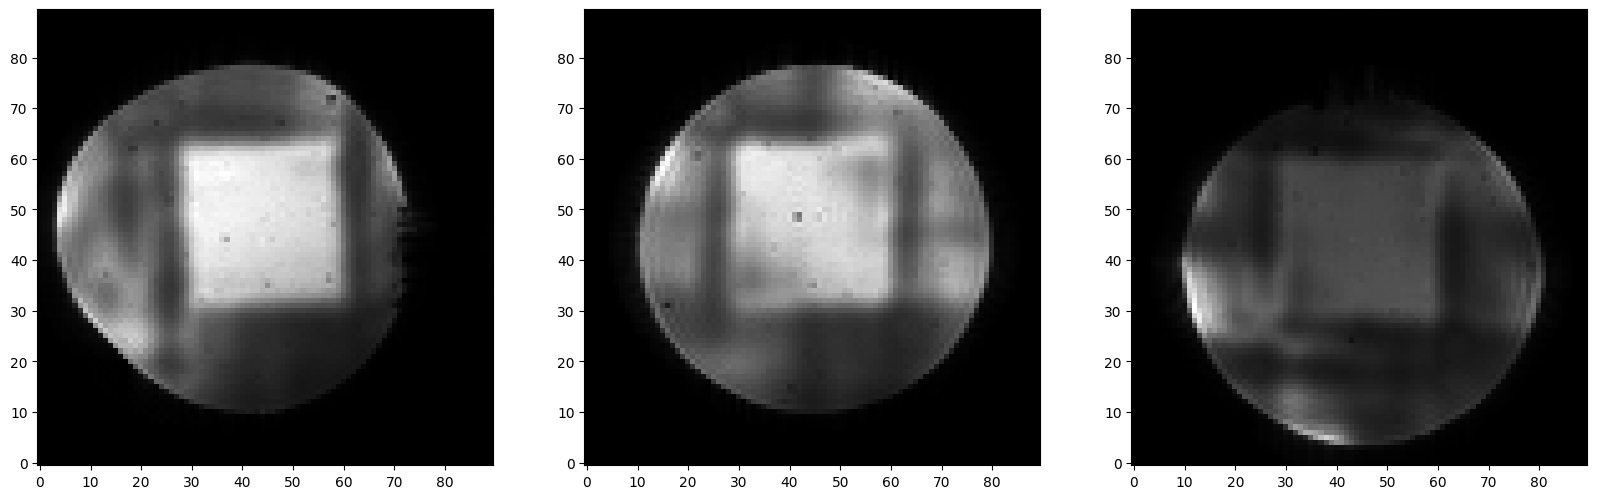

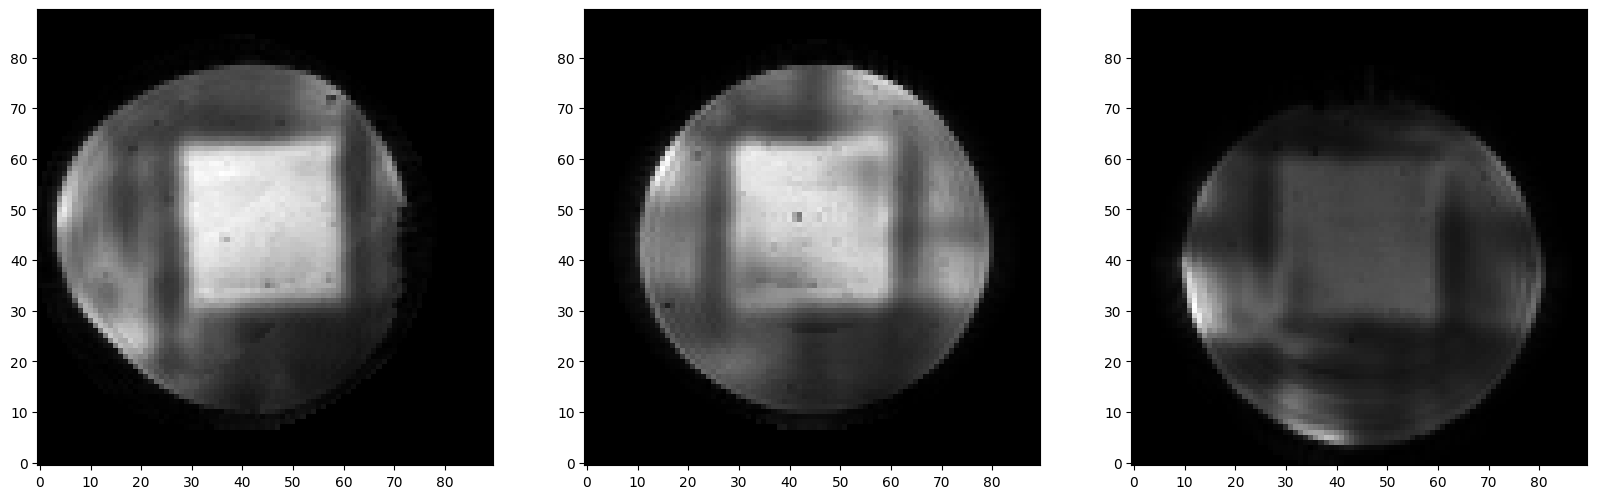

In [106]:
SACshow(abs(I_mb1w))
SACshow(abs(I_mb1w_recon))

In [107]:
psnr=torch.abs(PSNR(torch.abs(I_mb1w*roi), torch.abs(I_mb1w_recon*roi),roi,norm='least-dist'))
print(psnr)

tensor(37.0784, device='cuda:0')


Comparing the optimized pulse with the initial pulse

In [28]:
pulse_npz=np.load('../pIni-from-ROITrained-dim3.npz')
rf0=torch.tensor(pulse_npz['rf']).to(device0)
gr0=torch.tensor(pulse_npz['gr']).to(device0)
rf0=0.17*2*(torch.rand_like(rf0)-0.5)
gr0=torch.zeros_like(gr0)
pIni=Pulse(rf=rf0,gr=gr0,smax=torch.tensor([15e3]).to(device0),device=device0)
np.savez('../pIni-test.npz',rf=rf0.cpu(),gr=gr0.cpu())

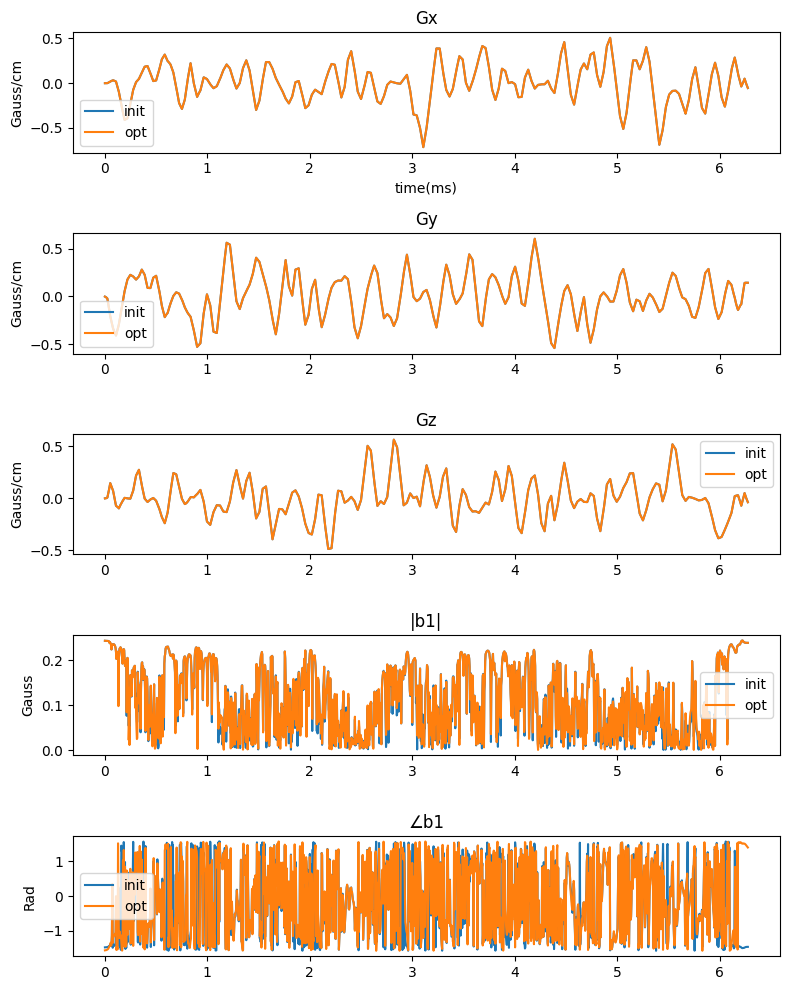

In [21]:
pulse_npz=np.load('../pAD-EXT-guide-PHANTOM-TR80ms.npz')
rf0=torch.tensor(pulse_npz['rf']).to(device0)
gr0=torch.tensor(pulse_npz['gr']).to(device0)
pIni=Pulse(rf=rf0,gr=gr0,smax=torch.tensor([15e3]).to(device0),device=device0)

compare_pulses([pIni,pAD],['init','opt'])

Let's see the difference between the initial and optimized gradients

In [95]:
(gr_opt-gr0).max()

tensor(0.0960, device='cuda:0', dtype=torch.float64)

Seems that:
- SAR is too high, should add l2 penality
- Excitation pattern is random; add IV signal fidelity penality

In [29]:
###################### Ground Truth Image ######################
data=scipy.io.loadmat('./4greatlakes-PHANTOM-20241118.mat')
smap=torch.tensor(data['smap']).to(device0).permute(3,0,1,2)
d_mb12off=torch.tensor(data['d_mb12off']).to(device0).permute(3,0,1,2)

[nc,nx,ny,nz]=smap.shape

sample_mask=torch.tensor(data['maskpky']).repeat(nx,1,1).to(device0)
Sop=Sense(smap.unsqueeze(0),sample_mask.unsqueeze(0))


Iunder=Sop.H*d_mb12off.unsqueeze(0)
Iunder3=Iunder.squeeze(0).squeeze(0) #[nx,ny,nz]

I = Identity((1,1,)+sample_mask.shape)
CG_solver = CG(Sop.H*Sop+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
I_mb12off = CG_solver.run(Iunder,Iunder)
I_mb12off=I_mb12off.squeeze(0).squeeze(0)

In [30]:
I_mb1off=torch.tensor(data['I_mb1off']).to(device0)

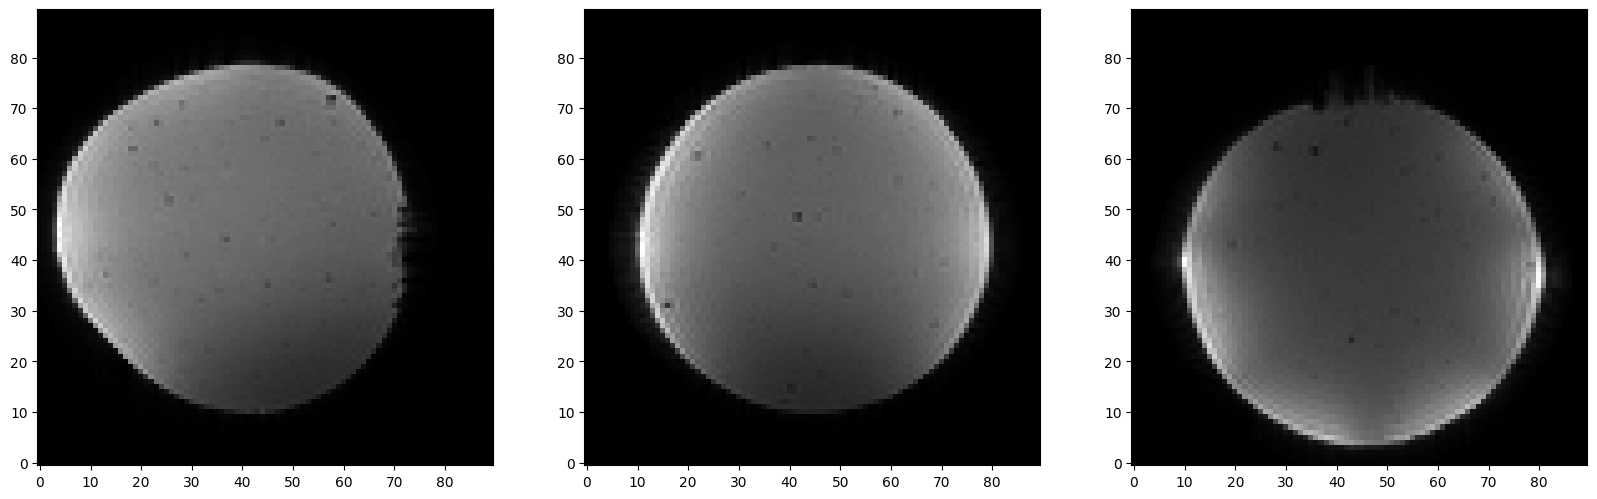

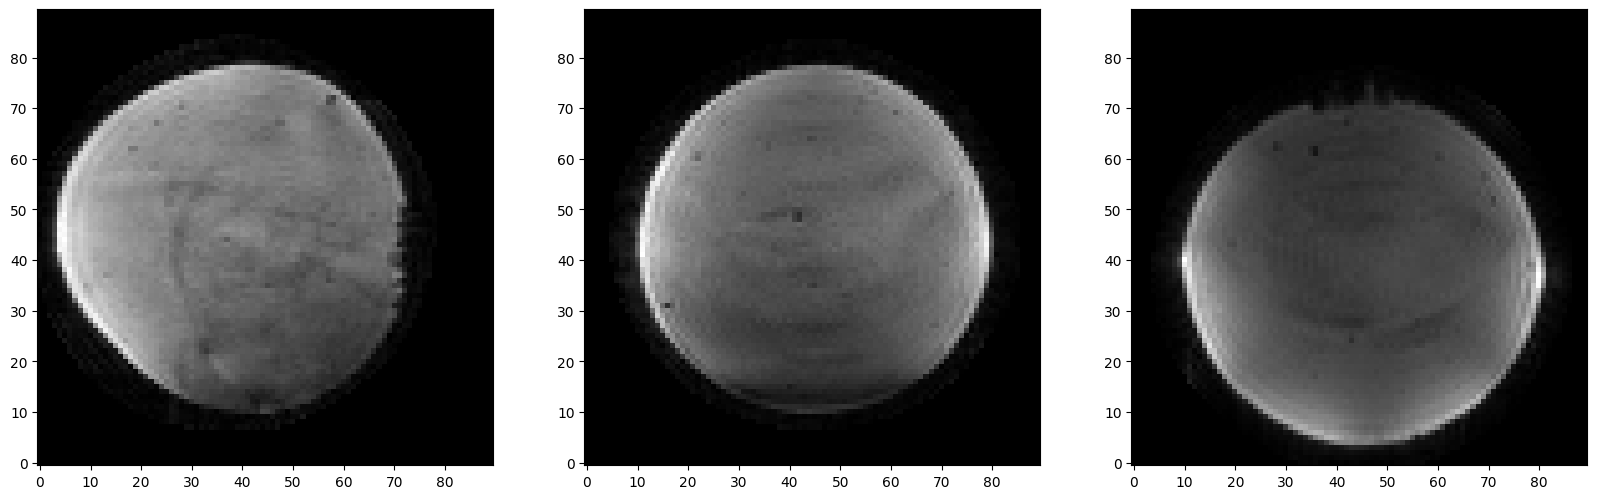

In [31]:
### 1115
SACshow(torch.abs(I_mb1off)) #fully-sampled
SACshow(torch.abs(I_mb12off)) #prospectivelyly undersampled

In [33]:
psnr=torch.abs(PSNR(torch.abs(I_mb1off*roi), torch.abs(I_mb12off*roi),roi,norm='least-dist'))
print(psnr)

tensor(26.6029, device='cuda:0', dtype=torch.float64)


Let's use an uniform phantom to simulate some tailored EXT pattern for the 2D tRF pulse

/tmp/ipykernel_154479/797418872.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask=torch.tensor(abs(I_mb1off.cpu())>0.2).unsqueeze(0).to(device0)
/home/yonglihe/miniconda3/envs/holisticMRI/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


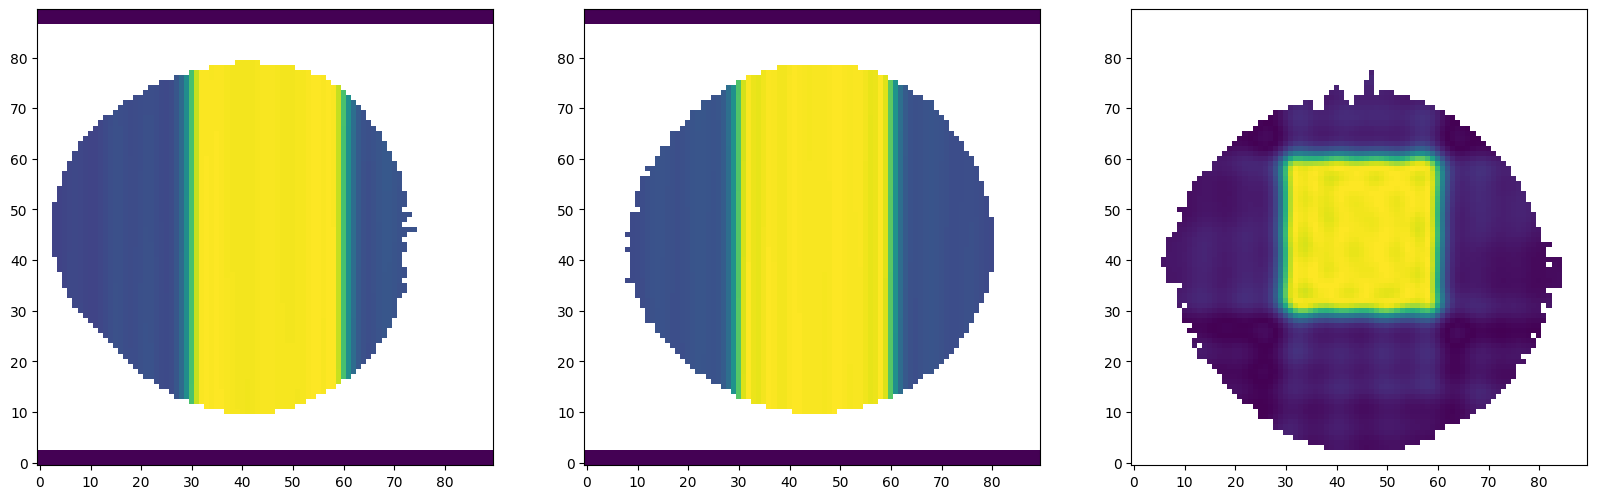

In [14]:
# simulate excitation pattern
# weight=torch.ones(nx,ny,nz).to(device0)*0.01
# weight[30:60,30:60,30:60]=0.08
#SACshow((I_mb1*weight).cpu())

shape=(1,nx,ny,nz)
fov=torch.tensor([[24,24,24]]).to(device0)
mask=torch.tensor(abs(I_mb1off.cpu())>0.2).unsqueeze(0).to(device0)
cube=SpinCube(shape,fov,mask=mask,T1=460e-3,T2=60e-3,device=device0)

pulse_npz=np.load('../pAD-EXT-guide-PHANTOM-TR80ms-2D.npz')
rf0=torch.tensor(pulse_npz['rf']).to(device0)#torch.tensor(pulse_npz['rf']).unsqueeze(0).to(device0)
gr0=torch.tensor(pulse_npz['gr']).to(device0)#torch.tensor(pulse_npz['gr']).unsqueeze(0).to(device0)
pIni=Pulse(rf=rf0,gr=gr0,smax=torch.tensor([15e3]).to(device0),device=device0)

Mss=cube.applypulse_ss(pIni,doEmbed=True,TR=80e-3)
SACshow(Mss.squeeze(0)[...,2].cpu(),cmap='viridis')



In [15]:
import math
def b2mz(beta,cube,TR=80e-3,alpha=20):
    r'''calculate steady-state Mz for SPGR sequence give OVS angle beta (in degree)
    '''
    M0=cube.M[...,2].unique()
    E1=torch.exp(-TR/cube.T1.unique()) #(N,*nM)
    
    Mz=(M0*(1-E1))/(1-torch.cos(torch.deg2rad(beta))*math.cos(math.radians(alpha))*E1)
    return Mz

In [26]:
Mz_hp=b2mz(torch.tensor([0]).to(device0),cube)  #Mz for hard-pulse
Mz_hp=torch.unique(Mz_hp[~torch.isnan(Mz_hp)])
weight=Mss.squeeze(0)[...,2].nan_to_num()/Mz_hp
weight[...,0:int(45-0.2*nz)]=0
weight[...,int(45+0.2*nz):]=0

I_mb1w=I_mb1off*weight

This is the weighted FS images with simulated tEXT

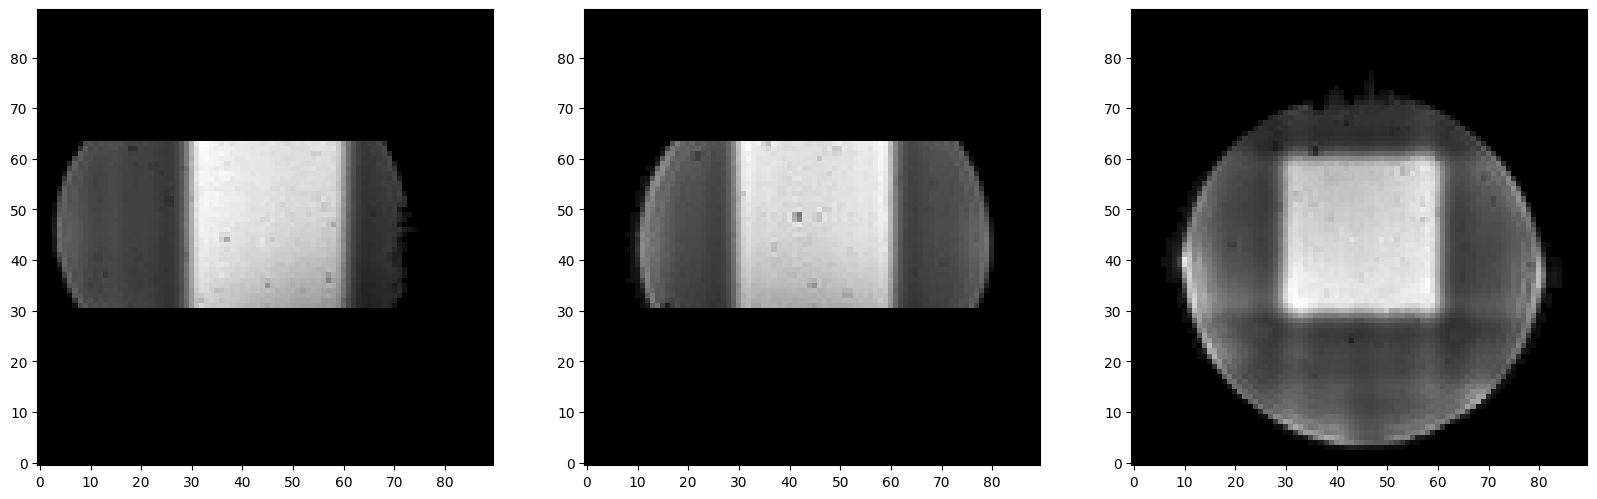

In [27]:
SACshow(abs(I_mb1w).cpu())

Let's retrospectively undersampled the simulated tEXT FS image

In [28]:
kunder=Sop*I_mb1w.unsqueeze(0).unsqueeze(0) #[nbatch,1,*nM]
Iunder=Sop.H*kunder
Iunder3=Iunder.squeeze(0).squeeze(0) #[nx,ny,nz]

I = Identity((1,1,)+sample_mask.shape)
CG_solver = CG(Sop.H*Sop+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
I_mb1w_recon = CG_solver.run(Iunder,Iunder)
I_mb1w_recon=I_mb1w_recon.squeeze(0).squeeze(0)

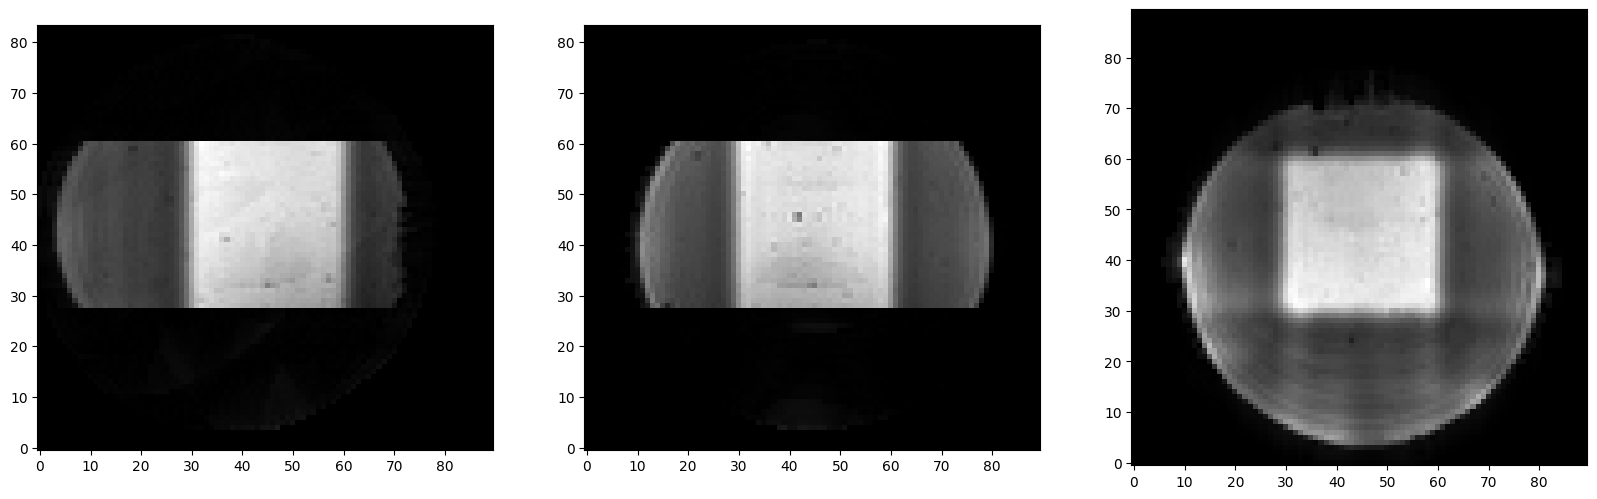

In [35]:
SACshow(abs(I_mb1w_recon).cpu(),pad=False)

Let's simualte a slice-selective excitation

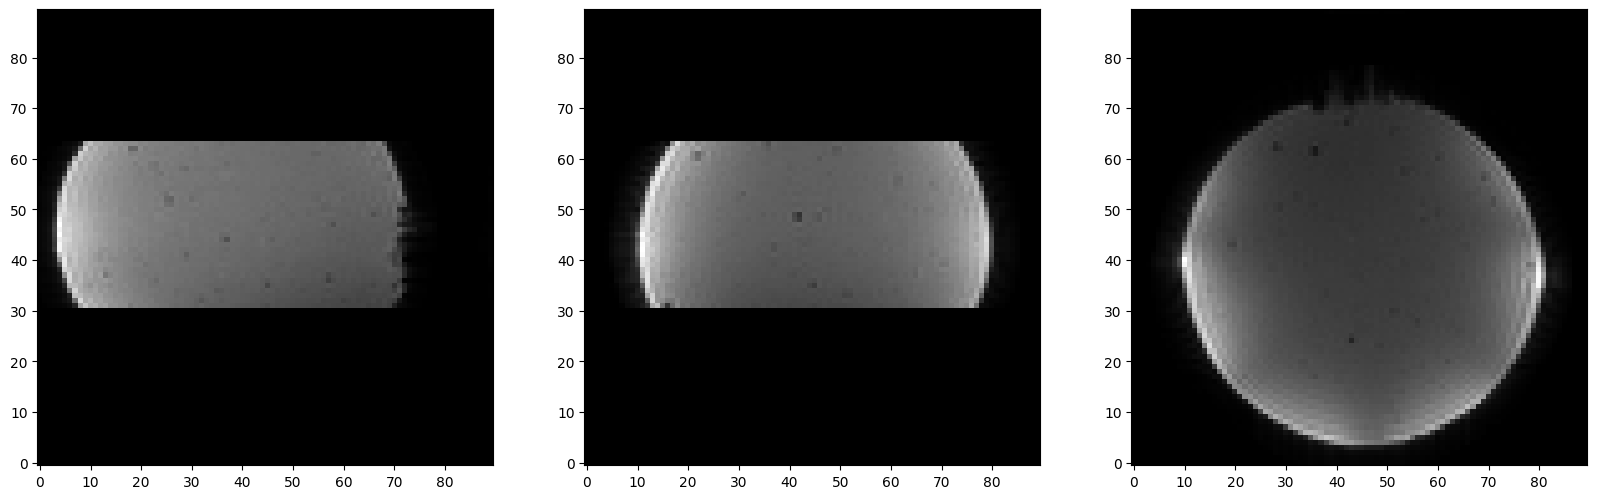

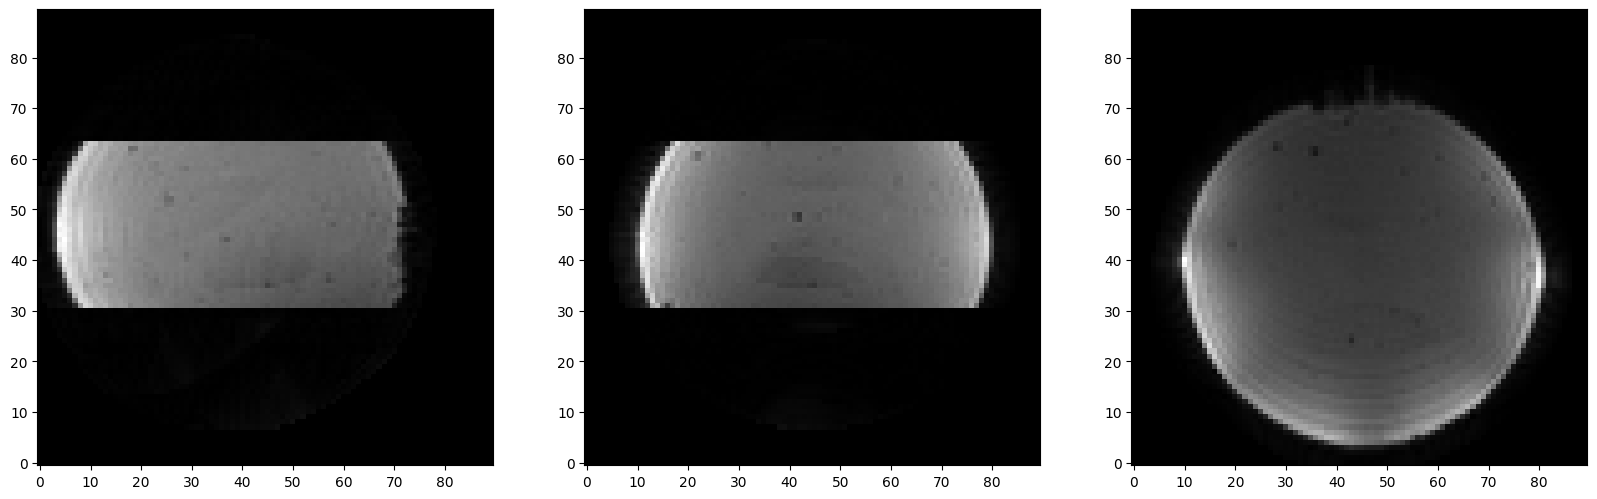

In [46]:
weight_slab=torch.zeros_like(I_mb1off)
weight_slab[...,int(45-0.2*nz):int(45+0.2*nz)]=1
I_mb1_slab=I_mb1off*weight_slab
SACshow(abs(I_mb1_slab))

#retrospectively undersampled this slab-selective excitation
kunder=Sop*I_mb1_slab.unsqueeze(0).unsqueeze(0) #[nbatch,1,*nM]
Iunder=Sop.H*kunder
Iunder3=Iunder.squeeze(0).squeeze(0) #[nx,ny,nz]

I = Identity((1,1,)+sample_mask.shape)
CG_solver = CG(Sop.H*Sop+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
I_mb12_slab = CG_solver.run(Iunder,Iunder)
I_mb12_slab=I_mb12_slab.squeeze(0).squeeze(0)
SACshow(abs(I_mb12_slab))

Let's see the error maps of slab-selective excitation case

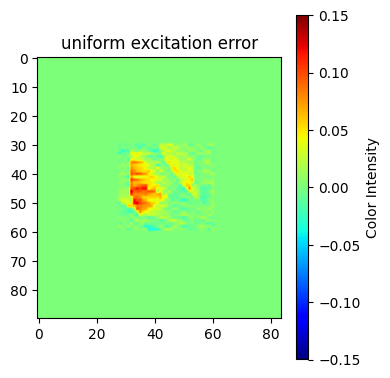

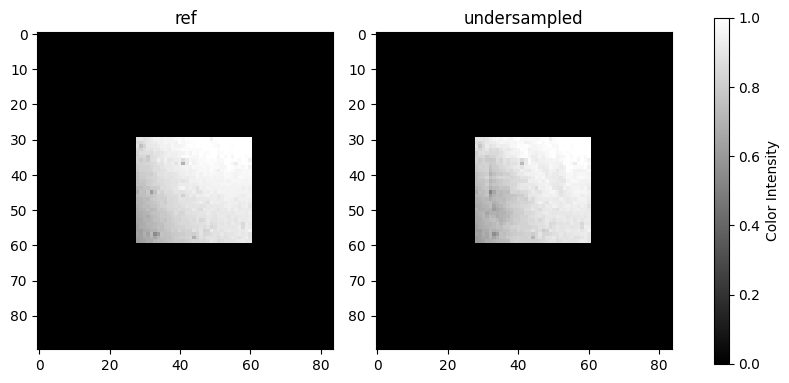

In [48]:
roi=torch.zeros_like(I_mb1off)
roi[30:60,30:60,28:61]=1
img1=torch.abs(I_mb1_slab*roi)
img1_norm=(img1-img1.min())/(img1.quantile(0.99)-img1.min())
img2=torch.abs(I_mb12_slab*roi)
img2_norm=(img2-img2.min())/(img2.quantile(0.99)-img2.min())
err1=img1_norm-img2_norm

errormap_cmp([err1[45,...].cpu()],['uniform excitation error'],[-0.15,0.15])

#look at the masked raw images
errormap_cmp([img1_norm[45,...].cpu(),img2_norm[45,...].cpu()],['ref','undersampled'],[0,1],cmap='gray')

Let's look the error of simulated tEXT case

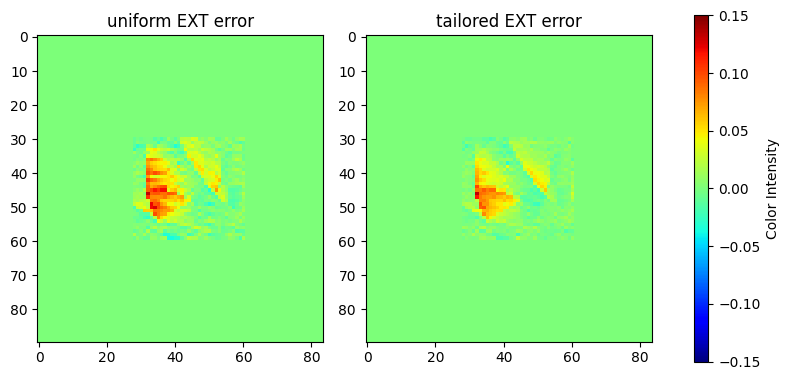

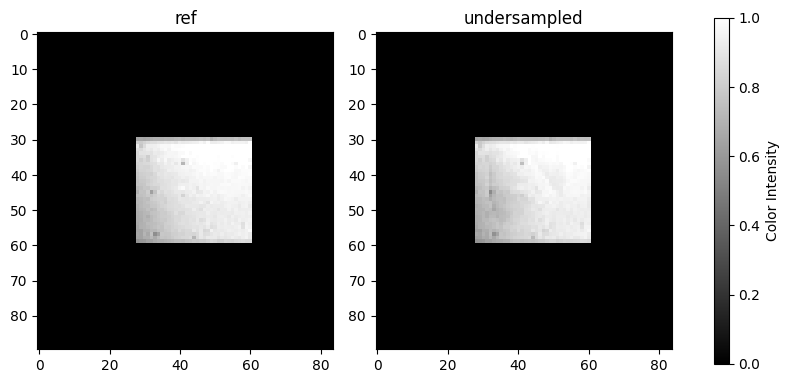

In [49]:
img1=torch.abs(I_mb1w*roi)
img1_norm=(img1-img1.min())/(img1.quantile(0.99)-img1.min())
img2=torch.abs(I_mb1w_recon*roi)
img2_norm=(img2-img2.min())/(img2.quantile(0.99)-img2.min())
err2=img1_norm-img2_norm

errormap_cmp([err1[45,...].cpu(),err2[45,...].cpu()],['uniform EXT error','tailored EXT error'],[-0.15,0.15])
errormap_cmp([img1_norm[45,...].cpu(),img2_norm[45,...].cpu()],['ref','undersampled'],[0,1],cmap='gray')

### OVS On real data

In [10]:
data=scipy.io.loadmat('./4greatlakes-PHANTOM-20241124.mat')
smap=torch.tensor(data['smap']).to(device0).permute(3,0,1,2)
d_mb12off=torch.tensor(data['d_mb12off']).to(device0).permute(3,0,1,2)

[nc,nx,ny,nz]=smap.shape

sample_mask=torch.tensor(data['maskpky']).repeat(nx,1,1).to(device0)
Sop=Sense(smap.unsqueeze(0),sample_mask.unsqueeze(0))


Iunder=Sop.H*d_mb12off.unsqueeze(0)
Iunder3=Iunder.squeeze(0).squeeze(0) #[nx,ny,nz]

I = Identity((1,1,)+sample_mask.shape)
CG_solver = CG(Sop.H*Sop+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
I_mb12off = CG_solver.run(Iunder,Iunder)
I_mb12off=I_mb12off.squeeze(0).squeeze(0)

In [11]:
d_mb12on=torch.tensor(data['d_mb12on']).to(device0).permute(3,0,1,2)

Iunder=Sop.H*d_mb12on.unsqueeze(0)
I_mb12on=CG_solver.run(Iunder,Iunder)
I_mb12on=I_mb12on.squeeze(0).squeeze(0)

In [12]:
I_mb1off=torch.tensor(data['I_mb1off']).to(device0)
I_mb1on=torch.tensor(data['I_mb1on']).to(device0)

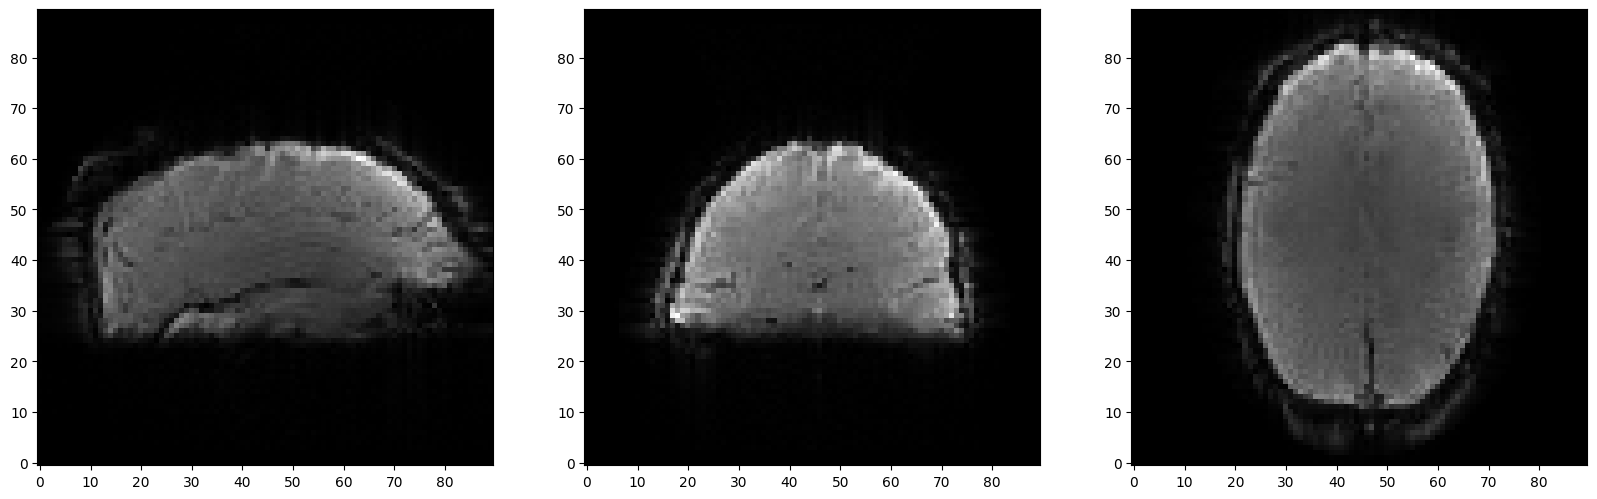

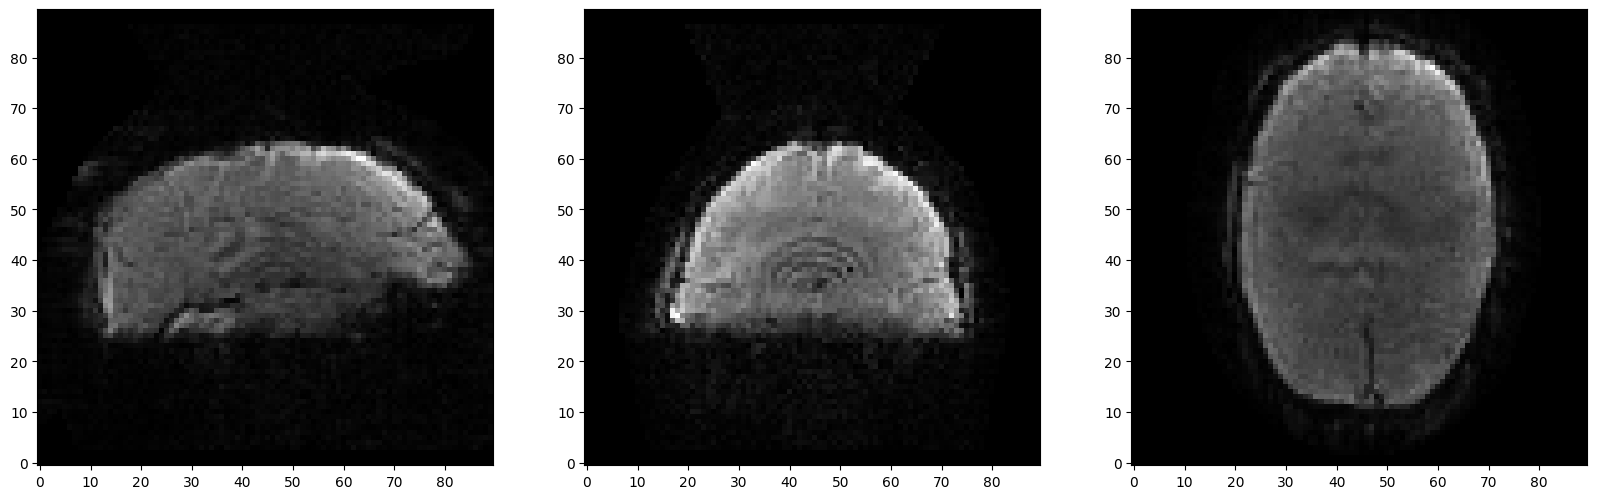

In [13]:
SACshow(abs(I_mb1off))
SACshow(abs(I_mb12off))

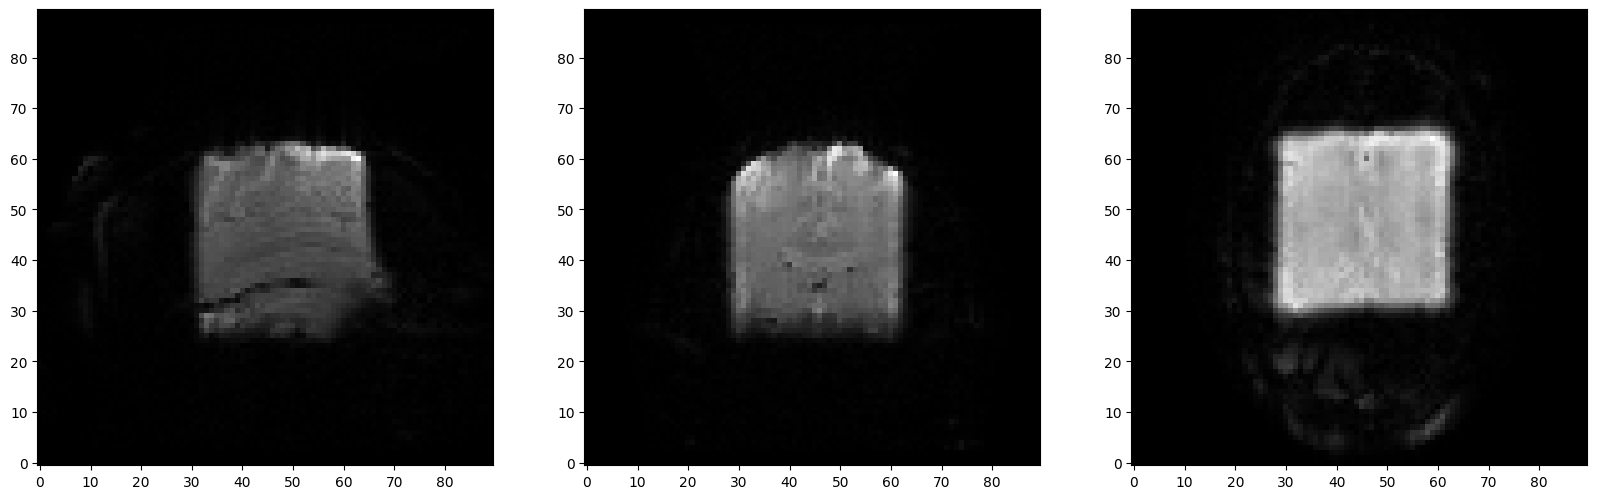

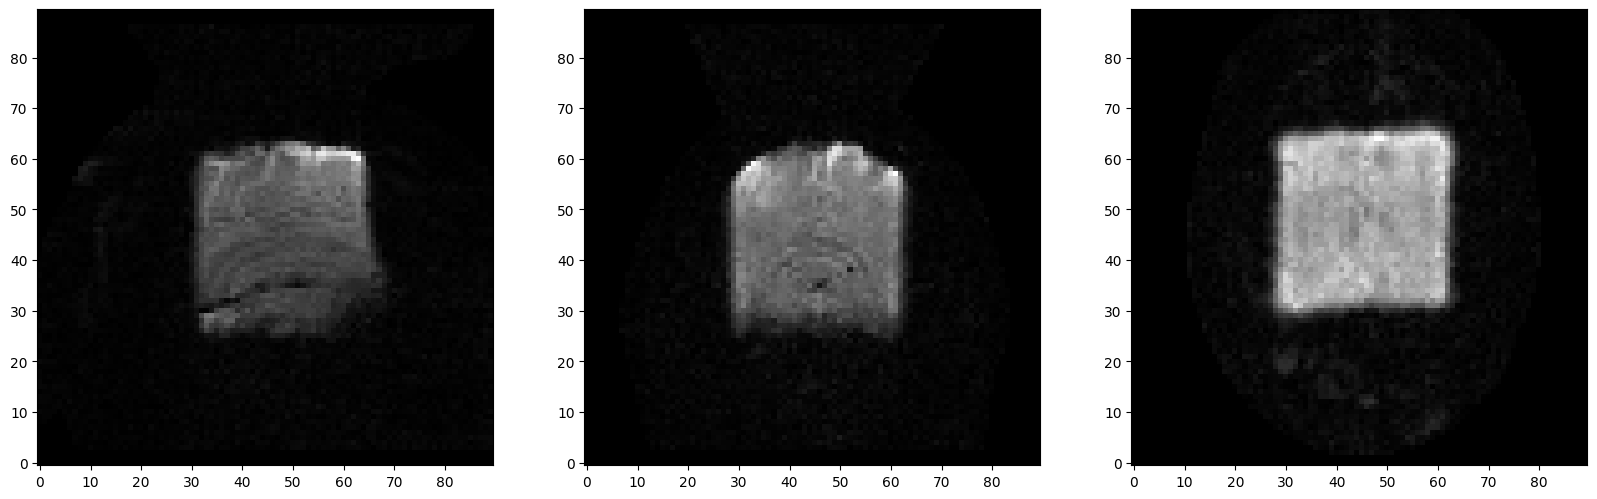

In [14]:
SACshow(abs(I_mb1on))
SACshow(abs(I_mb12on))

Let's look at the error of tEXT case

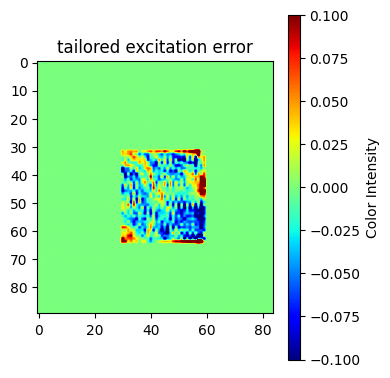

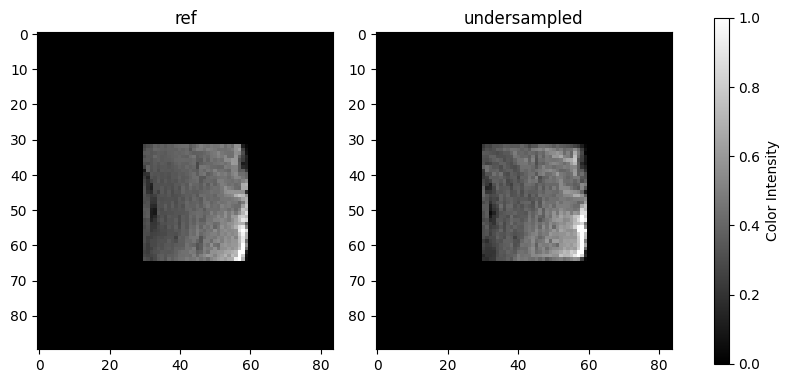

In [31]:
roi=torch.zeros_like(I_mb1on)
roi[30:60,32:65,30:60]=1
#roi=torch.ones_like(I_mb1on)
img1=torch.abs(I_mb1off*roi)
#img1_norm=(img1-img1.min())/(img1.quantile(0.99)-img1.min())
img1_norm=img1
img2=torch.abs(I_mb12on*roi)
#img2_norm=(img2-img2.min())/(img2.quantile(0.99)-img2.min())
scale=torch.sum(torch.conj(img2)*img1)/torch.sum(torch.conj(img2)*img2)
img2_norm=img2*scale

err1=img1_norm-img2_norm

errormap_cmp([err1[45,...].cpu()],['tailored excitation error'],[-0.1,0.1])

#look at the masked raw images
errormap_cmp([img1_norm[45,...].cpu(),img2_norm[45,...].cpu()],['ref','undersampled'],[0,1],cmap='gray')


Now let's see the error of uniform EXT case

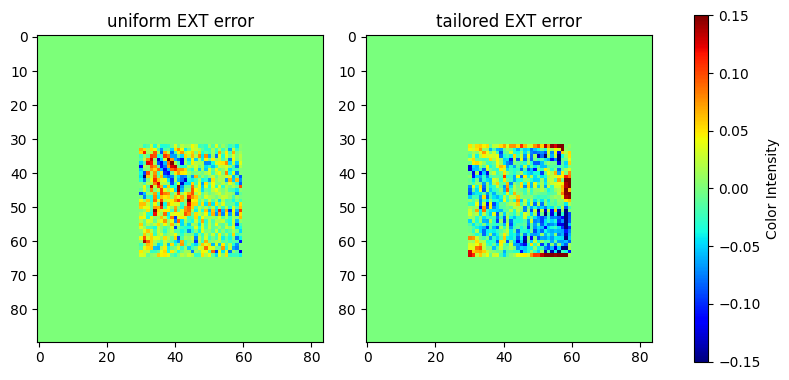

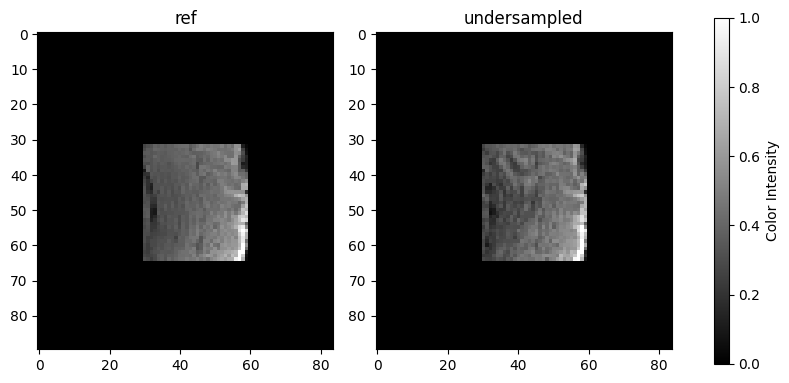

In [32]:
# roi=torch.zeros_like(I_mb1off)
# roi[30:60,30:60,22:58]=1
img1=torch.abs(I_mb1off*roi)
#img1_norm=(img1-img1.min())/(img1.quantile(0.99)-img1.min())
img1_norm=img1
img2=torch.abs(I_mb12off*roi)
#img2_norm=(img2-img2.min())/(img2.quantile(0.99)-img2.min())
scale=torch.sum(torch.conj(img2)*img1)/torch.sum(torch.conj(img2)*img2)
img2_norm=img2*scale

err2=img1_norm-img2_norm

errormap_cmp([err2[45,...].cpu(),err1[45,...].cpu()],['uniform EXT error','tailored EXT error'],[-0.15,0.15])

#look at the masked raw images
errormap_cmp([img1_norm[45,...].cpu(),img2_norm[45,...].cpu()],['ref','undersampled'],[0,1],cmap='gray')


Let's calculate the PSNR of both cases

In [33]:
#psnr
psnr_hp=PSNR(torch.abs(I_mb1off*roi),torch.abs(I_mb12off*roi),roi,norm='least-dist')
psnr_tRF=PSNR(torch.abs(I_mb1off*roi),torch.abs(I_mb12on*roi),roi,norm='least-dist')
print(f'PSNR of hard-pulse:{psnr_hp}\nPSNR of tRF:{psnr_tRF}')

PSNR of hard-pulse:(29.996514669630407+0j)
PSNR of tRF:(26.255671513358966+0j)


In [21]:
#normalization I_mb1w_recon
roi=torch.zeros_like(weight)
roi[32:58,32:58,32:58]=1
Irecon3=I_mb1w_recon*roi
Iopt_norm=(torch.abs(Irecon3)-torch.abs(Irecon3).min())/(torch.abs(Irecon3).quantile(0.99)-torch.abs(Irecon3).min())

In [22]:
#normalization I_mb12off
Irecon3=I_mb12off*roi
I_mb12off_norm=(torch.abs(Irecon3)-torch.abs(Irecon3).min())/(torch.abs(Irecon3).quantile(0.99)-torch.abs(Irecon3).min())

In [23]:
#normalization I_mb1
Irecon3=I_mb1*roi
I_mb1_norm=(torch.abs(Irecon3)-torch.abs(Irecon3).min())/(torch.abs(Irecon3).quantile(0.99)-torch.abs(Irecon3).min())

In [18]:
def errormap_cmp(images,titles,caxis,cmap='jet'):
    r''' show image1-3 in same colorbar
    images: list of images to be displayed
    titles: titles for each subplot
    caxis: color limits for the shared cbar, list of 2 values
    '''
    n=len(images)
    
    # Create figure and set up gridspec for proper colorbar alignment
    fig = plt.figure(figsize=(4*n, 4))
    gs = fig.add_gridspec(1, n+1,width_ratios=[1] * n + [0.05])  # n images + 1 colorbar
    
    
    axes=[]
    imgs = []
    for i,image in enumerate(images):
        ax = fig.add_subplot(gs[0, i])
        img = ax.imshow(image, cmap=cmap, vmin=caxis[0], vmax=caxis[1])
        ax.set_title(titles[i])
       # ax.axis('off')  # Remove axis labels
        axes.append(ax)  # Store the axis
        imgs.append(img)  # Store the image

    # Add a shared colorbar
    cbar = fig.colorbar(imgs[-1], cax=fig.add_subplot(gs[0, i+1]))
    cbar.set_label("Color Intensity")

    plt.tight_layout()
    plt.show()
    return

In [25]:
#sagittal slice
I_optsl=Iopt_norm[45,:,:].cpu().numpy()
I_mb12offsl=I_mb12off_norm[45,:,:].cpu().numpy()
I_mb1sl=I_mb1_norm[45,:,:].cpu().numpy()

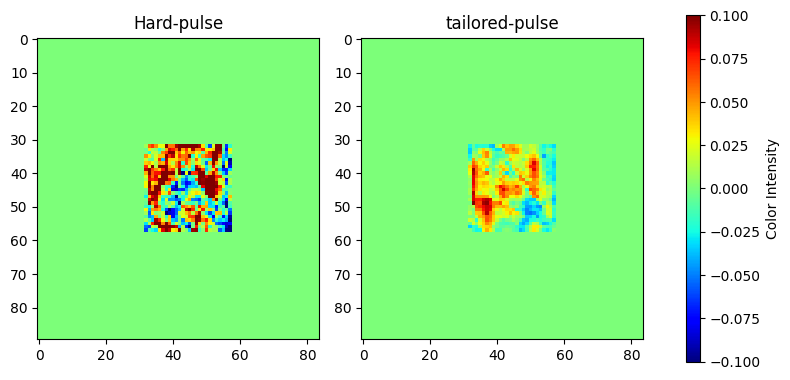

In [26]:
image1,image2=[I_mb1sl-I_mb12offsl,I_mb1sl-I_optsl]
errormap_cmp([image1,image2],['Hard-pulse','tailored-pulse'],[-0.1,0.1])

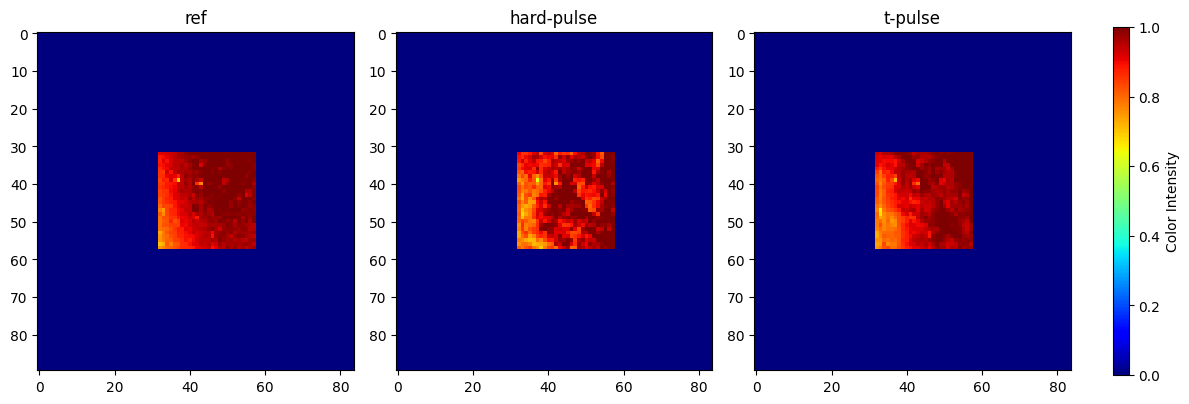

In [27]:
errormap_cmp([I_mb1sl,I_mb12offsl,I_optsl],['ref','hard-pulse','t-pulse'],[0,1])

tensor(0.0012, device='cuda:0', dtype=torch.float64)
tensor(1295624.7165, device='cuda:0', dtype=torch.float64)


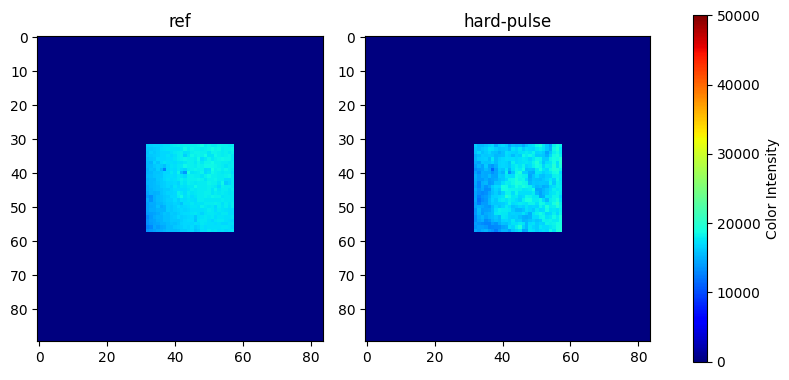

In [28]:
# scale img2 such that l2-norm of ||img2-img1|| is minimal
img1=torch.abs(I_mb1*roi)
img2=torch.abs(I_mb12off*roi)
scale=torch.sum(torch.conj(img2)*img1)/torch.sum(torch.conj(img2)*img2)
print(scale)
img2=img2*scale
mse1=MSE(img1,img2,roi,norm='None')
print(mse1)
errormap_cmp([torch.abs(img1[45,...].cpu()),torch.abs(img2[45,...].cpu())],['ref','hard-pulse'],[0,0.5e5])

In [31]:
#psnr
psnr_hp=PSNR(torch.abs(I_mb1*roi),torch.abs(I_mb12off*roi),roi,norm='least-dist')
psnr_tRF=PSNR(torch.abs(I_mb1w*roi),torch.abs(I_mb1w_recon*roi),roi,norm='least-dist')
print(f'PSNR of hard-pulse:{psnr_hp}\nPSNR of tRF:{psnr_tRF}')

PSNR of hard-pulse:25.368630572088012
PSNR of tRF:34.7832577720833


## 20241028-Data

In [55]:
###################### Ground Truth Image ######################
data=scipy.io.loadmat('./4greatlakes-PHANTOM-20241028.mat')
smap=torch.tensor(data['smap']).to(device0).permute(3,0,1,2)
print(data.keys())
I_mb1off=torch.tensor(data['I_mb1off']).to(device0) #(nx,ny,nz)
d_mb12off=torch.tensor(data['d_mb12off']).to(device0).permute(3,0,1,2) #(nc,nx,ny,nz)
d_mb1off=torch.tensor(data['d_mb1off']).to(device0).permute(3,0,1,2)

[nc,nx,ny,nz]=smap.shape

sample_mask=torch.tensor(data['maskpky']).repeat(nx,1,1).to(device0)
Sop=Sense(smap.unsqueeze(0),sample_mask.unsqueeze(0))


Iunder=Sop.H*d_mb12off.unsqueeze(0)

I = Identity((1,1,)+sample_mask.shape)
CG_solver = CG(Sop.H*Sop+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
I_mb12off = CG_solver.run(Iunder,Iunder) 
I_mb12off=I_mb12off.squeeze(0).squeeze(0)#(nx,ny,nz)


dict_keys(['__header__', '__version__', '__globals__', 'I_mb12off', 'I_mb12rtr', 'I_mb12rtr_noisy', 'I_mb1off', 'I_mb1off_bart', 'd_mb12off', 'd_mb12on', 'd_mb12rtr', 'd_mb12rtr_noisy', 'd_mb1off', 'maskpky', 'smap', 'synnoise'])


compare fully-sampled images with 12-fold under-sampled images, __w/o__ tRF

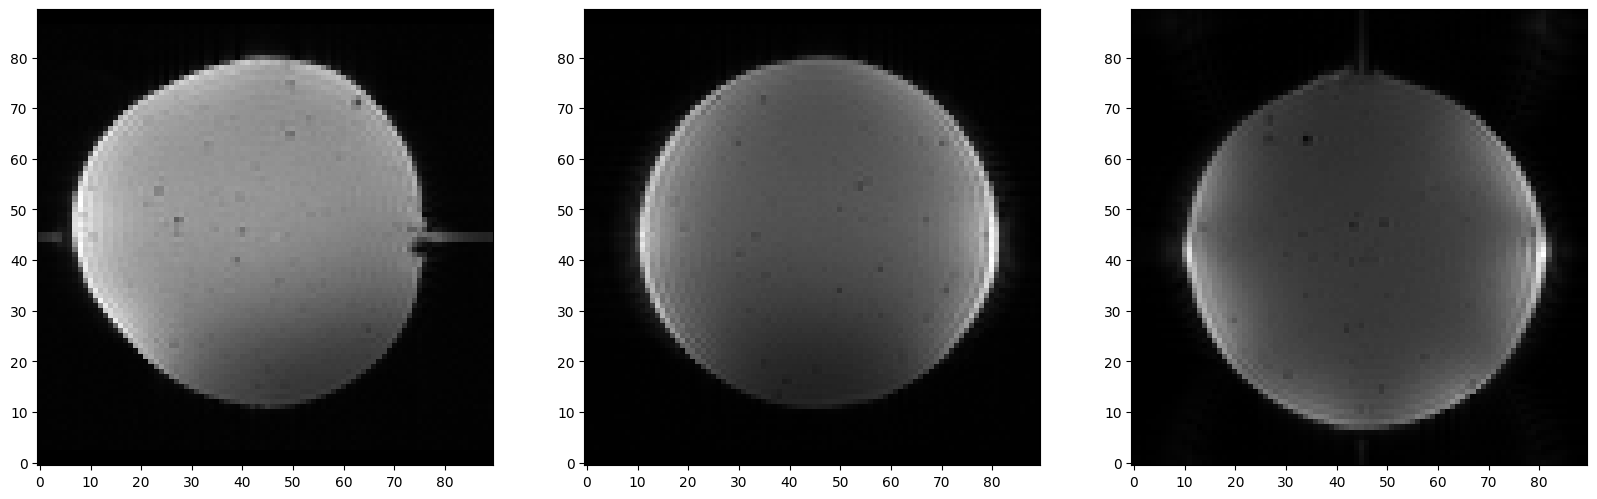

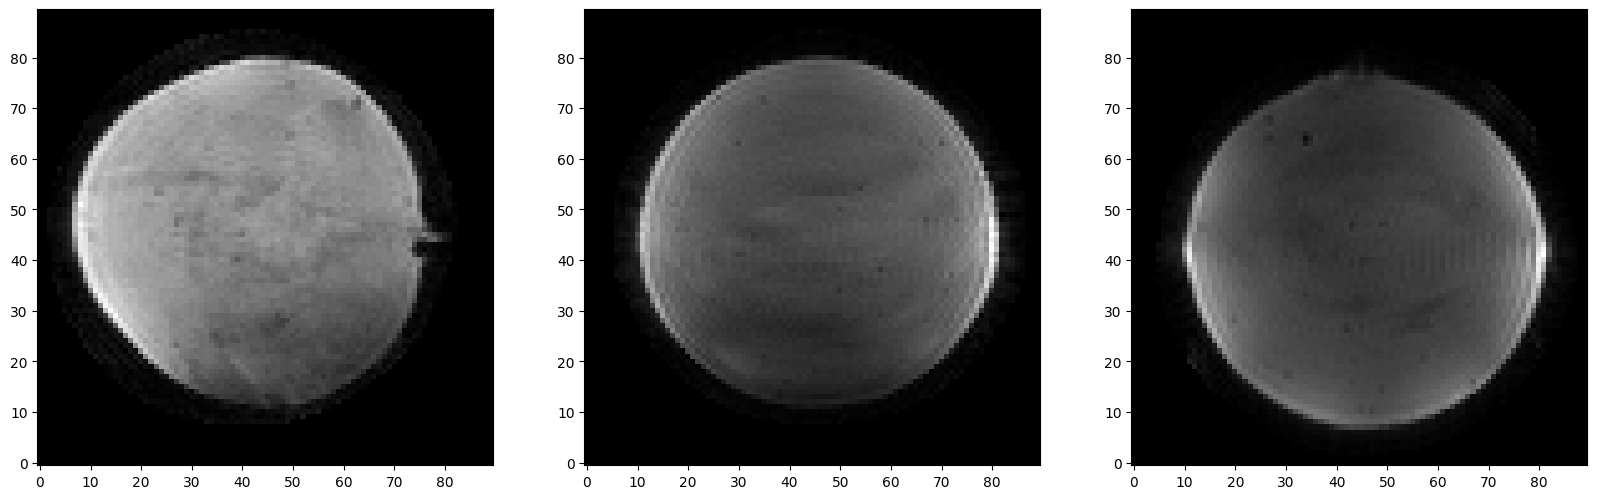

In [56]:
SACshow(abs(I_mb1off))
SACshow(abs(I_mb12off))

We can see substantial aliasing artifacts in the above figure. Now let's try to emulate the effect of tRF by give fully-sampled (FS) images some spatial weighting, where only a box-shape inner-volume (IV) has strong signals. Then we simulate the k-space corresponding to the weighted images and retrospectively undersampled the k-space. Finally we reconstruct the images with the retrospetively under-sampled data and compare the undersampled images with weighted fully-sampled images.

But even before that, we need to examine an assumption: the retrospectively under-sampled data can serve as a surrogate for the prospectively under-sampled ones. Let's see how good this approximation is

In [57]:
#retrospetively undersampled k-data
d_mb12rtr=torch.tensor(data['d_mb12rtr']).to(device0).permute(3,0,1,2) #(nc,nx,ny,nz)
Iunder=Sop.H*d_mb12rtr.unsqueeze(0)
I_mb12rtr = CG_solver.run(Iunder,Iunder) 
I_mb12rtr=I_mb12rtr.squeeze(0).squeeze(0)#(nx,ny,nz)


Let's see how close they are

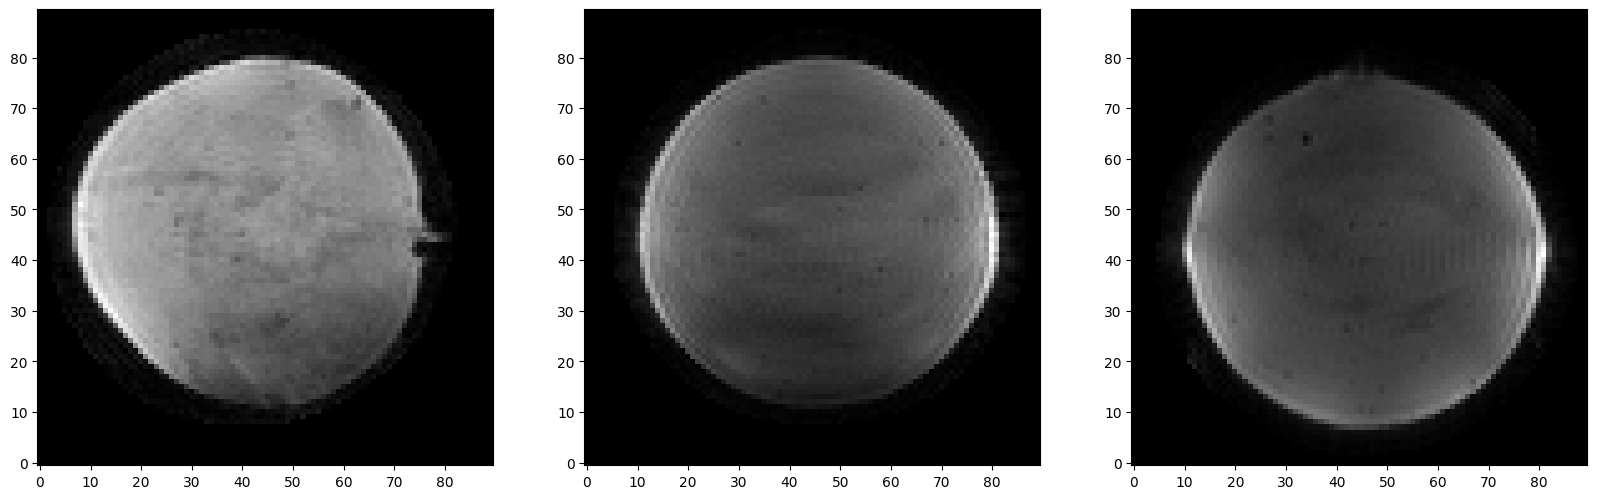

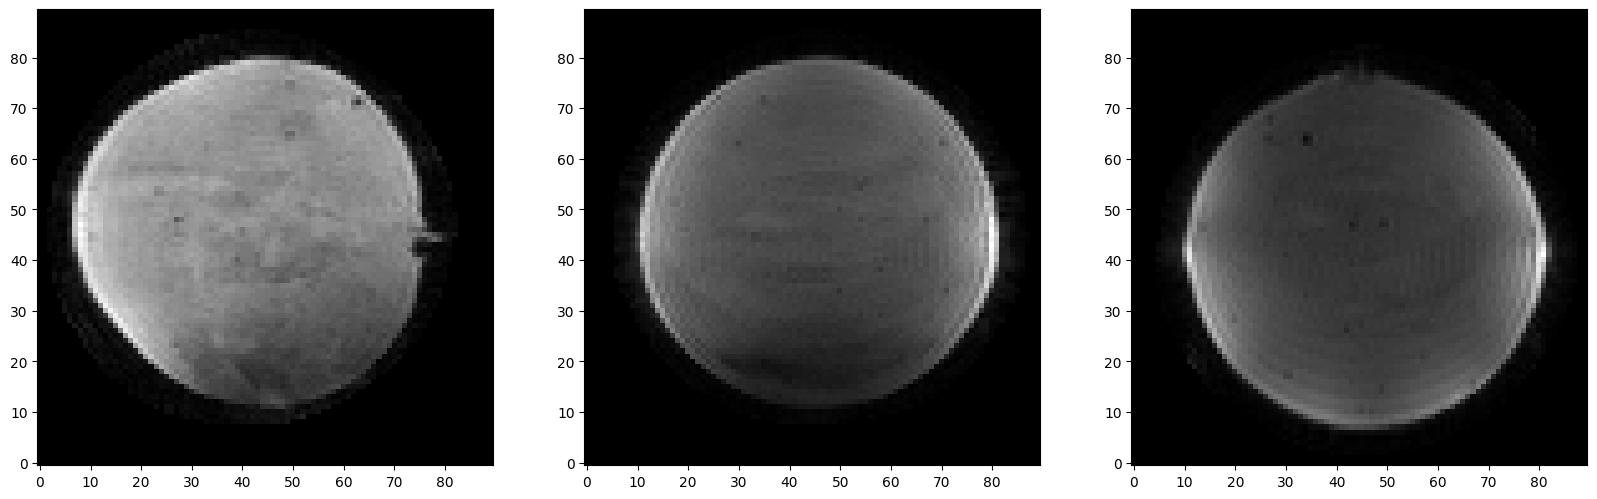

In [58]:
SACshow(abs(I_mb12off)) #prospective
SACshow(abs(I_mb12rtr)) #retrospective

We can see that they are very close. Now let's put a IV-weighting to the FS images

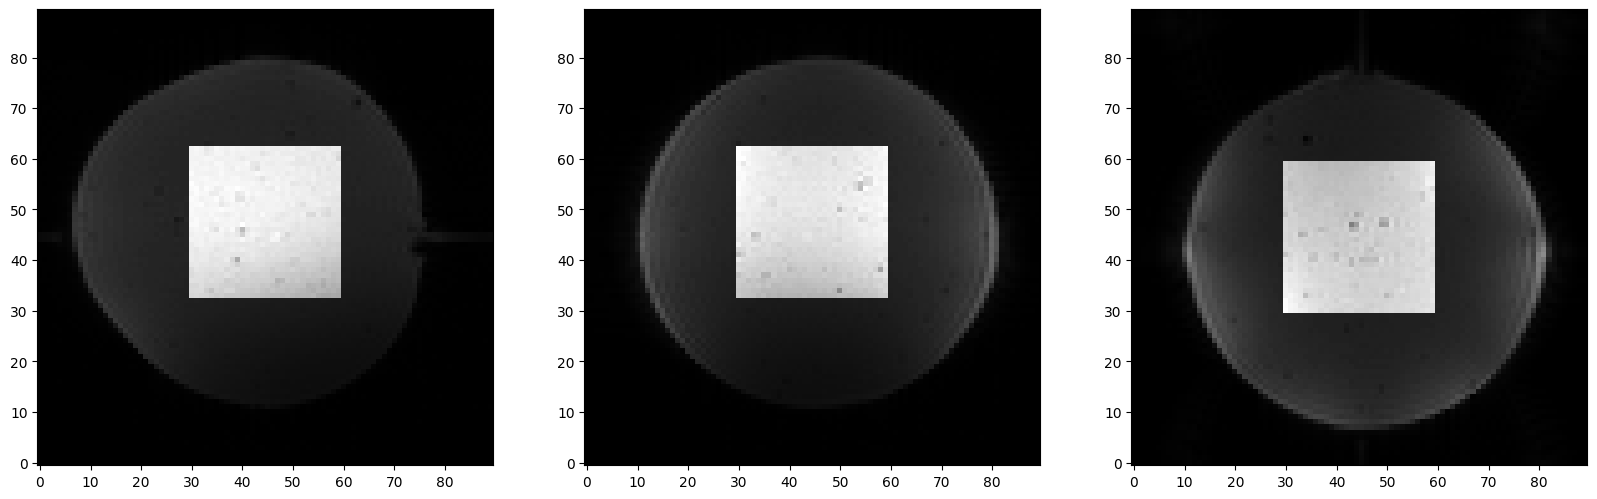

In [67]:
w=torch.ones_like(I_mb1off)*0.15
w[30:60,30:60,30:60]=1

I_mb1w=w*abs(I_mb1off)
SACshow(I_mb1w)

Now, let's retrospectively under-sampled the weighted FS images

In [60]:
kunder=Sop*I_mb1w.unsqueeze(0).unsqueeze(0) #[nbatch,1,*nM]
Iunder=Sop.H*kunder

I_mb1w_rtr = CG_solver.run(Iunder,Iunder) 
I_mb1w_rtr=I_mb1w_rtr.squeeze(0).squeeze(0)#(nx,ny,nz) retrospectively undersampled

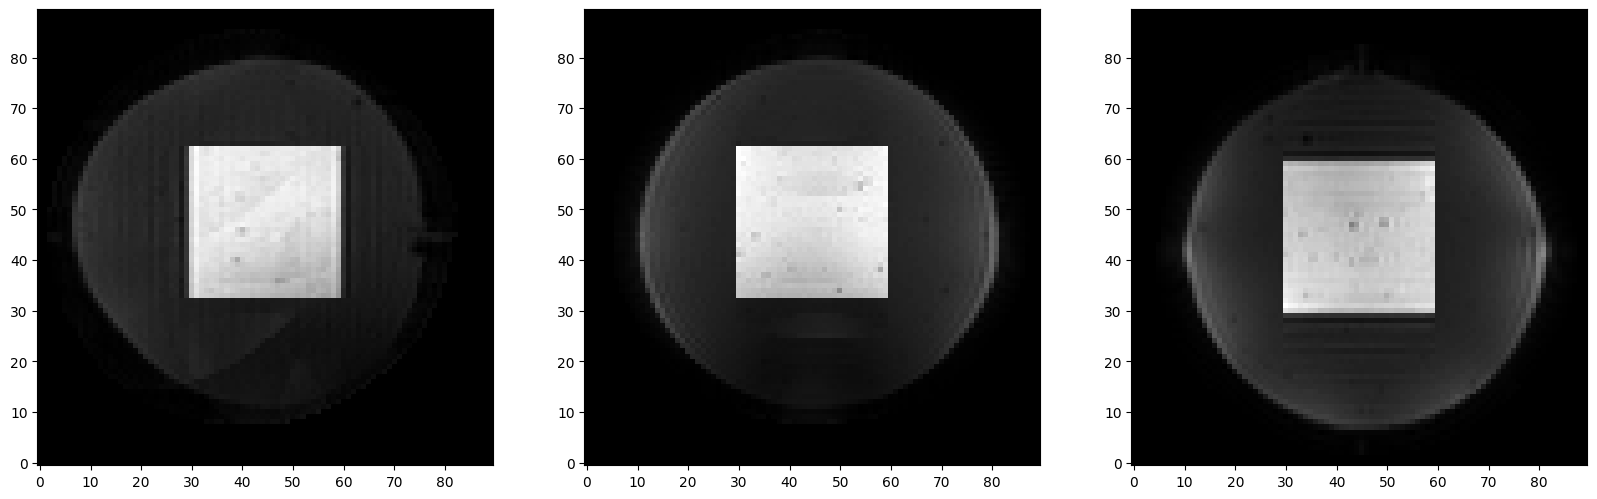

In [61]:
SACshow(abs(I_mb1w_rtr))

Let's first look at the error map of uniform excitation case.

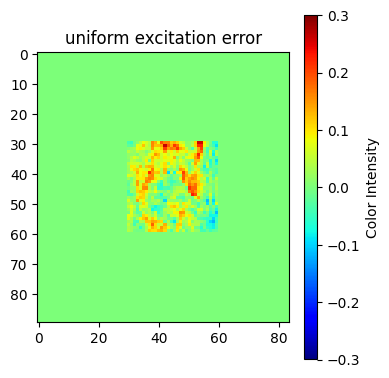

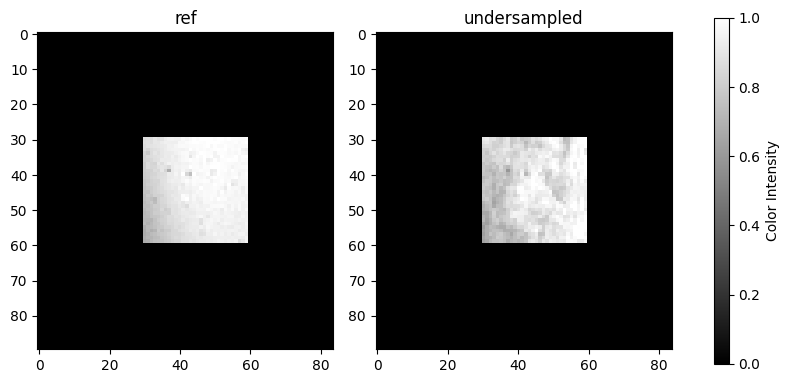

In [76]:
roi=torch.zeros_like(I_mb1off)
roi[30:60,30:60,30:60]=1
img1=torch.abs(I_mb1off*roi)
img1_norm=(img1-img1.min())/(img1.quantile(0.99)-img1.min())
img2=torch.abs(I_mb12off*roi)
img2_norm=(img2-img2.min())/(img2.quantile(0.99)-img2.min())
err1=img1_norm-img2_norm

errormap_cmp([err1[45,...].cpu()],['uniform excitation error'],[-0.3,0.3])

#look at the masked raw images
errormap_cmp([img1_norm[45,...].cpu(),img2_norm[45,...].cpu()],['ref','undersampled'],[0,1],cmap='gray')

Then we look at error map of tRF case

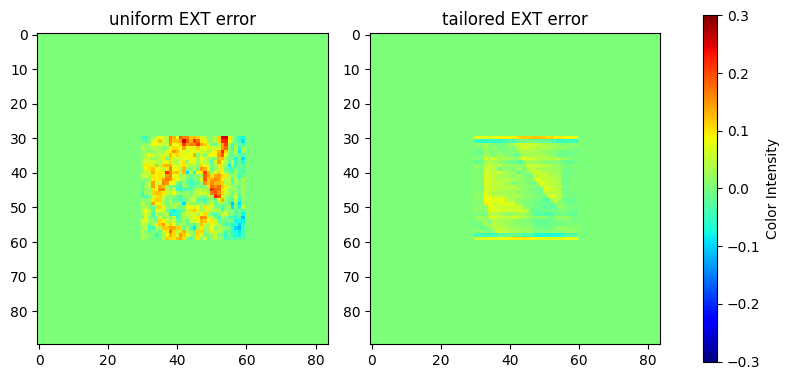

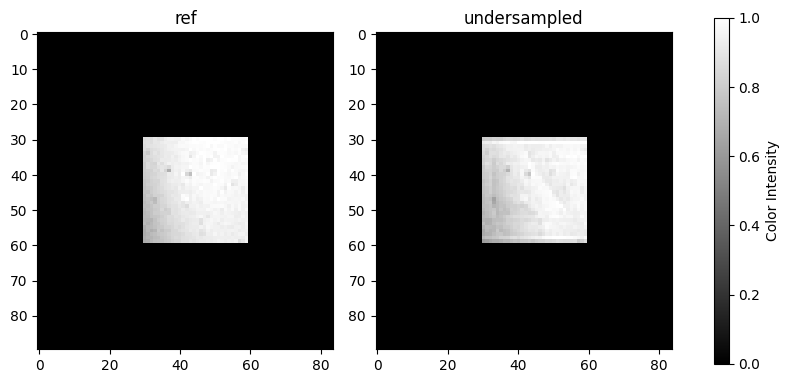

In [77]:
img1=torch.abs(I_mb1w*roi)
img1_norm=(img1-img1.min())/(img1.quantile(0.99)-img1.min())
img2=torch.abs(I_mb1w_rtr*roi)
img2_norm=(img2-img2.min())/(img2.quantile(0.99)-img2.min())
err2=img1_norm-img2_norm

errormap_cmp([err1[45,...].cpu(),err2[45,...].cpu()],['uniform EXT error','tailored EXT error'],[-0.3,0.3])
errormap_cmp([img1_norm[45,...].cpu(),img2_norm[45,...].cpu()],['ref','undersampled'],[0,1],cmap='gray')

Let's calculate PSNR of each case

In [70]:
#psnr
psnr_hp=PSNR(torch.abs(I_mb1off*roi),torch.abs(I_mb12off*roi),roi,norm='least-dist')
psnr_tRF=PSNR(torch.abs(I_mb1w*roi),torch.abs(I_mb1w_rtr*roi),roi,norm='least-dist')
print(f'PSNR of hard-pulse:{psnr_hp}\nPSNR of tRF:{psnr_tRF}')

PSNR of hard-pulse:26.055497660593897
PSNR of tRF:32.02390916256671


### 3D-GRE Data

Let's look at 3d-gre data

In [51]:
data=scipy.io.loadmat('./4greatlakes_3dgre_data.mat')
smap=torch.tensor(data['smap']).to(device0).permute(3,0,1,2)
#print(data.keys())
I_mb1off=torch.tensor(data['I_mb1off']).to(device0).flip([1]) #(nx,ny,nz)
I_mb1on=torch.tensor(data['I_mb1on']).to(device0).flip([1]) #(nx,ny,nz)

[nc,nx,ny,nz]=smap.shape


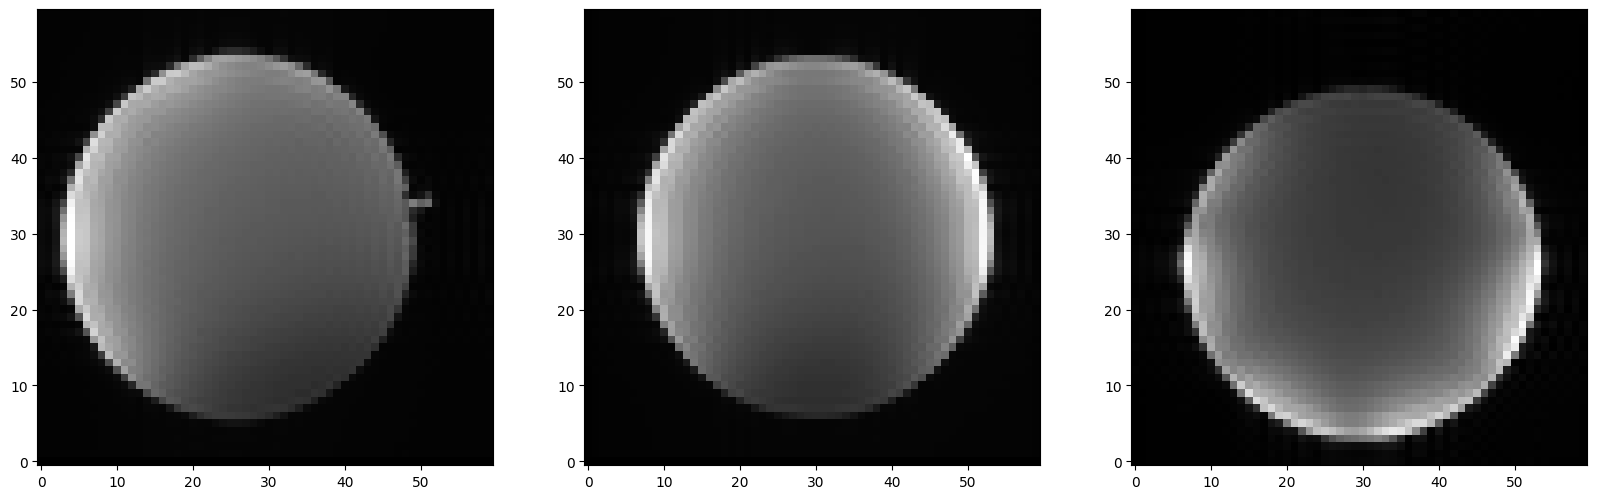

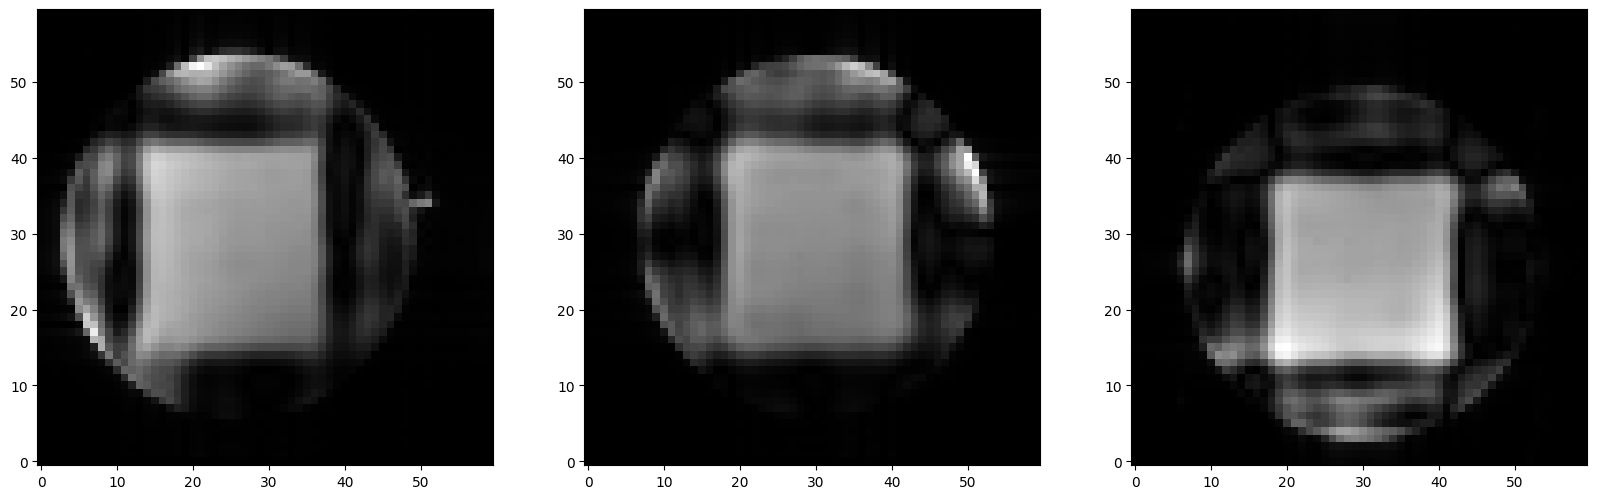

In [52]:
SACshow(abs(I_mb1off))
SACshow(abs(I_mb1on)) 

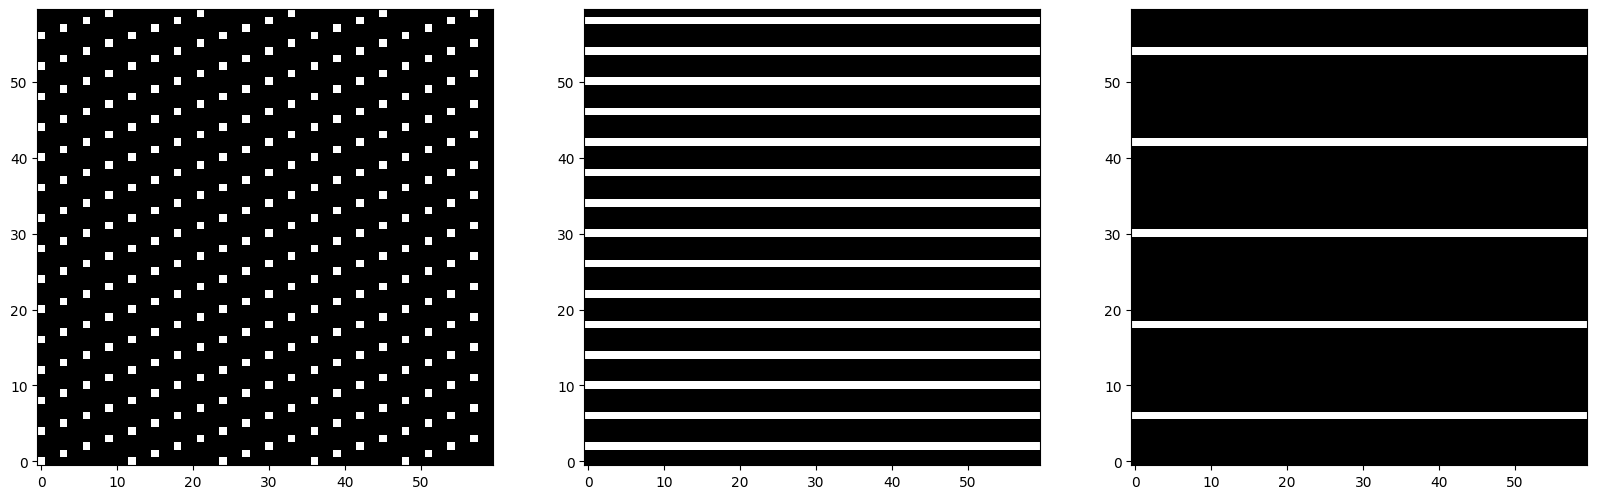

In [63]:
etl=torch.zeros(12,ny).to(device0)
etl[0,::4]=1
etl[3,1::4]=1
etl[6,2::4]=1
etl[9,3::4]=1

kyz=etl.repeat(nz//12,1)
kyz=torch.cat((kyz,etl[:nz-kyz.shape[0],:]),dim=0)
# plt.imshow(kyz)
# plt.show()

caipi_mask=kyz.unsqueeze(0).repeat(nx,1,1)
caipi_mask.shape
SACshow(caipi_mask)

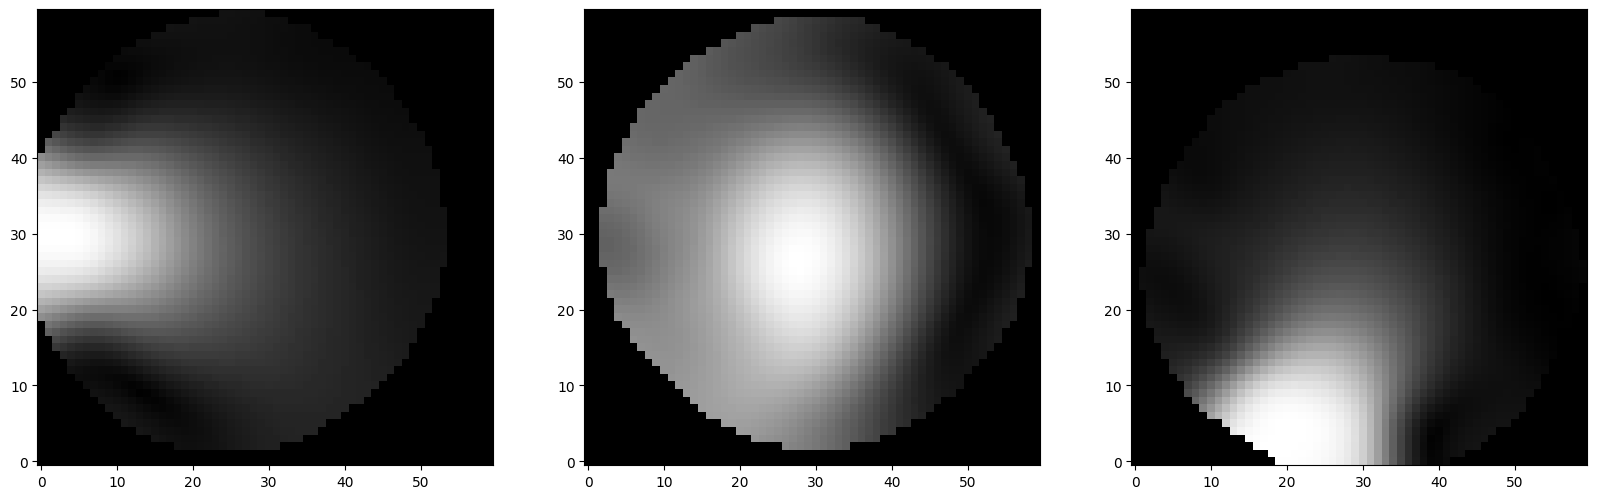

In [64]:
SACshow(abs(smap[10,...]))

In [65]:
Sop=Sense(smap.unsqueeze(0),caipi_mask.unsqueeze(0))

kunder=Sop*I_mb1off.unsqueeze(0).unsqueeze(0) #[nbatch,1,*nM]
Iunder=Sop.H*kunder

I = Identity((1,1,)+caipi_mask.shape)
CG_solver = CG(Sop.H*Sop+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
I_mb12off = CG_solver.run(Iunder,Iunder)
I_mb12off=I_mb12off.squeeze(0).squeeze(0)

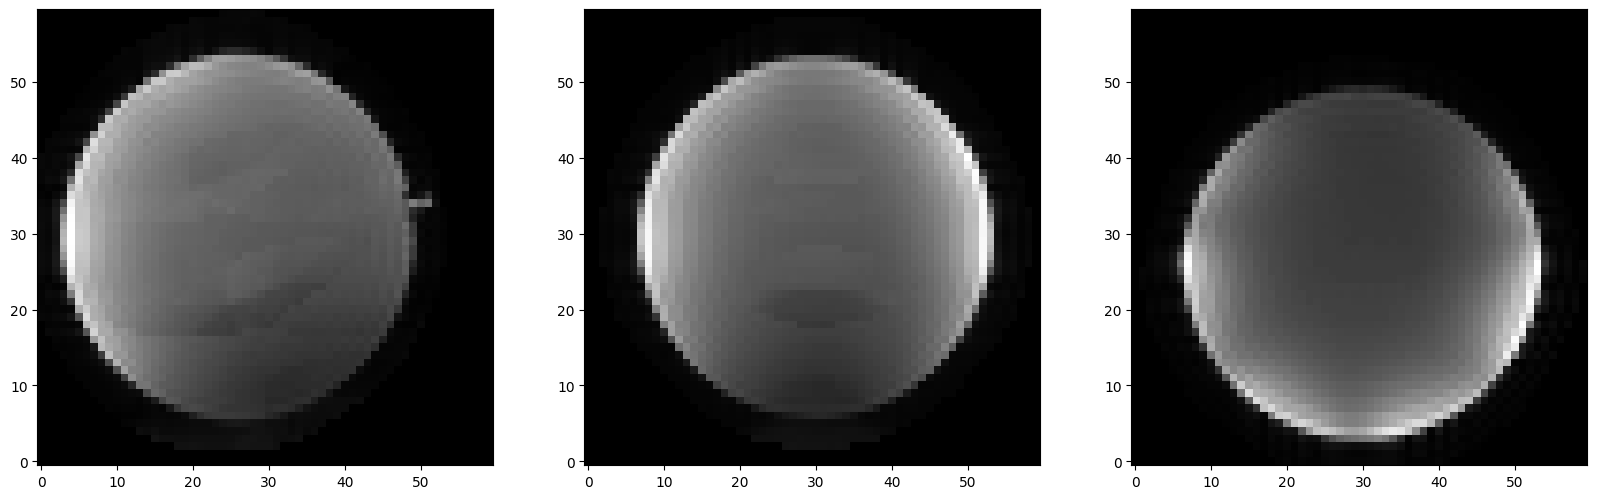

In [66]:
SACshow(abs(I_mb12off))

Retrospectively undersample tEXT case

In [67]:
kunder=Sop*I_mb1on.unsqueeze(0).unsqueeze(0) #[nbatch,1,*nM]
Iunder=Sop.H*kunder

I = Identity((1,1,)+caipi_mask.shape)
CG_solver = CG(Sop.H*Sop+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
I_mb12on = CG_solver.run(Iunder,Iunder)
I_mb12on=I_mb12on.squeeze(0).squeeze(0)

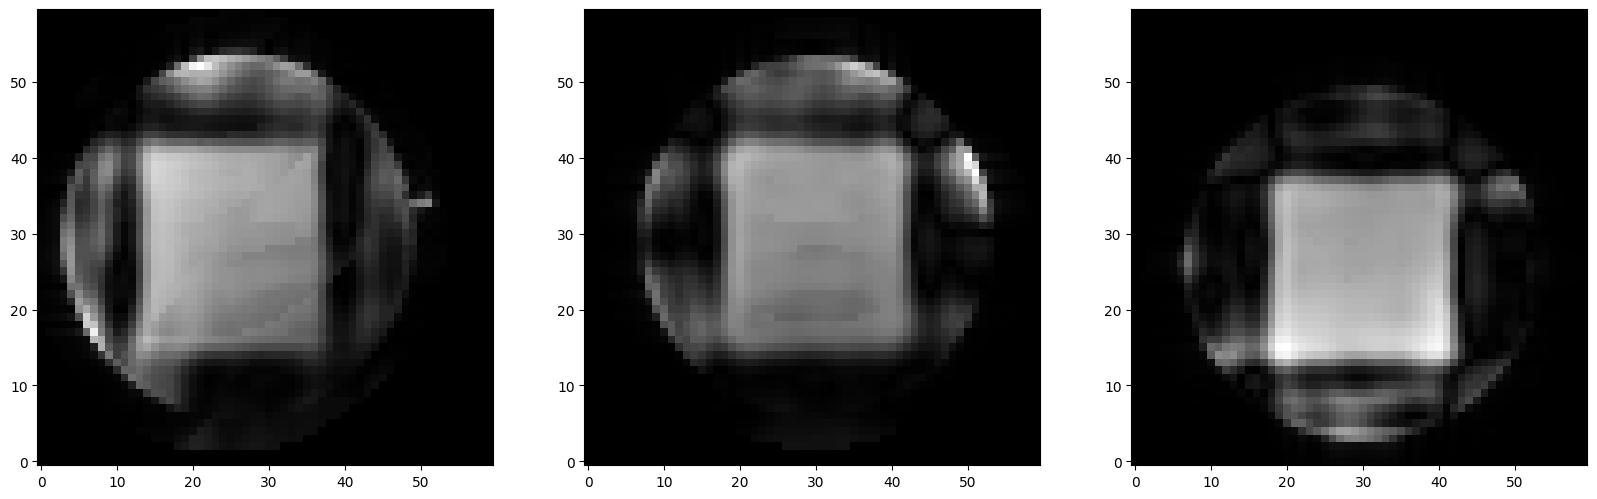

In [68]:
SACshow(abs(I_mb12on))

Let's look at the error of uniform excitation

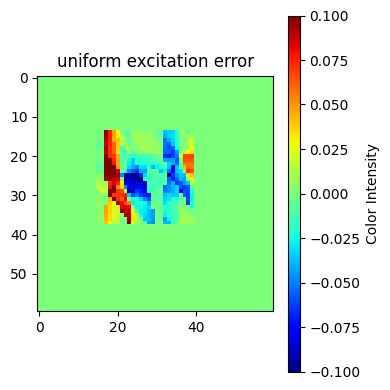

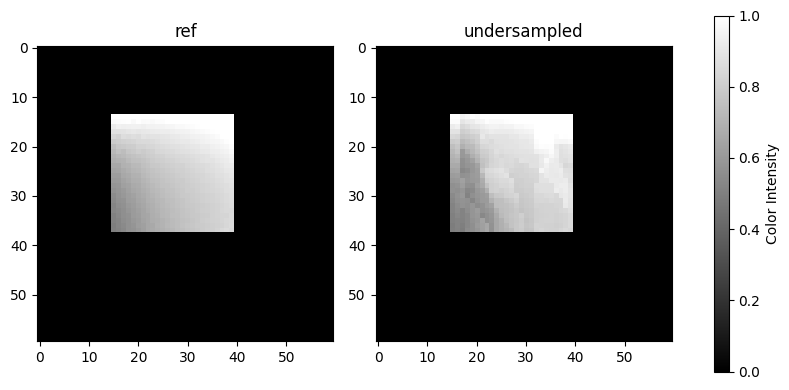

In [73]:
roi=torch.zeros_like(I_mb1off)
roi[20:40,14:38,15:40]=1
#roi=torch.ones_like(I_mb1off)
img1=torch.abs(I_mb1off*roi)
img1_norm=(img1-img1.min())/(img1.quantile(0.99)-img1.min())
img2=torch.abs(I_mb12off*roi)
img2_norm=(img2-img2.min())/(img2.quantile(0.99)-img2.min())
err1=img1_norm-img2_norm

errormap_cmp([err1[30,...].cpu()],['uniform excitation error'],[-0.1,0.1])

#look at the masked raw images
errormap_cmp([img1_norm[30,...].cpu(),img2_norm[30,...].cpu()],['ref','undersampled'],[0,1],cmap='gray')

Let's look at the error of tEXT case

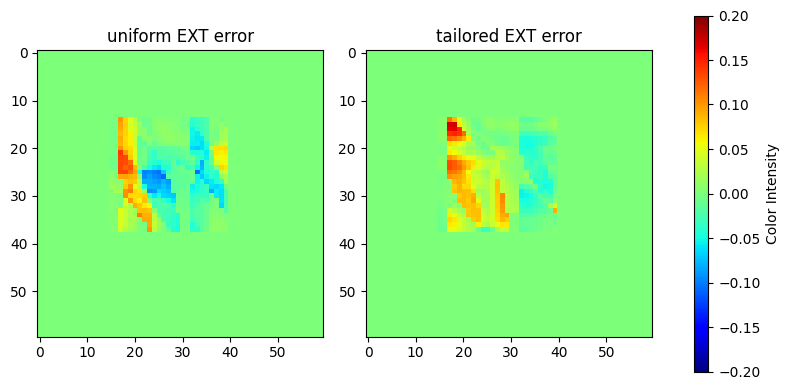

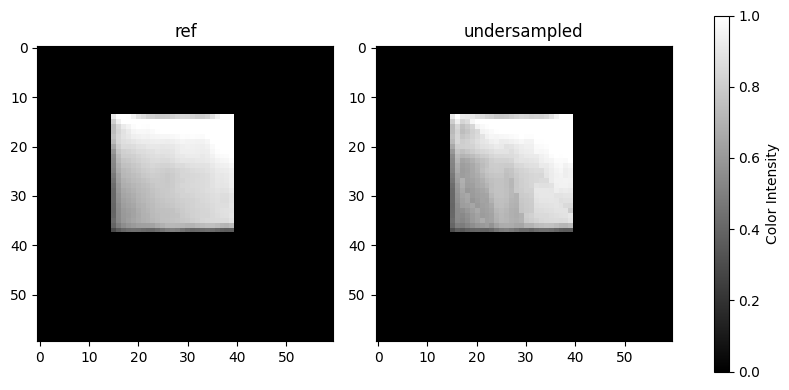

In [75]:
img1=torch.abs(I_mb1on*roi)
img1_norm=(img1-img1.min())/(img1.quantile(0.99)-img1.min())
img2=torch.abs(I_mb12on*roi)
img2_norm=(img2-img2.min())/(img2.quantile(0.99)-img2.min())
err2=img1_norm-img2_norm

errormap_cmp([err1[30,...].cpu(),err2[30,...].cpu()],['uniform EXT error','tailored EXT error'],[-0.2,0.2])
errormap_cmp([img1_norm[30,...].cpu(),img2_norm[30,...].cpu()],['ref','undersampled'],[0,1],cmap='gray')

Let's compare PSNR of both cases

In [76]:
#psnr
roi=torch.zeros_like(I_mb1off)
roi[20:40,14:38,15:40]=1
psnr_hp=PSNR(torch.abs(I_mb1off*roi),torch.abs(I_mb12off*roi),roi,norm='least-dist')
psnr_tRF=PSNR(torch.abs(I_mb1on*roi),torch.abs(I_mb12on*roi),roi,norm='least-dist')
print(f'PSNR of hard-pulse:{psnr_hp}\nPSNR of tRF:{psnr_tRF}')

PSNR of hard-pulse:32.51143570697968
PSNR of tRF:33.427762369247944


Resume training

In [27]:
pIni_path='./pIni-from-ROITrained.npz'
model=End2EndModel(tissue_path,pIni_path,sampling_pattern,iv,checkpoint_savepth='./checkpoint/jonhead_caipi4by3-TR80ms/',noise_level=10e-4)
model.load_network('./checkpoint/jonhead_caipi4by3-TR80ms/iter_2_checkpoint.pth')

niter=2
n_rf=2
n_gr=2
[opt_pulse,optInfos]=model.optimize_parameters(niter,n_rf,n_gr,iter_start=2,doSave=True)

/tmp/ipykernel_1955454/270914935.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)


Checkpoint loaded from: ./checkpoint/jonhead_caipi4by3-TR80ms/iter_2_checkpoint.pth
====== Initial loss:-31.633136749267578

#iter	 ‖ elapsed time	 ‖ error	 ‖ total loss	 ‖ avg loss
rf-loop 2
3	 | 99.819	 | -3.182e+01	 | -3.182e+01	 | -1.159e-02
3	 | 189.024	 | -3.171e+01	 | -3.171e+01	 | -1.156e-02
gr-loop 2
3	 | 227.261	 | -3.187e+01	 | -3.187e+01	 | -1.162e-02
3	 | 259.030	 | -3.176e+01	 | -3.176e+01	 | -1.158e-02
Checkpoint saved at: ./checkpoint/jonhead_caipi4by3-TR80ms/iter_3_checkpoint.pth
rf-loop 2
4	 | 297.295	 | -3.197e+01	 | -3.197e+01	 | -1.165e-02
4	 | 405.744	 | -3.128e+01	 | -3.128e+01	 | -1.140e-02
gr-loop 2
4	 | 450.269	 | -3.203e+01	 | -3.203e+01	 | -1.167e-02
4	 | 520.448	 | -3.195e+01	 | -3.195e+01	 | -1.164e-02
Checkpoint saved at: ./checkpoint/jonhead_caipi4by3-TR80ms/iter_4_checkpoint.pth

====== Results: ======

#iter	 ‖ elapsed time	 ‖ error	 ‖ total loss	 ‖ avg loss
4	 | 520.481	 | -3.195e+01	 | -3.195e+01	 | -1.164e-02


## Design ROI-GUIDE for Jon's Head

In [1]:
import nibabel as nib

In [4]:
file='/home/yonglihe/jon_scan/jon_siemems_scan_flipped_synthseg.nii.gz'
mprage_nii=nib.load(file)

mprage=mprage_nii.get_fdata()

mprage=mprage.transpose((0,2,1))
mprage=np.flip(mprage,axis=(2))

mprage.shape

(176, 256, 256)

In [5]:
import sys
sys.path.append('/home/yonglihe/github/my_utils')
from vis import SACshow

In [8]:
file2='/home/yonglihe/jon_scan/jon_siemems_scan_flipped.nii.gz'
head_nii=nib.load(file2)

head3d=head_nii.get_fdata()

head3d=head3d.transpose((0,2,1))
head3d=np.flip(head3d,axis=(2))


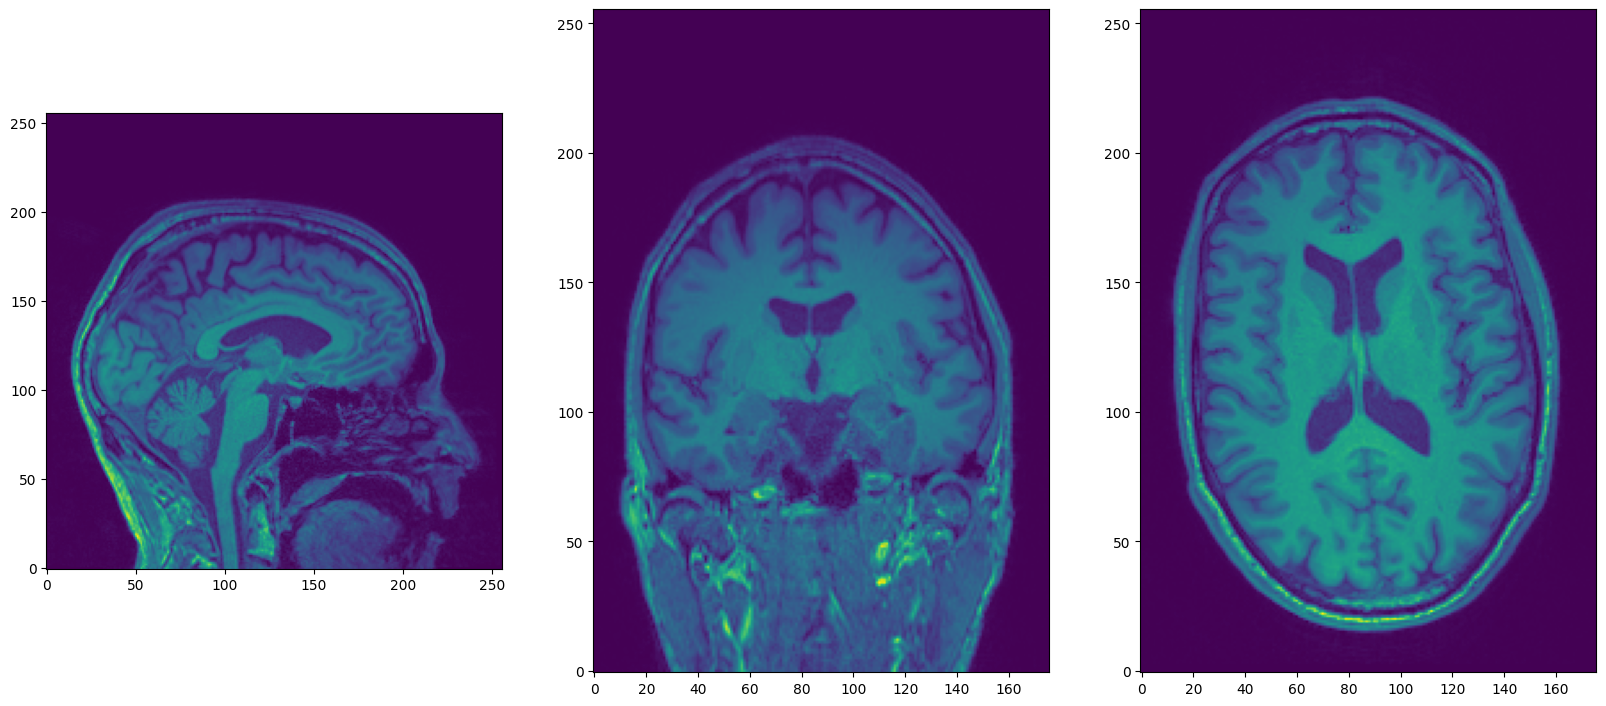

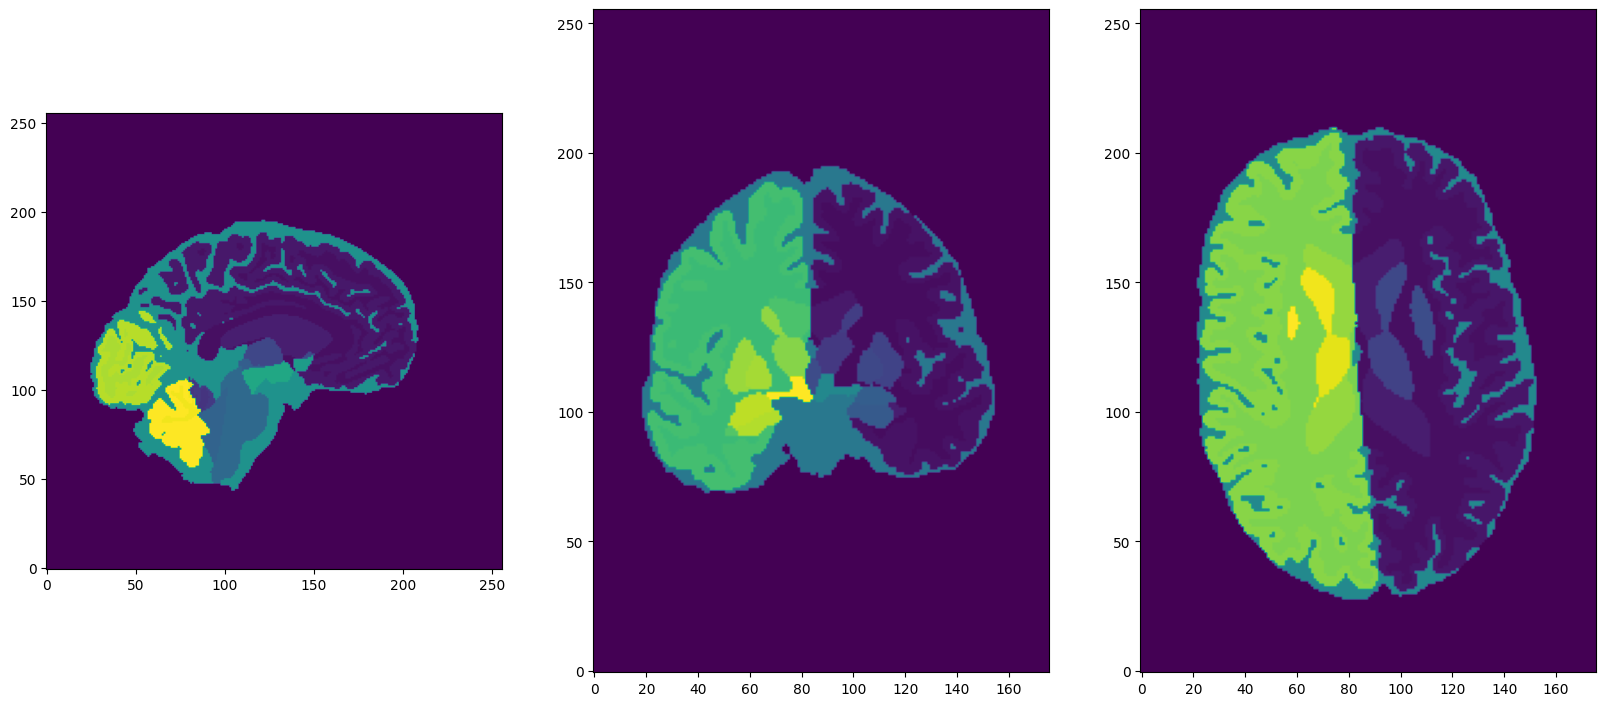

In [9]:
SACshow(head3d,pad=False,cmap='viridis')
SACshow(mprage,pad=False,cmap='viridis')

Processing: crop --> zoom --> pad --> to T1 map

In [23]:
def crop_image(array):
    r""" central crop an image array so that there's no zero padding
    Inputs:
    - ``array``: 3D numpy array (label map)
    """
    positive=np.where(array>0)
    lf=np.min(positive[0]) #left
    rg=np.max(positive[0]) #right
    po=np.min(positive[1]) #posterior
    an=np.max(positive[1]) #anterior
    inf=np.min(positive[2]) #inferior
    sup=np.max(positive[2]) #superior

    crop_array=array[lf:rg+1,po:an+1,inf:sup+1]
    return crop_array

mprage_crop=crop_image(mprage)

In [24]:
mprage_crop.shape

(143, 187, 152)

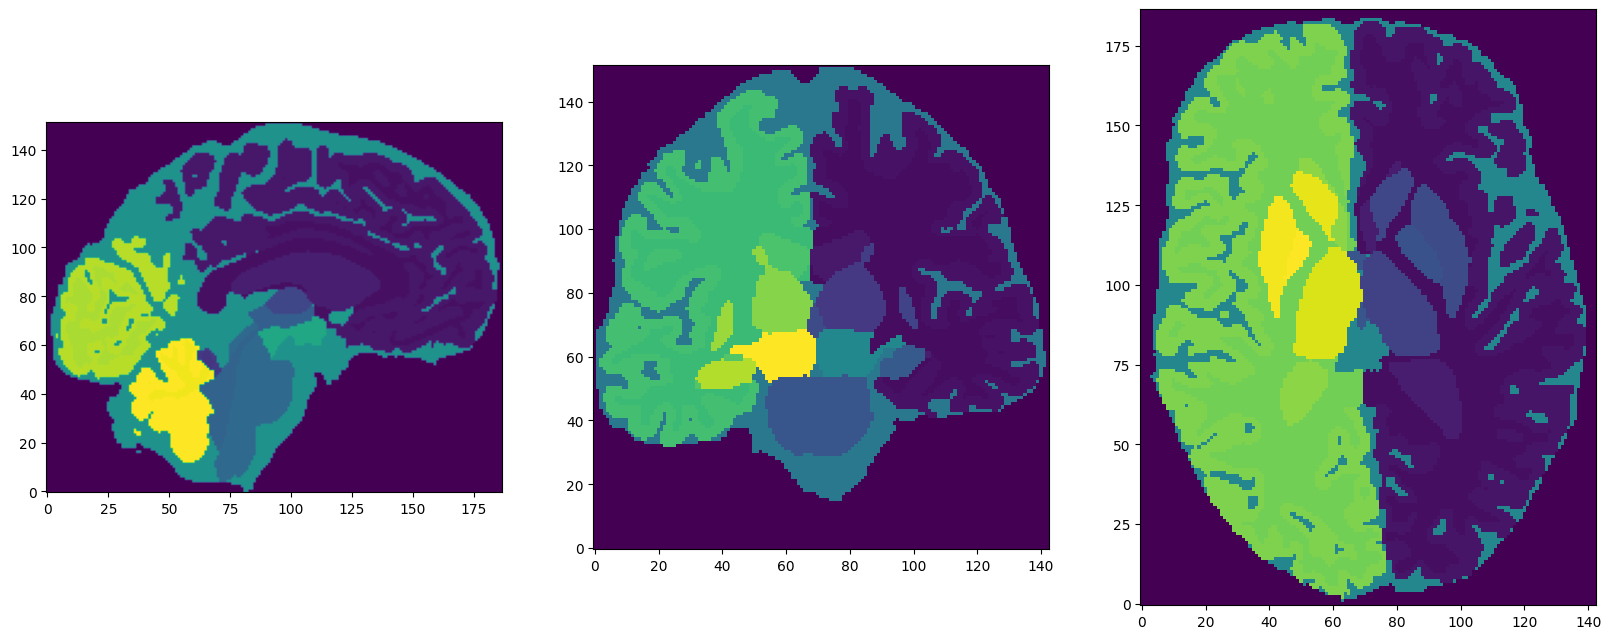

In [25]:
SACshow(mprage_crop,pad=False,cmap='viridis')

In [10]:
from scipy.ndimage import zoom
import scipy

In [27]:
zf=50/max(mprage_crop.shape)
mprage_zoom=zoom(mprage_crop,(zf,zf,zf),order=0)
mprage_zoom.shape

(38, 50, 41)

In [28]:
[bnx,bny,bnz]=mprage_zoom.shape #this is the actual size of the brain

In [29]:
def pad_image(img):
    nx,ny,nz=img.shape
    nmax=max(img.shape)
    size_diff=np.array([nmax-nx,nmax-ny,nmax-nz])

    pad1=((size_diff[0]//2,size_diff[0]//2) if size_diff[0]%2==0 else (size_diff[0]//2,size_diff[0]//2+1))
    pad2=((size_diff[1]//2,size_diff[1]//2) if size_diff[1]%2==0 else (size_diff[1]//2,size_diff[1]//2+1))
    pad3=((size_diff[2]//2,size_diff[2]//2) if size_diff[2]%2==0 else (size_diff[2]//2,size_diff[2]//2+1))
    padded_data=np.pad(img,(pad1, pad2, pad3), mode='constant', constant_values=0)
    return padded_data

mprage_pad=pad_image(mprage_zoom)
mprage_pad.shape

(50, 50, 50)

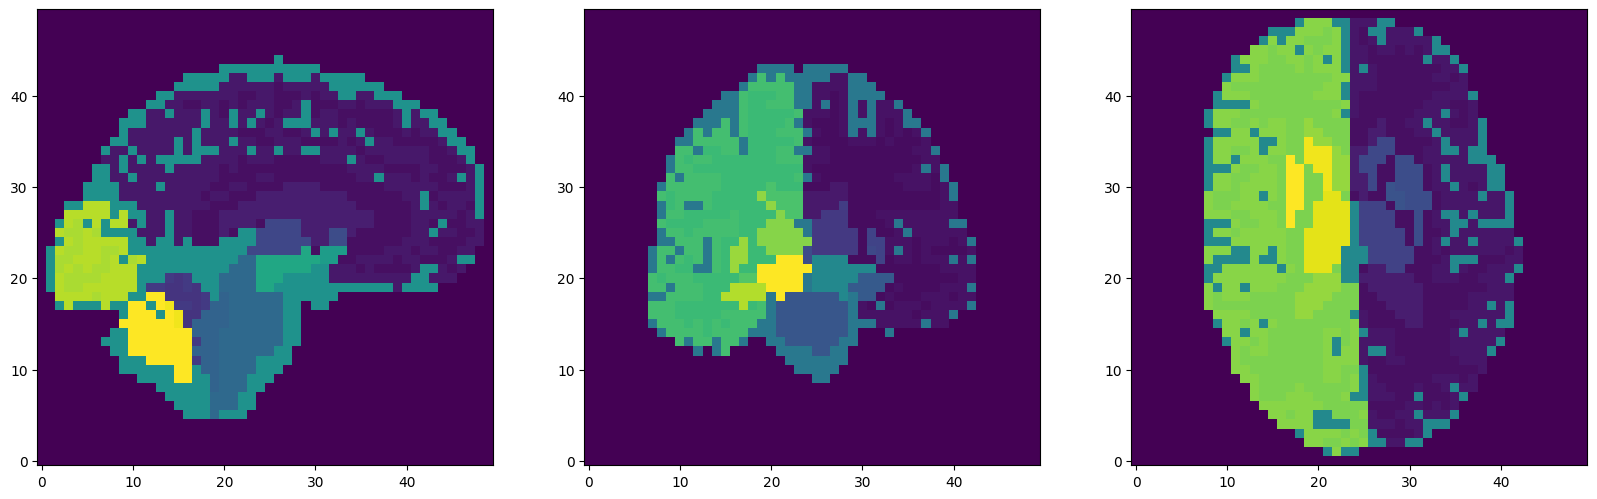

In [30]:
SACshow(mprage_pad,pad=False,cmap='viridis')

In [11]:
# smap_mat=scipy.io.loadmat('../../jon_scan/smap_jonhead.mat')
# smap=smap_mat['smap']
# smap=np.transpose(smap,(3,0,1,2))

# zoom_factor=[1]+list(np.array(mprage_pad.shape)/np.array(smap.shape[1:]))
# smap=zoom(smap,zoom_factor)
smap_mat=scipy.io.loadmat('./jonhead_smap_resized.mat')
smap=smap_mat['smap']
smap.shape

(32, 50, 50, 50)

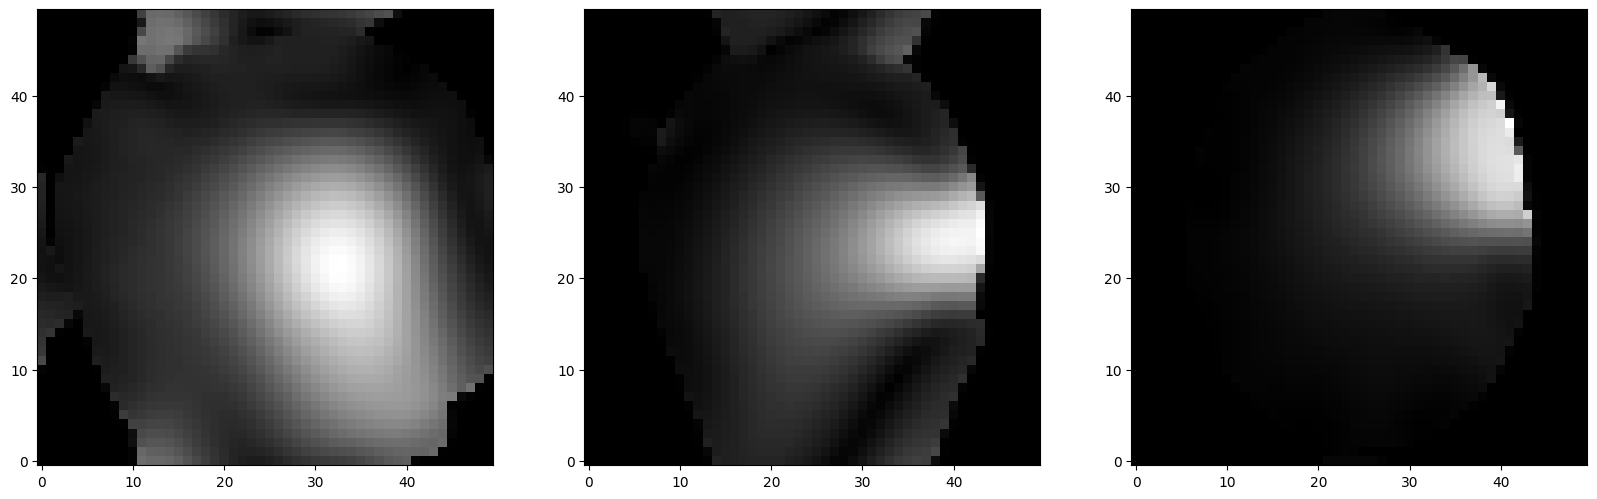

In [20]:
SACshow(np.abs(smap[30,...]))

In [33]:
scipy.io.savemat('./jonhead_smap_resized.mat',{'smap':smap})

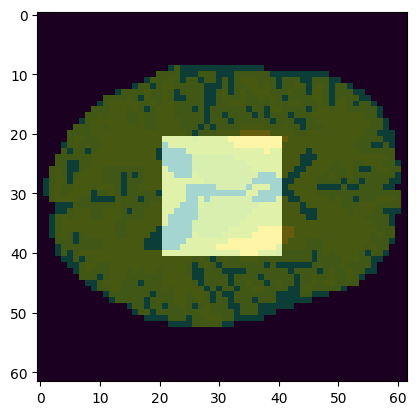

In [107]:
# plt.figure(figsize=(6, 6))
plt.imshow(Ireal_jonhead3.cpu().numpy()[:,:,31])  # Display the first image in grayscale
plt.imshow(iv.cpu().numpy()[:,:,31], alpha=0.6,cmap='gray')  
plt.show()

In [34]:
## to t1map
t1_tab={
    'bg':1e6,
    'wm':1107,
    'gm':1470,
    'csf':4000,
    'thalamus':954,
    'caudate':1192,
    'putamen':1076,
}#ms ref:https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9626833/
t2_tab={
    'bg':1,
    'wm':75,
    'gm':83,
    'csf':2000,
    'thalamus':83,
    'caudate':83,
    'putamen':83,
}
PD_tab={
    'bg':0,
    'wm':0.77,
    'gm':0.86,
    'csf':1,
    'thalamus':0.70,
    'caudate':0.80,
    'putamen':0.86,
}

def cmp(labelmap,labels):
    r''' compare labelmap against values in 'labels'
    Inputs:
        -labelmap: [nx,ny,nz] array
        -labels: list
    '''
    out=np.zeros(labelmap.shape,dtype=bool)
    for label in labels:
        tmp=labelmap==label
        out=out | tmp
    return out

def labelmap_2_tissuemap(label_map,t1_tab,t2_tab,PD_tab):
    r""" generate t1map/t2map/PDmap from label_map according to t1_tab/t2_tab/PD_tab
    Inputs:
        - ``label_map``: [nx,ny,nz] ndarray containing tissue labels map
        - ``t1_tab``: dictionary, t1 values look-up table
        - ``t2_tab``: dict, 
        - ``PD_tab``: dict,
    Outputs:
        - ``t1map``: [nx,ny,nz] ndarray 
        - ``t2map``:
        - ``PDmap``:
    """
    bg=cmp(label_map,(0,))
    wm=cmp(label_map,(16,2,41,7,46,28,60,13,17,18,26,52,53,54,58))
    gm=cmp(label_map,(3,8,42,47))
    csf= cmp(label_map,(24,4,5,14,15,43,44)) 
    thalamus= cmp(label_map,(10,49))
    caudate=cmp(label_map,(11,50))
    putamen=cmp(label_map,(12,51))
    
    t1map=bg*t1_tab['bg']+wm*t1_tab['wm']+gm*t1_tab['gm']+csf*t1_tab['csf']+ \
    thalamus*t1_tab['thalamus']+caudate*t1_tab['caudate']+putamen*t1_tab['putamen']
    t2map=bg*t2_tab['bg']+wm*t2_tab['wm']+gm*t2_tab['gm']+csf*t2_tab['csf']+ \
    thalamus*t2_tab['thalamus']+caudate*t2_tab['caudate']+putamen*t2_tab['putamen']
    PDmap=bg*PD_tab['bg']+wm*PD_tab['wm']+gm*PD_tab['gm']+csf*PD_tab['csf']+ \
    thalamus*PD_tab['thalamus']+caudate*PD_tab['caudate']+putamen*PD_tab['putamen']

    return t1map,t2map,PDmap


## Simulate + CGSENSE 

In [14]:
#[t1map,t2map,pdmap]=labelmap_2_tissuemap(mprage_pad,t1_tab,t2_tab,PD_tab)
#t1map=t1map*1e-3
#t2map=t2map*1e-3
tissue_map=np.load('./jonhead_tissuemap.npz')
t1map=tissue_map['t1map']
t2map=tissue_map['t2map']
pdmap=tissue_map['pdmap']

t1map_tc=torch.tensor(t1map,device=device0).unsqueeze(0)
t2map_tc=torch.tensor(t2map,device=device0).unsqueeze(0)
pdmap_tc=torch.tensor(pdmap,device=device0).unsqueeze(0)

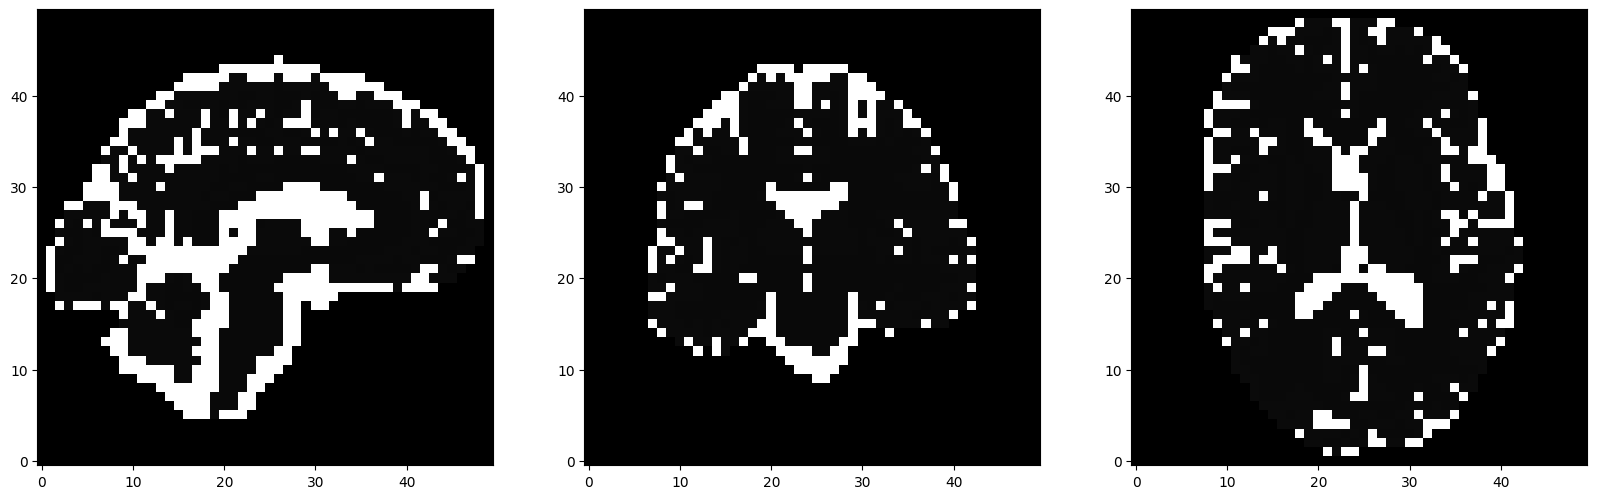

In [15]:
SACshow(t2map_tc[0,...].cpu().numpy(),pad=False)

In [16]:
M0=torch.zeros(pdmap_tc.shape+(3,),device=device0)
M0[...,2]=pdmap_tc

In [17]:
fov=torch.tensor([[24,24,24]],device=device0)

In [18]:
jon_head=SpinCube(t1map_tc.shape,fov,T1=t1map_tc,T2=t2map_tc,M=M0,device=device0)

In [19]:
init_pulses='/home/yonglihe/github/HolisticMRI/InitialPulse/pIni_OV90.npz'
pIni_data=np.load(init_pulses)
rf=pIni_data['rf'][None,...] #[1, xy, nT]
gr=pIni_data['gr'][None,...]#[1,xyz,nT]


rf_torch=torch.tensor(rf,device=device0)#[nbatch,xyz,nT]
gr_torch=torch.tensor(gr,device=device0)#[nbatch,xyz,nT]

pIni=Pulse(rf=rf_torch,gr=gr_torch,device=device0)

In [28]:
Mss=jon_head.applypulse_ss(pIni, doEmbed=True,betaoff=True,alpha=20,TR=80e-3) #[nbatch,*nM,xyz]
Mss=Mss.nan_to_num()


In [29]:
Ireal_jonhead=Mss[...,2]
Ireal_jonhead.shape

torch.Size([1, 50, 50, 50])

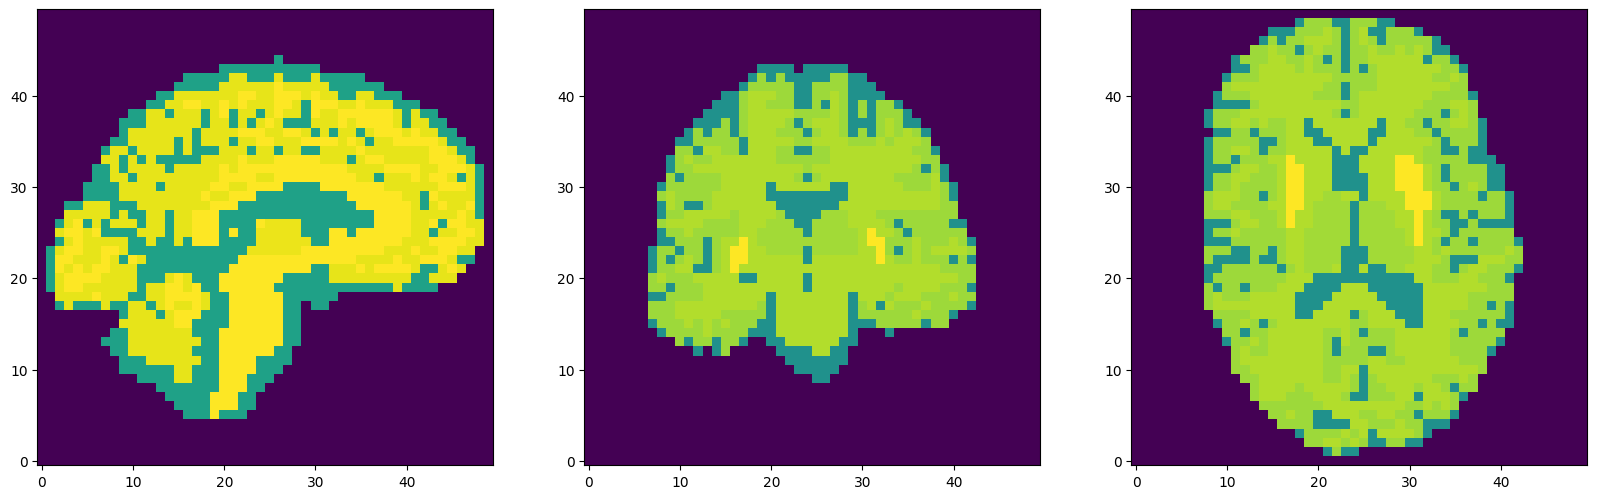

In [30]:
SACshow(Ireal_jonhead[0,...].cpu().numpy(),pad=False,cmap='viridis')

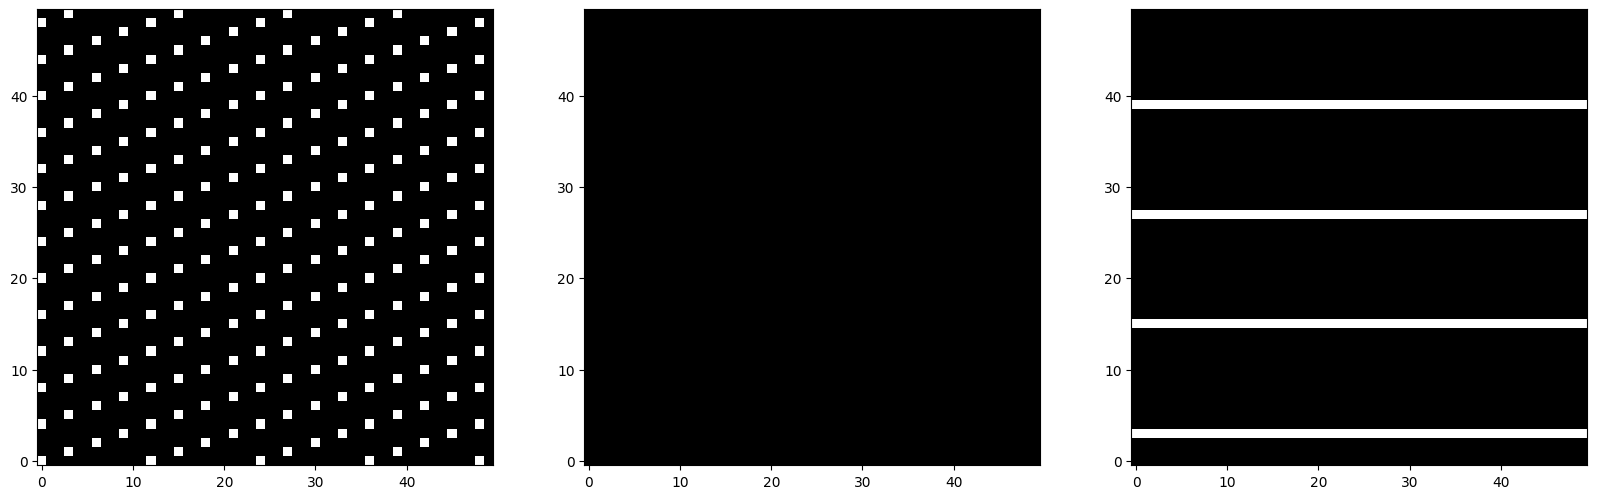

In [31]:
smap=scipy.io.loadmat('./jonhead_smap_resized.mat')['smap']
smap=torch.tensor(smap).to(device0)
[nc,nx,ny,nz]=smap.shape

#sampling pattern
# mask = torch.zeros(nx,ny,nz).to(device0)
# mask[:,0:ny:4,0:nz:4]=1
etl=torch.zeros(12,ny).to(device0)
etl[0,::4]=1
etl[3,1::4]=1
etl[6,2::4]=1
etl[9,3::4]=1
kyz=etl.repeat(ny//12,1)
kyz=torch.cat((kyz,etl[:ny-kyz.shape[0],:]),dim=0)
# plt.imshow(kyz)
# plt.show()

caipi_mask=kyz.unsqueeze(0).repeat(nx,1,1)
caipi_mask.shape
SACshow(caipi_mask.cpu().numpy())

In [32]:
Sop=Sense(smap.unsqueeze(0),caipi_mask.unsqueeze(0))

In [33]:
Mz=Mss[...,2].unsqueeze(1) #[nbatch,1,nx,ny,nz]
Mz.shape

torch.Size([1, 1, 50, 50, 50])

In [34]:
kunder=Sop*Mz
noise_level=10e-4#5e-6

kunder=kunder+noise_level*torch.randn_like(kunder)
Iunder=Sop.H*kunder
Iunder3=Iunder.squeeze(0).squeeze(0) #[nx,ny,nz]

I = Identity(Mz.shape)
CG_solver = CG(Sop.H*Sop+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
Irecon = CG_solver.run(Iunder,Iunder)

In [35]:
pos=torch.abs(kunder)>1e-7
nM=torch.sum(pos.int())
torch.sum(torch.abs(kunder))/nM

tensor(0.0014, device='cuda:0')

In [36]:
Irecon3=Irecon.squeeze(0).squeeze(0)

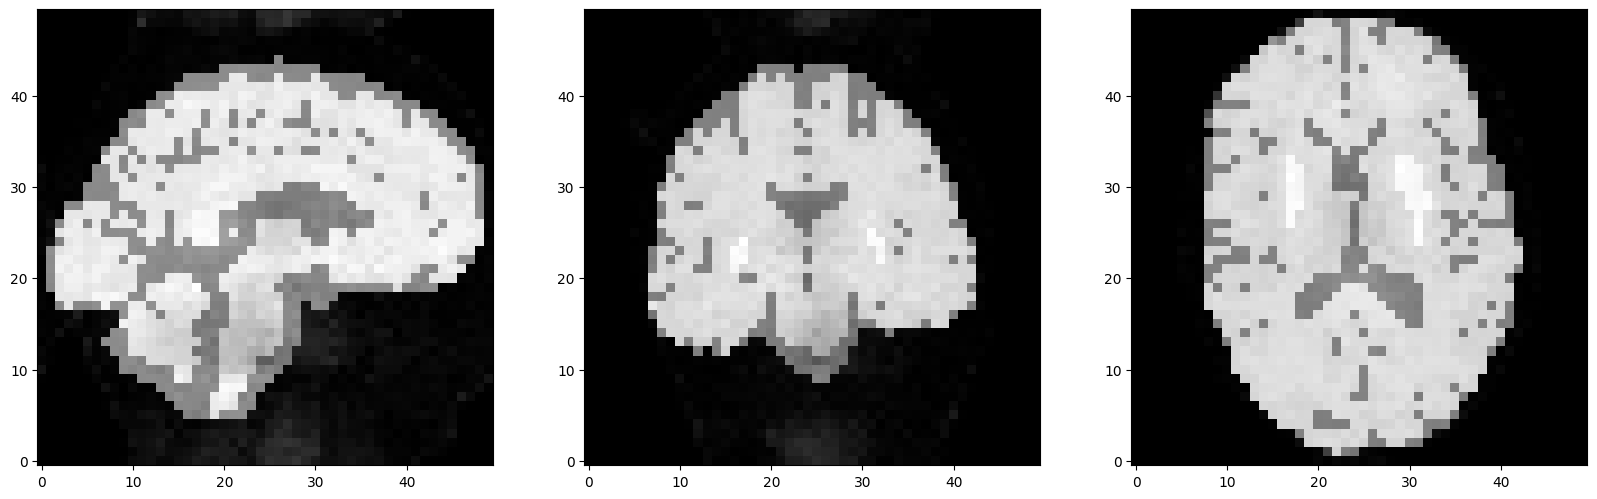

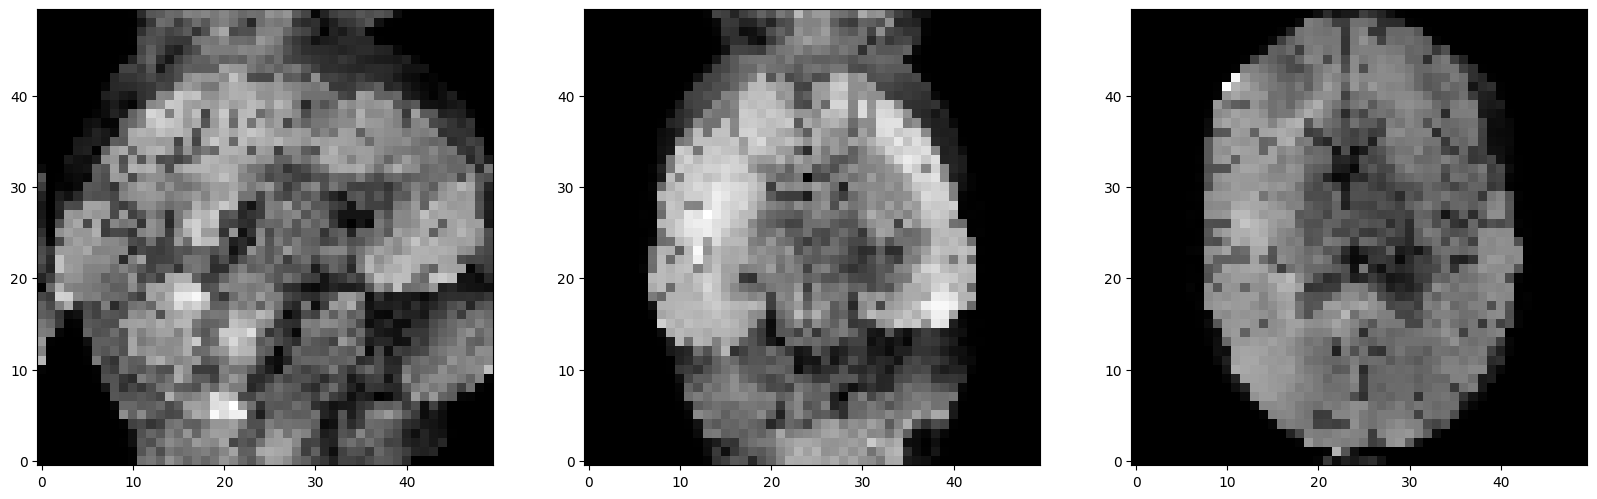

In [37]:
SACshow(abs(Irecon3).cpu().numpy())
SACshow(abs(Iunder3).cpu().numpy())

In [38]:
iv=torch.zeros_like(caipi_mask)
iv[nx//2-nx//4+5:nx//2+nx//4-5,ny//2-ny//4+5:ny//2+ny//4-5,nz//2-nz//4+5:nz//2+nz//4-5]=1
psnr=PSNR(torch.abs(Ireal_jonhead[0,...]),torch.abs(Irecon3),iv)

In [39]:
psnr

tensor(30.7682, device='cuda:0')

In [40]:
Ireal_jonhead3=Ireal_jonhead[0,...]
Ireal_norm=(torch.abs(Ireal_jonhead3)-torch.abs(Ireal_jonhead3).min())/(torch.abs(Ireal_jonhead3).quantile(0.9999)-torch.abs(Ireal_jonhead3).min())
Irecon_norm=(torch.abs(Irecon3)-torch.abs(Irecon3).min())/(torch.abs(Irecon3).quantile(0.9999)-torch.abs(Irecon3).min())

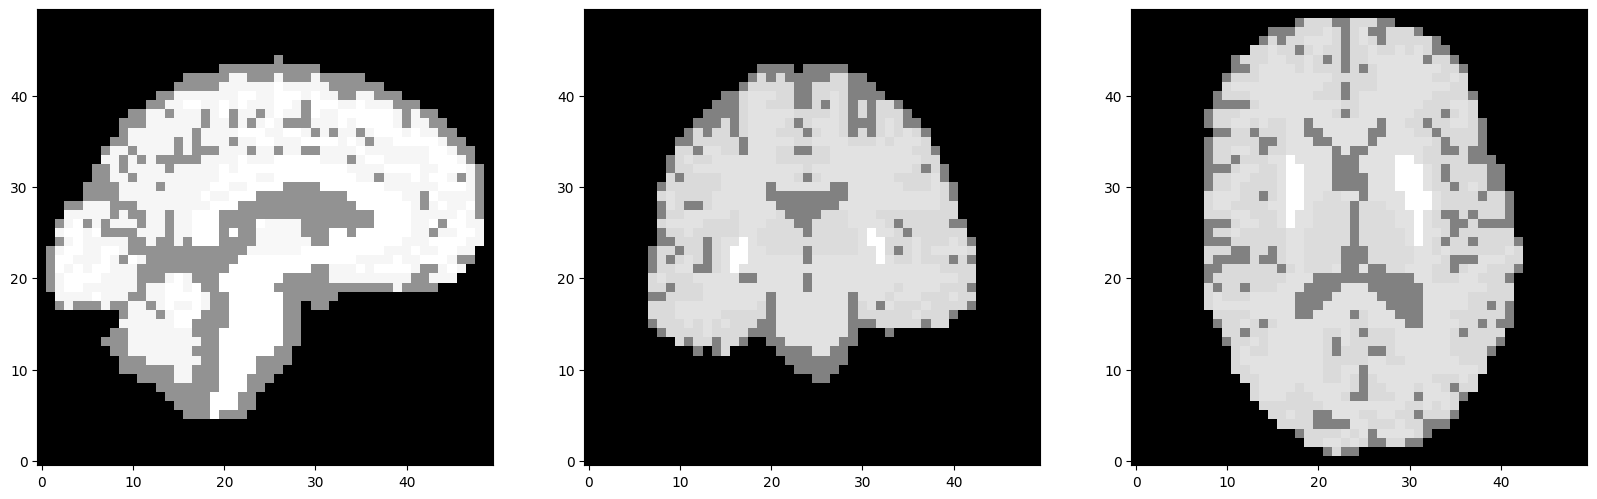

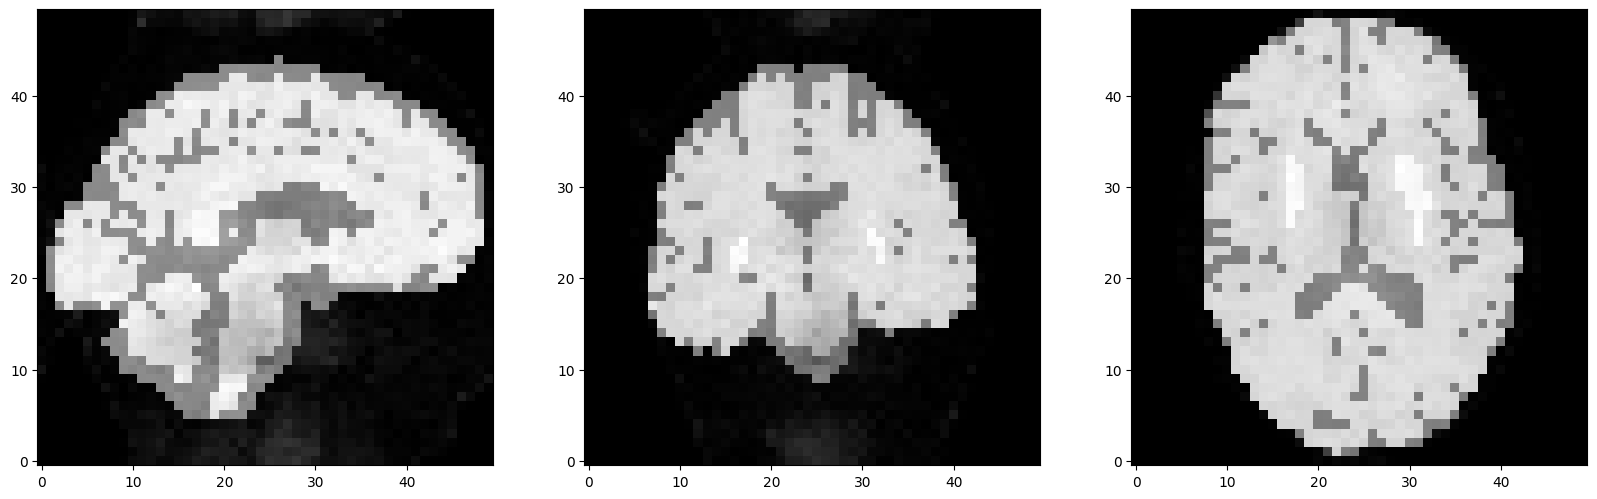

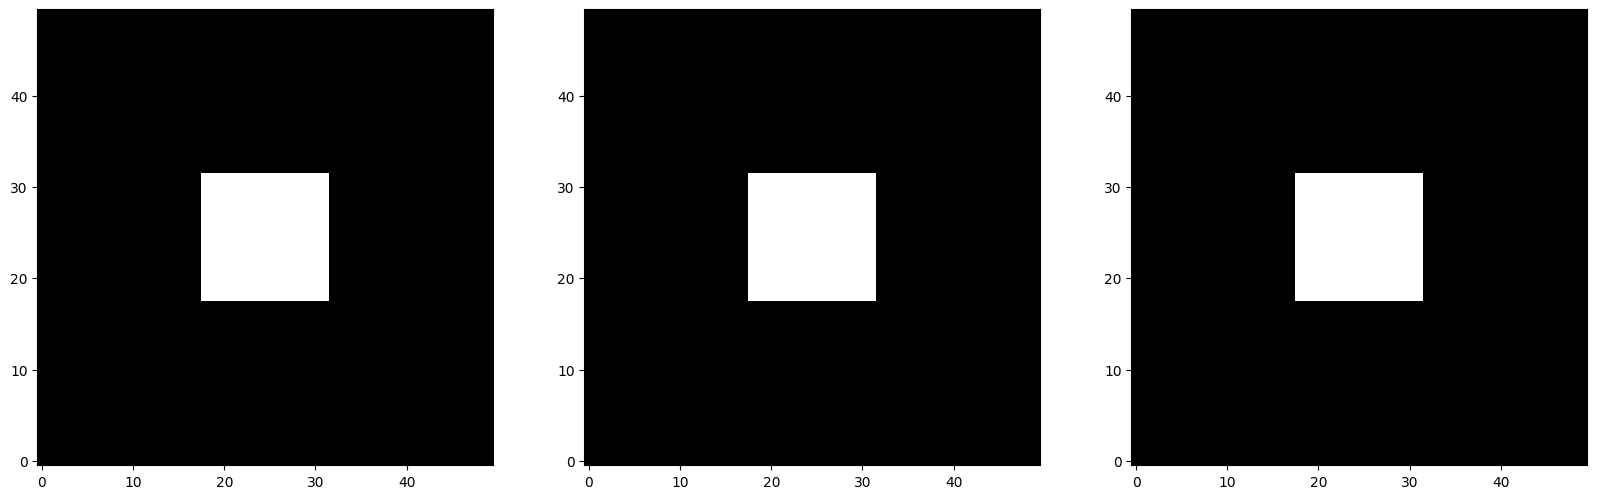

In [41]:
SACshow(abs(Ireal_norm).cpu().numpy())
SACshow(abs(Irecon_norm).cpu().numpy())
SACshow(iv.cpu())

In [42]:
psnr=PSNR(Ireal_norm,Irecon_norm,iv)
print(f"baseline(hard-pulse) PSNR:{psnr}")

baseline(hard-pulse) PSNR:28.940725326538086


## Look at optimized pulse

In [43]:
pIni_path='./pIni-from-ROITrained.npz'
model=End2EndModel(tissue_path,pIni_path,sampling_pattern,iv,checkpoint_savepth='./checkpoint/jonhead_caipi4by3/',noise_level=5e-4)
model.load_network('./checkpoint/jonhead_caipi4by3-TR80ms/iter_4_checkpoint.pth')

trho=model.tρ.detach()
ttheta=model.θ.detach()
tsl=model.tsl.detach()
rf_opt= utils.tρθ2rf(trho, ttheta, rfmax0.to(device0))
gr_opt= utils.s2g(utils.ts2s(tsl, torch.tensor(15e3).to(device0)), dt0.to(device0))


Checkpoint loaded from: ./checkpoint/jonhead_caipi4by3-TR80ms/iter_4_checkpoint.pth


/tmp/ipykernel_1955454/270914935.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)


In [44]:
pAD=Pulse(rf=rf_opt,gr=gr_opt, smax=torch.tensor(15e3).to(device0),device=device0)

In [45]:
trained_pulse_path='./pIni-from-ROITrained.npz'
trained_pulse_data=np.load(trained_pulse_path)
rf_trained=trained_pulse_data['rf'][None,...] #[1, xy, nT]
gr_trained=trained_pulse_data['gr'][None,...]#[1,xyz,nT]


rf_torch=torch.tensor(rf_trained,device=device0)#[nbatch,xyz,nT]
gr_torch=torch.tensor(gr_trained,device=device0)#[nbatch,xyz,nT]

ptrained=Pulse(rf=rf_torch,gr=gr_torch,device=device0)

In [46]:
Mss_opt=jon_head.applypulse_ss(pAD,doEmbed=True)
Mss_ini=jon_head.applypulse_ss(pIni,doEmbed=True)
Mss_trained=jon_head.applypulse_ss(ptrained,doEmbed=True)

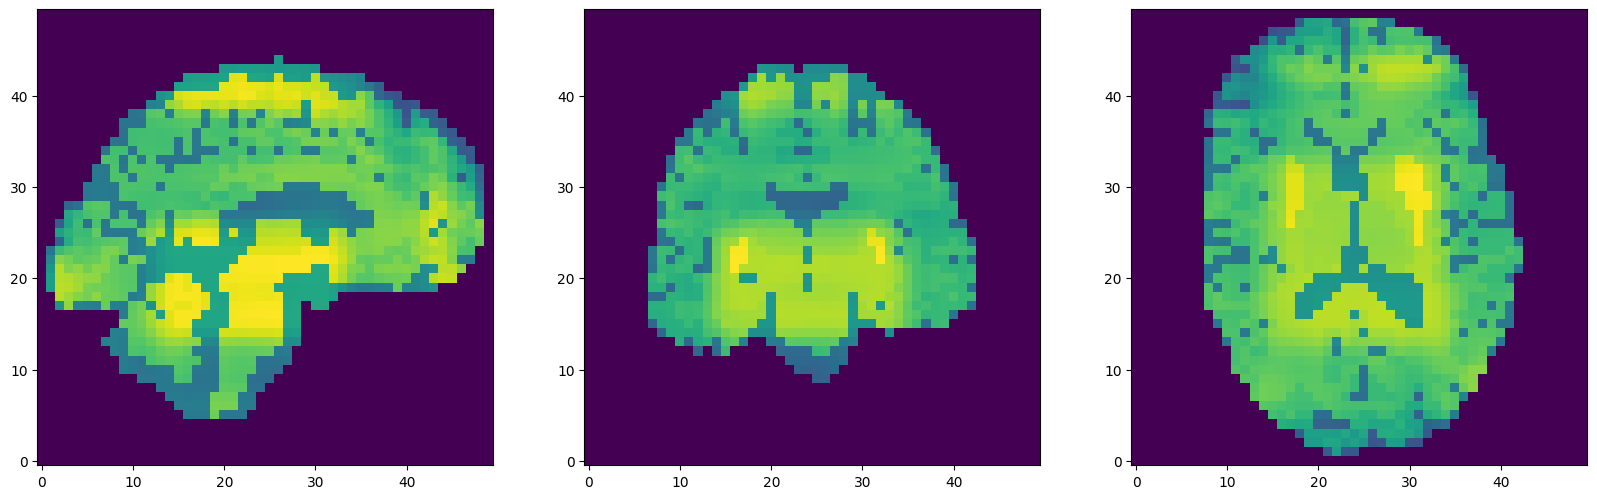

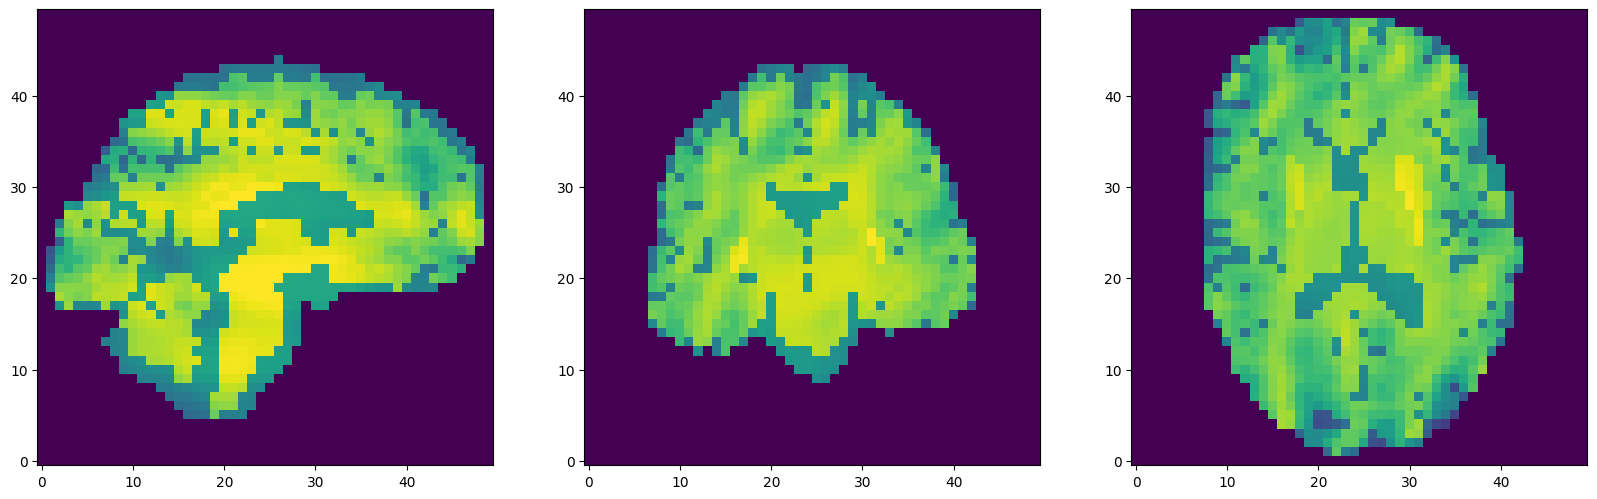

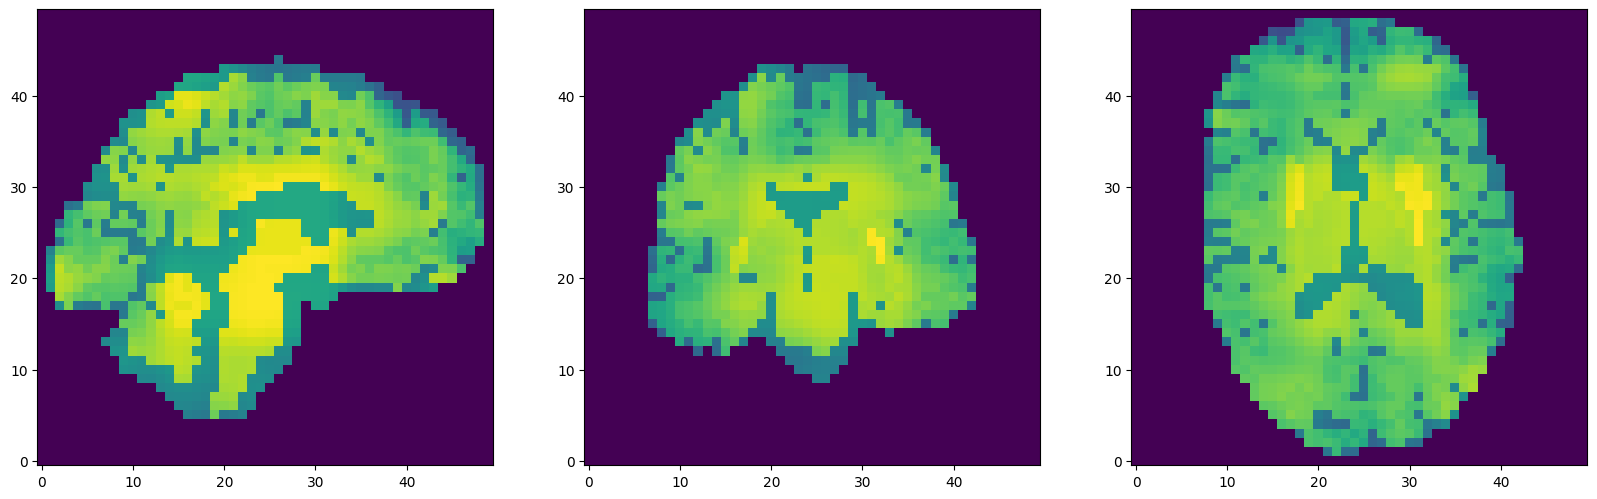

In [47]:
SACshow(Mss_ini[0,...,2].cpu().numpy(),cmap='viridis')
SACshow(Mss_trained[0,...,2].cpu().numpy(),cmap='viridis')
SACshow(Mss_opt[0,...,2].cpu().numpy(),cmap='viridis')

In [48]:
def compare_pulses(pulses,legends):
    r'''display multiple mobjs.Pulse objects for comparison
    Input:
    - ``pulses``: list of Pulse objects
    - ``legends``: list of legends
    '''
    dt=pulses[0].dt.numpy() if pulses[0].device=='cpu' else pulses[0].dt.cpu().numpy()
    
    tt=np.arange(0,pulses[0].gr.shape[-1])*(dt)*1e3
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(8,10))
    
    ax1.set_xlabel('time(ms)')
    ax1.set_ylabel('Gauss/cm')
    ax1.set_title('Gx')
    ax2.set_ylabel('Gauss/cm')
    ax2.set_title('Gy')
    ax3.set_ylabel('Gauss/cm')
    ax3.set_title('Gz')
    
    ax4.set_ylabel('Gauss')
    ax4.set_title('|b1|')
    
    ax5.set_ylabel('Rad')
    ax5.set_title('∠b1')
    
    for i,p in enumerate(pulses):
        [gx,gy,gz,rf_mag,rf_phase]=pulse2np(p)
        ax1.plot(tt,gx,label=legends[i])
        ax2.plot(tt,gy,label=legends[i])
        ax3.plot(tt,gz,label=legends[i])
        ax4.plot(tt,rf_mag,label=legends[i])
        ax5.plot(tt,rf_phase,label=legends[i])
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()
    
    plt.tight_layout()
    plt.show()
    return

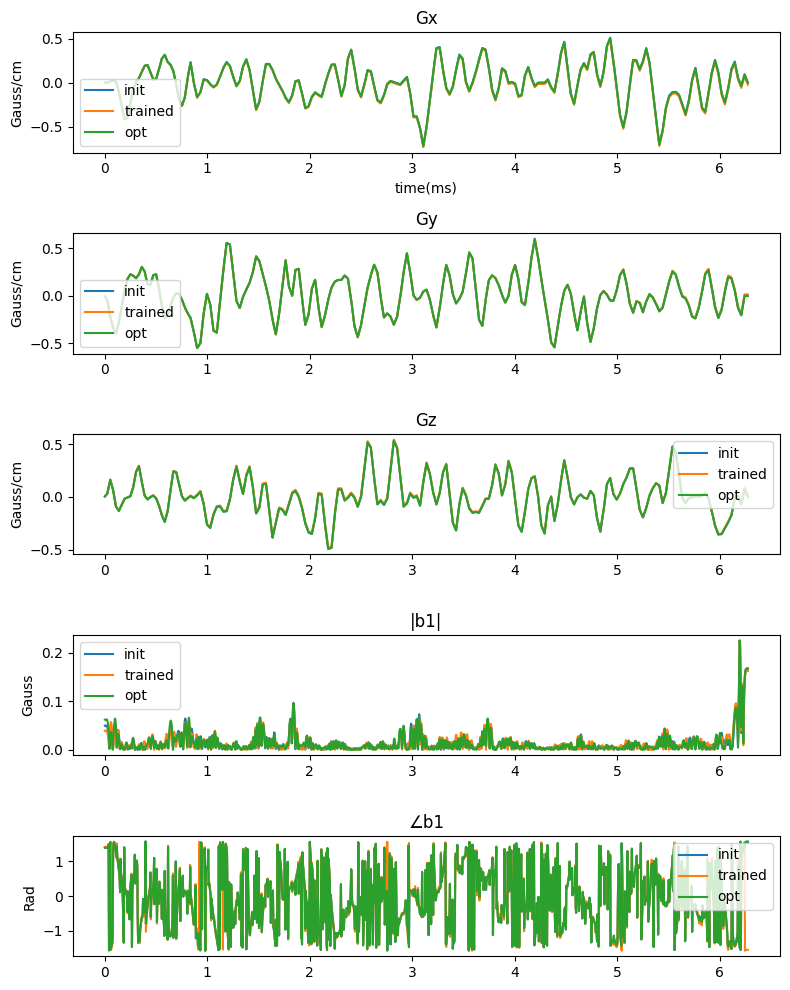

In [49]:
compare_pulses([pIni,ptrained,pAD],['init','trained','opt'])

In [50]:
def Mss2Irecon(Sop,Mss,noise=10e-4):
    r'''
    Input:
    - ``Sop``: SENSE forward operator
    - ``Mss``: steady-state magnetization [nbatch,*nM]
    Output:
    - ``Irecon_norm``: normalized recon image [*nM]
    '''
    Mz=Mss[...,2].unsqueeze(1) #[nbatch,1,nx,ny,nz]

    kunder=Sop*Mz
    #noise_level=10e-4#5e-6

    kunder=kunder+noise*torch.randn_like(kunder)
    Iunder=Sop.H*kunder
    Iunder3=Iunder.squeeze(0).squeeze(0) #[nx,ny,nz]

    I = Identity(Mz.shape)
    CG_solver = CG(Sop.H*Sop+1e-7*I, max_iter=20, tol=1e-20, alert=False) # define a CG
    Irecon = CG_solver.run(Iunder,Iunder)
    Irecon3=Irecon.squeeze(0).squeeze(0)
    Irecon_norm=(torch.abs(Irecon3)-torch.abs(Irecon3).min())/(torch.abs(Irecon3).quantile(0.9999)-torch.abs(Irecon3).min())
    return Irecon_norm

In [51]:
Irecon_norm_ini=Mss2Irecon(Sop,Mss_ini)
Irecon_norm_opt=Mss2Irecon(Sop,Mss_opt)
Irecon_norm_trained=Mss2Irecon(Sop,Mss_trained)

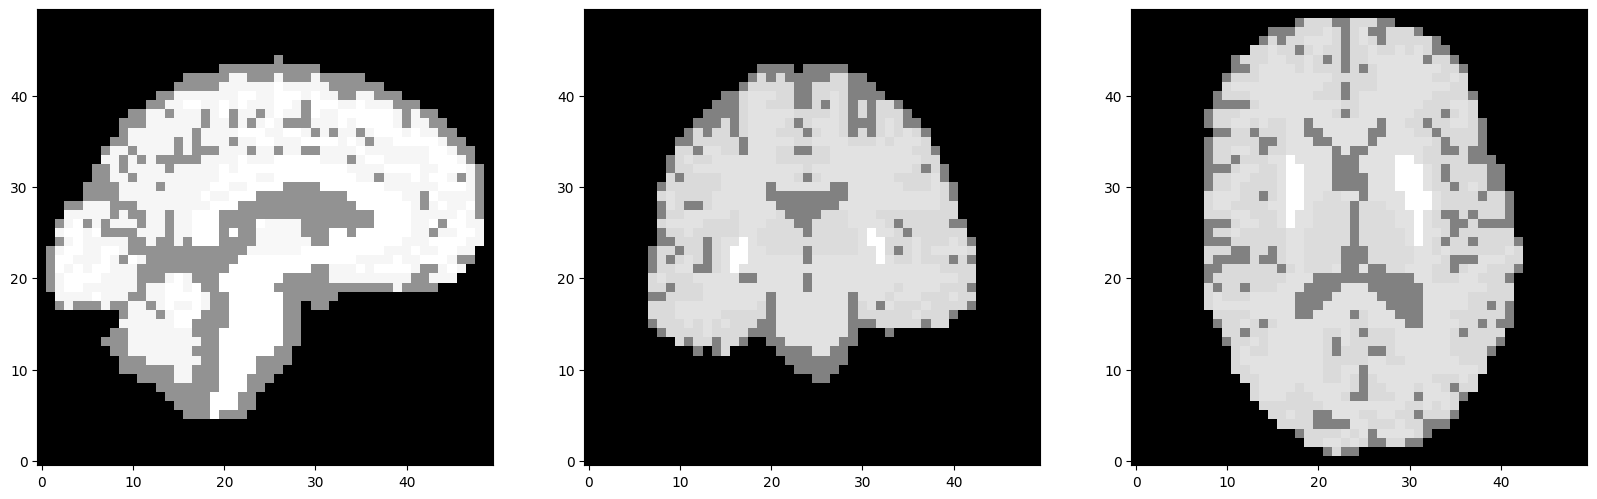

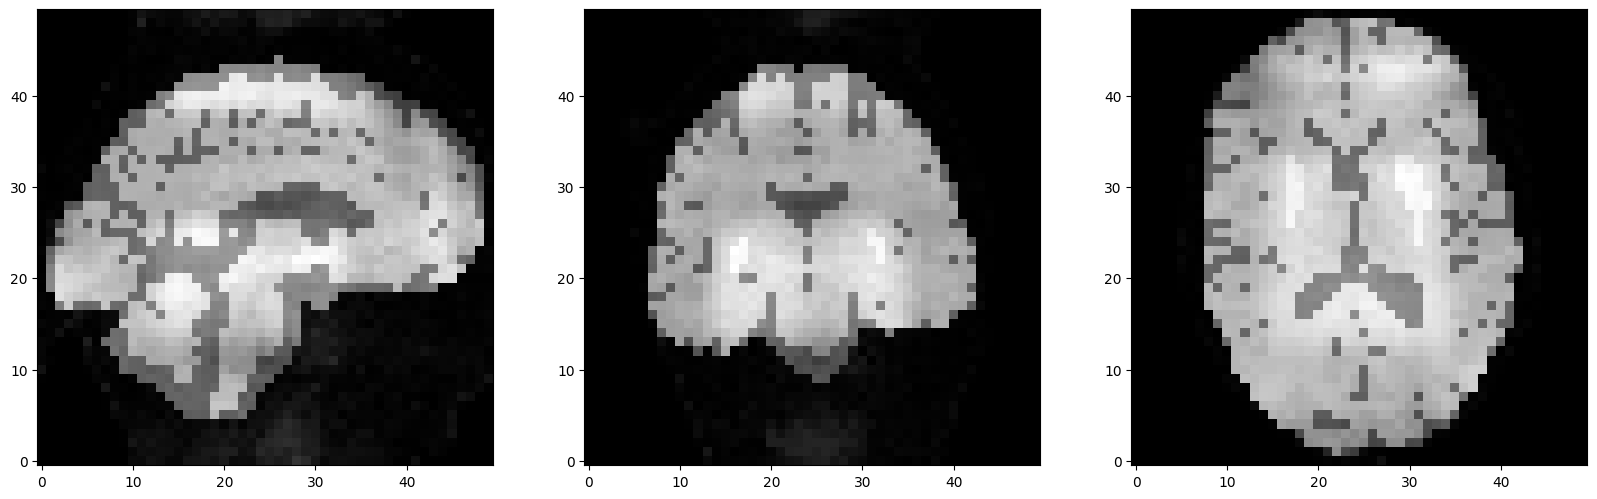

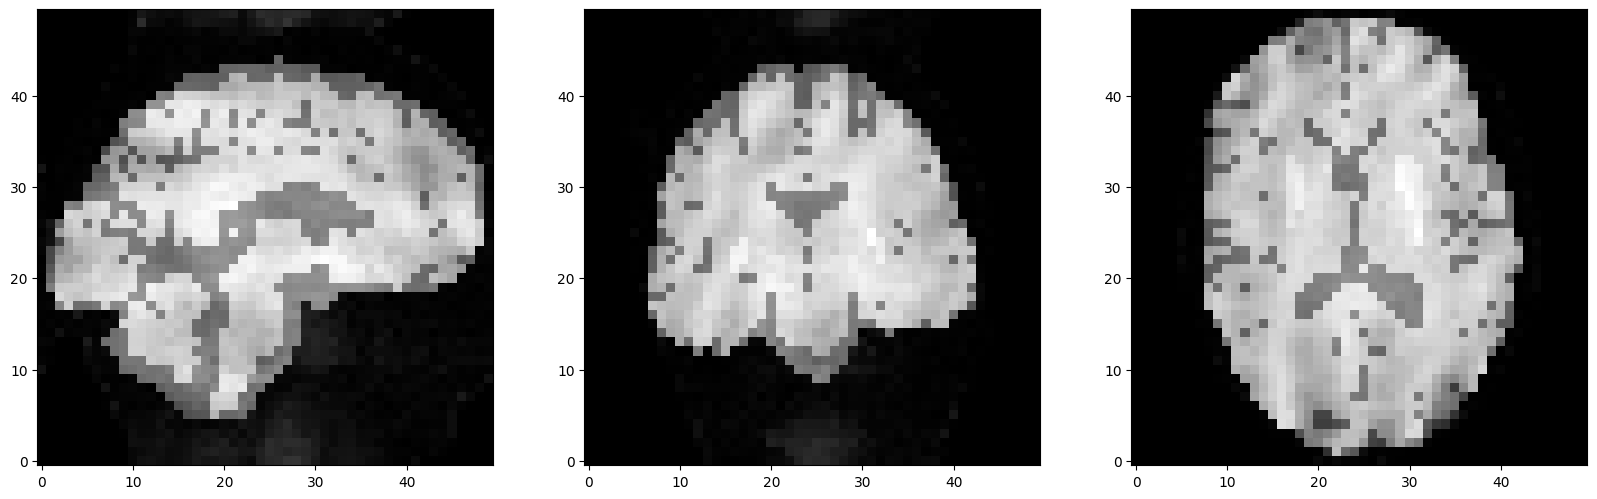

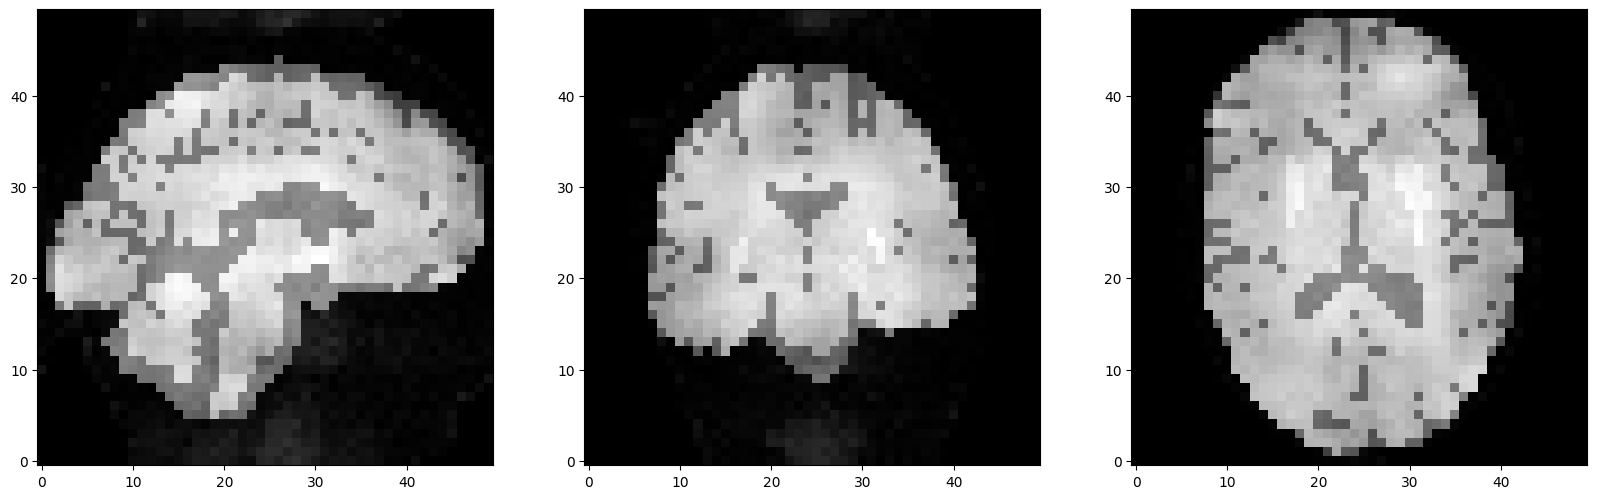

In [52]:
SACshow(Ireal_norm.cpu())
SACshow(Irecon_norm_ini.cpu())
SACshow(Irecon_norm_trained.cpu())
SACshow(Irecon_norm_opt.cpu())

In [53]:

psnr_ini=PSNR(Ireal_norm,Irecon_norm_ini,iv)
psnr_trained=PSNR(Ireal_norm,Irecon_norm_trained,iv)
psnr_opt=PSNR(Ireal_norm,Irecon_norm_opt,iv)
print(f"PSNR init:{psnr_ini}\nPSNR trained:{psnr_trained}\nPSNR opt:{psnr_opt}")

PSNR init:18.06869888305664
PSNR trained:29.211864471435547
PSNR opt:30.646095275878906


Display errors

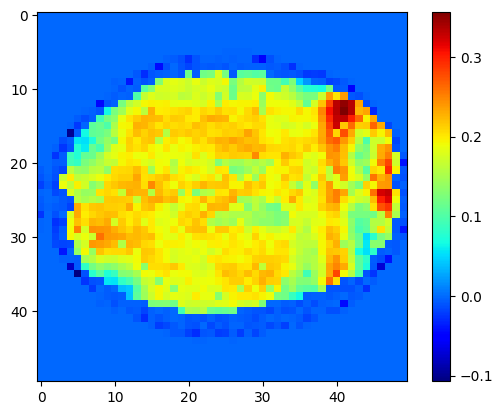

In [54]:
#pIniOV90
Ireal_sl=Ireal_norm[:,:,30].cpu().numpy() #slice
Irecon_ini_sl=Irecon_norm_ini[:,:,30].cpu().numpy()
plt.imshow(Ireal_sl-Irecon_ini_sl,cmap='jet')
plt.colorbar()
plt.show()

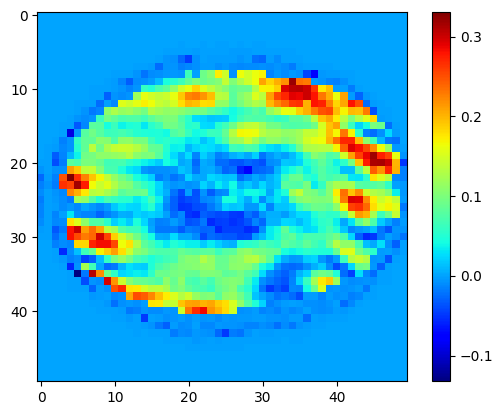

In [55]:
#off-line trained
Ireal_sl=Ireal_norm[:,:,30].cpu().numpy() #slice
Irecon_trained_sl=Irecon_norm_trained[:,:,30].cpu().numpy()
plt.imshow(Ireal_sl-Irecon_trained_sl,cmap='jet')
plt.colorbar()
plt.show()

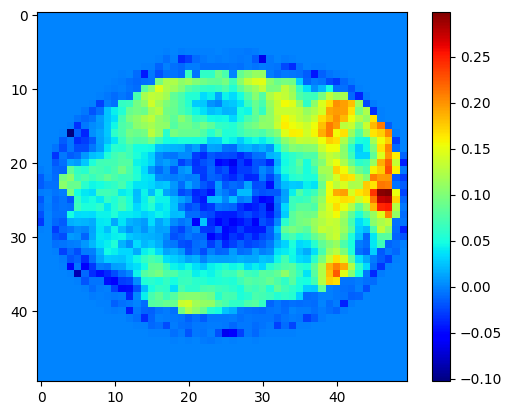

In [56]:
#optimal
Ireal_sl=Ireal_norm[:,:,30].cpu().numpy() #slice
Irecon_opt_sl=Irecon_norm_opt[:,:,30].cpu().numpy()
plt.imshow(Ireal_sl-Irecon_opt_sl,cmap='jet')
plt.colorbar()
plt.show()

In [57]:
#hard-pulse
Ireal_sl=Ireal_norm[:,:,30].cpu().numpy() #slice
Irecon_hp_sl=Irecon_norm[:,:,30].cpu().numpy()

In [58]:
def errormap_cmp(images,titles,caxis):
    r''' show image1-3 in same colorbar
    images: list of images to be displayed
    titles: titles for each subplot
    caxis: color limits for the shared cbar, list of 2 values
    '''
    n=len(images)
    
    # Create figure and set up gridspec for proper colorbar alignment
    fig = plt.figure(figsize=(4*n, 4))
    gs = fig.add_gridspec(1, n+1,width_ratios=[1] * n + [0.05])  # n images + 1 colorbar
    
    
    axes=[]
    imgs = []
    for i,image in enumerate(images):
        ax = fig.add_subplot(gs[0, i])
        img = ax.imshow(image, cmap='jet', vmin=caxis[0], vmax=caxis[1])
        ax.set_title(titles[i])
        ax.axis('off')  # Remove axis labels
        axes.append(ax)  # Store the axis
        imgs.append(img)  # Store the image

    # Add a shared colorbar
    cbar = fig.colorbar(imgs[-1], cax=fig.add_subplot(gs[0, i+1]))
    cbar.set_label("Color Intensity")

    plt.tight_layout()
    plt.show()
    return

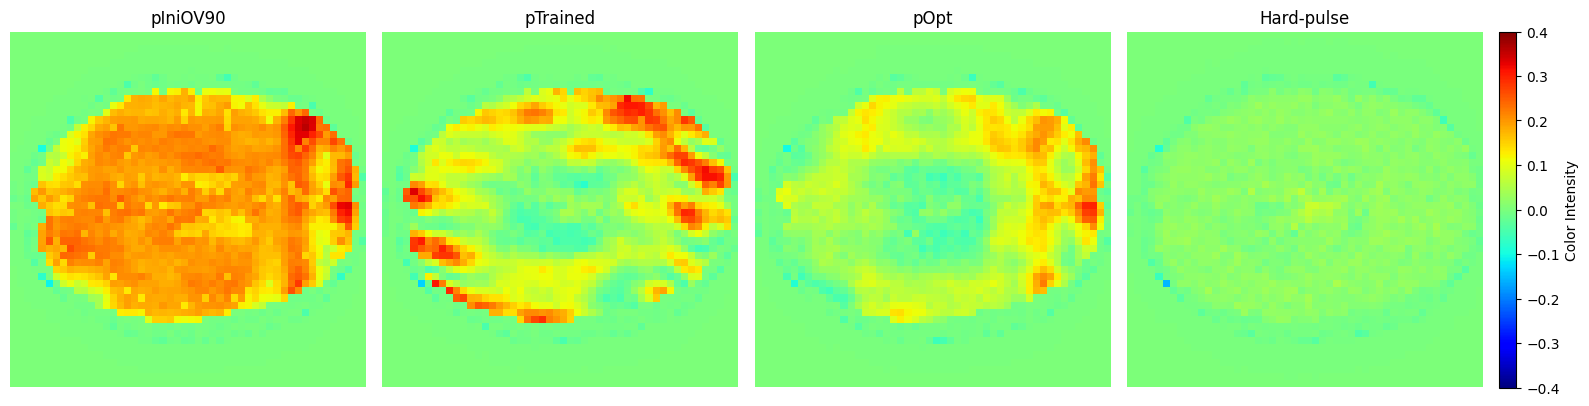

In [59]:
image1,image2,image3,image4=[Ireal_sl-Irecon_ini_sl,Ireal_sl-Irecon_trained_sl,Ireal_sl-Irecon_opt_sl,Ireal_sl-Irecon_hp_sl]
errormap_cmp([image1,image2,image3,image4],['pIniOV90','pTrained','pOpt','Hard-pulse'],[-0.4,0.4])

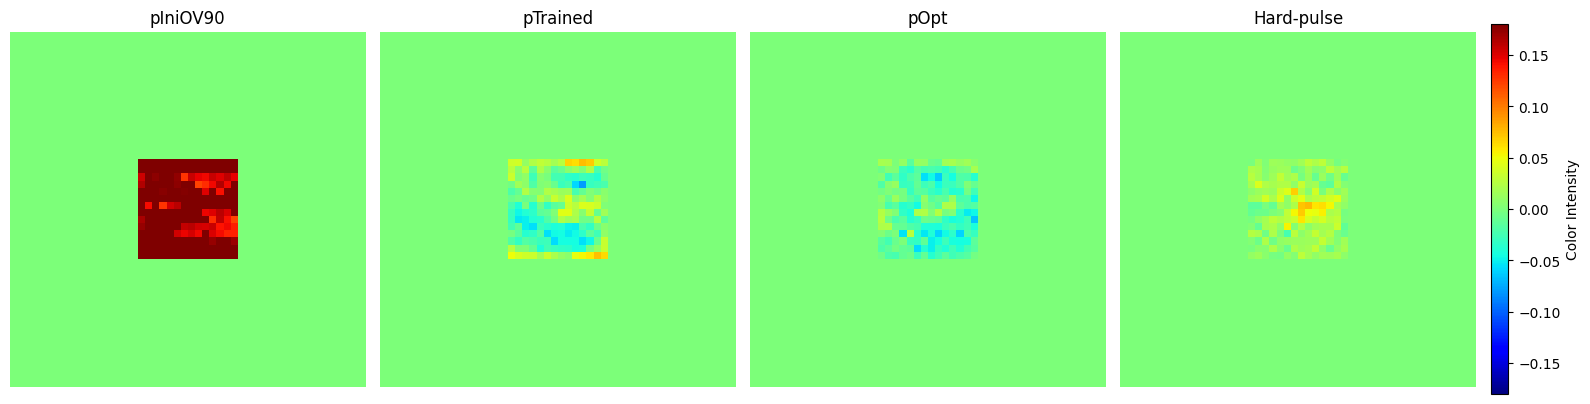

In [60]:
# masked error maps by ROI
mask2d=iv[:,:,30].cpu().numpy()
image1,image2,image3,image4=[(Ireal_sl-Irecon_ini_sl)*mask2d,(Ireal_sl-Irecon_trained_sl)*mask2d,(Ireal_sl-Irecon_opt_sl)*mask2d,(Ireal_sl-Irecon_hp_sl)*mask2d]
errormap_cmp([image1,image2,image3,image4],['pIniOV90','pTrained','pOpt','Hard-pulse'],[-0.18,0.18])

save the optimal pulse

In [61]:
data={'rf':pAD.rf.cpu().numpy(),
     'gr':pAD.gr.cpu().numpy()}
scipy.io.savemat('./checkpoint/jonhead_caipi4by3-TR80ms/optPulse-TR80ms.mat',data)

In [126]:
#caipi kykz=4by3 pattern
scipy.io.savemat('./checkpoint/jonhead_caipi4by3/kykz_mask.mat',{'mask':kyz.cpu().numpy()})